In [131]:
import time
import copy
import warnings
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.ensemble import VotingRegressor

In [132]:
warnings.filterwarnings('ignore')

In [133]:
%matplotlib inline

In [134]:
# Функция генерации таких же признаков, что использовались в бейзлайне с LAMA.
# Функция добавляет лаги, кумулятивную сумму, первое/последнее значение/минимум/максимум/медиану u_in.
# Кроме того функция удаляет из трейна циклы дыхания с аномальным отрицательным давлением.
def generate_features_v3(df, mode):
    data = copy.deepcopy(df)
    data['u_in_lag_1'] = data.groupby('breath_id')['u_in'].shift(1)
    data['u_in_lag_2'] = data.groupby('breath_id')['u_in'].shift(2)
    data['u_in_lag_-1'] = data.groupby('breath_id')['u_in'].shift(-1)
    data['u_in_lag_-2'] = data.groupby('breath_id')['u_in'].shift(-2)
    data['u_in_cumsum'] = data['u_in'].groupby(data['breath_id']).cumsum()
    data['u_in_first'] = data.groupby('breath_id')['u_in'].transform('first')
    data['u_in_last'] = data.groupby('breath_id')['u_in'].transform('last')
    data['u_in_min'] = data.groupby('breath_id')['u_in'].transform('min')
    data['u_in_max'] = data.groupby('breath_id')['u_in'].transform('max')
    data['u_in_median'] = data.groupby('breath_id')['u_in'].transform('median')
    data = data.fillna(0)
    
    if mode == "train":
        data_pressure_subzero = data[data['pressure'] < 0]
        pressure_subzero_id = list(set(data_pressure_subzero.breath_id.values))
        data = data[data['breath_id'].apply(lambda x: x not in pressure_subzero_id)]
        
    data = data.drop(['breath_id'], axis=1)
        
    return data


# Функция для записи логов об обучении и предикте.
def make_log(log_type, model, train_info, predict):
    
    if log_type == "train":
        logging.info('Train {}'.format(train_info))
        
    elif log_type == "gridsearch":
        logging.info('GridSearch {}'.format(train_info))
        
    elif log_type == "randomsearch":
        logging.info('RandomSearch {}'.format(train_info))    
        
    elif log_type == "predict":
        logging.info(model +' предсказание:\n{}\n Shape = {} \n'
              .format(predict, predict.shape))
        
        
# Функция для отрисовки матрицы корреляции столбцов датафрейма.    
def show_correlogram(df):
    
    plt.figure(figsize=(12,12), dpi= 80)
    sns.heatmap(
        df.corr(), xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, center=0, annot=True, cbar=False
    )
    plt.title('Корреляция между признаками', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=12)
    plt.show()
    
    
# Функция для сохранения сгенерированных файлов для сабмита.
def make_submission_file(predict, filename):
    df_sample_submission = copy.deepcopy(df_sample)
    df_sample_submission[TARGET_NAME] = predict
    df_sample_submission.to_csv(filename, index=False)
    df_sample_submission.head()    

In [135]:
# Будем логировать обучение моделей.
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s',
                    level=logging.INFO, filename="log2.log",filemode="a")

In [136]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TARGET_NAME = 'pressure'

# for reproducibility
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [137]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')

### Сгенерируем новые признаки для трейна (удалив аномальные отрицательные значения). На трейне останется 75377 временных циклов.  Удалим 2 временных цикла из трейна чтобы получить число, которое нацело делится на количество фолдов = 5 в TimeSeriesSplit.  Это нужно чтобы циклы дыхания попадали в фолды целиком и чтобы цикл дыхания не был разорван на 2 разных фолда.

In [138]:
# Сгенерируем новые признаки для трейна.
train = generate_features_v3(df_train, "train")

# Возьмем все циклы дыхания кроме двух последних.
train = train.iloc[: 75375*80]

train.head()

,id,R,C,time_step,u_in,u_out,pressure,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.000000,18.383041,22.509278,0.083334,0.083334,4.987079,0.0,28.313036,4.922568
1,2,20,50,0.033652,18.383041,0,5.907794,0.083334,0.000000,22.509278,22.808822,18.466375,0.083334,4.987079,0.0,28.313036,4.922568
2,3,20,50,0.067514,22.509278,0,7.876254,18.383041,0.083334,22.808822,25.355850,40.975653,0.083334,4.987079,0.0,28.313036,4.922568
3,4,20,50,0.101542,22.808822,0,11.742872,22.509278,18.383041,25.355850,27.259866,63.784476,0.083334,4.987079,0.0,28.313036,4.922568
4,5,20,50,0.135756,25.355850,0,12.234987,22.808822,22.509278,27.259866,27.127486,89.140326,0.083334,4.987079,0.0,28.313036,4.922568


In [139]:
# Сгенерируем новые признаки для теста.
test = generate_features_v3(df_test, "test")

test.head()

,id,R,C,time_step,u_in,u_out,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,1,5,20,0.000000,0.000000,0,0.000000,0.000000,7.515046,14.651675,0.000000,0.0,4.973375,0.0,37.542219,4.683875
1,2,5,20,0.031904,7.515046,0,0.000000,0.000000,14.651675,21.230610,7.515046,0.0,4.973375,0.0,37.542219,4.683875
2,3,5,20,0.063827,14.651675,0,7.515046,0.000000,21.230610,26.320956,22.166721,0.0,4.973375,0.0,37.542219,4.683875
3,4,5,20,0.095751,21.230610,0,14.651675,7.515046,26.320956,30.486938,43.397331,0.0,4.973375,0.0,37.542219,4.683875
4,5,5,20,0.127644,26.320956,0,21.230610,14.651675,30.486938,33.545950,69.718287,0.0,4.973375,0.0,37.542219,4.683875


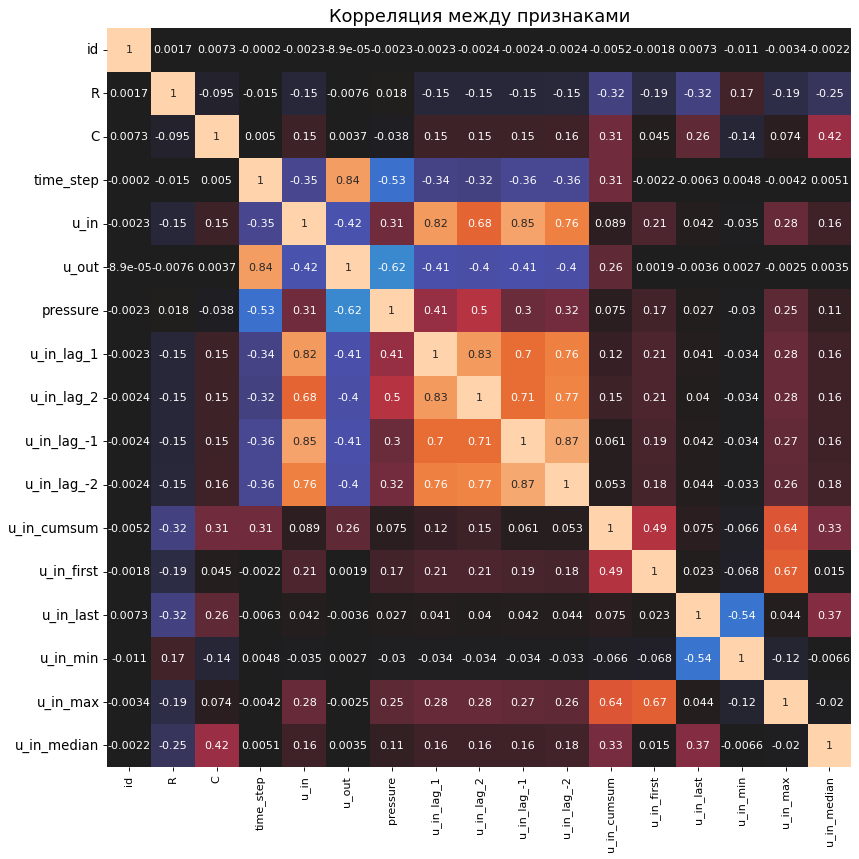

In [140]:
show_correlogram(train)

### Стоит обратить внимание на корреляцию признаков u_in и созданных на его основе u_in_lag_1, u_in_lag_2, u_in_lag_-1, u_in_lag_-2. На корреляцию u_in_cumsum и u_in_first, u_in_max. На корреляцию u_out и timestep. В линейных моделях это вызовет проблемы с мультиколлинеарностью. Поэтому специально для использования линейных моделей придется удалить признаки коррелирующие выше определённого порога. Установим в качестве порога 0.7 и удалим те коррелирующие признаки, которые имеют меньшую корреляцию с таргетом.
https://habr.com/ru/companies/akbarsdigital/articles/592493/

In [141]:
train_linear = train.drop(["id", "time_step", "u_in", "u_in_lag_1", "u_in_lag_-1", "u_in_lag_-2"], axis=1)

test_linear = test.drop(["id", "time_step", "u_in", "u_in_lag_1", "u_in_lag_-1", "u_in_lag_-2"], axis=1)

In [142]:
train_linear.head()

,R,C,u_out,pressure,u_in_lag_2,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,20,50,0,5.837492,0.000000,0.083334,0.083334,4.987079,0.0,28.313036,4.922568
1,20,50,0,5.907794,0.000000,18.466375,0.083334,4.987079,0.0,28.313036,4.922568
2,20,50,0,7.876254,0.083334,40.975653,0.083334,4.987079,0.0,28.313036,4.922568
3,20,50,0,11.742872,18.383041,63.784476,0.083334,4.987079,0.0,28.313036,4.922568
4,20,50,0,12.234987,22.509278,89.140326,0.083334,4.987079,0.0,28.313036,4.922568


In [143]:
test_linear.head()

,R,C,u_out,u_in_lag_2,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,5,20,0,0.000000,0.000000,0.0,4.973375,0.0,37.542219,4.683875
1,5,20,0,0.000000,7.515046,0.0,4.973375,0.0,37.542219,4.683875
2,5,20,0,0.000000,22.166721,0.0,4.973375,0.0,37.542219,4.683875
3,5,20,0,7.515046,43.397331,0.0,4.973375,0.0,37.542219,4.683875
4,5,20,0,14.651675,69.718287,0.0,4.973375,0.0,37.542219,4.683875


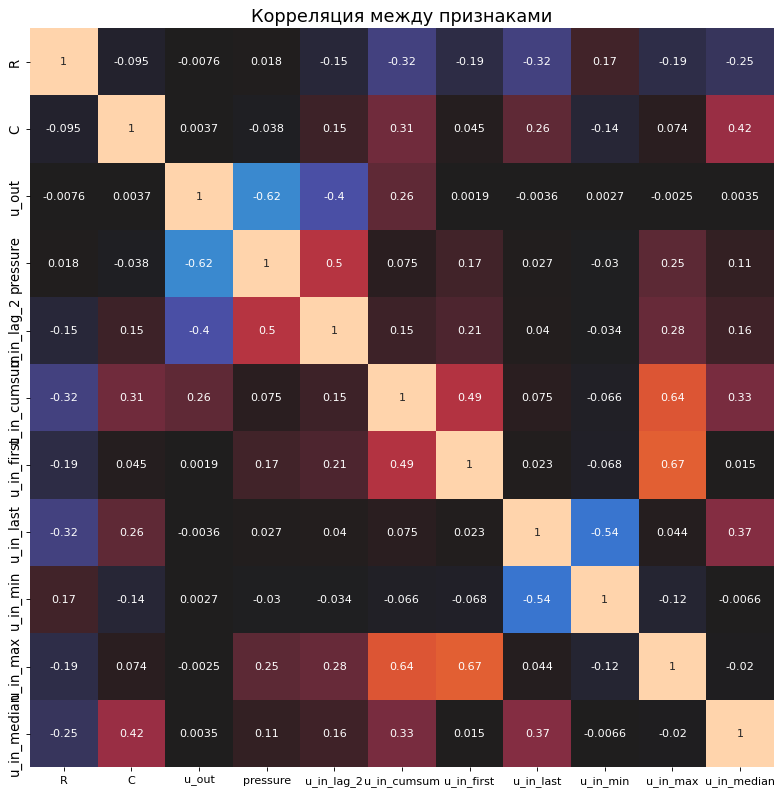

In [144]:
show_correlogram(train_linear)

### Подготовим данные для линейных моделей. Несколько коррелирующих признаков были удалены для борьбы с мультиколлинеарностью.

In [145]:
y_train_linear = train_linear[[TARGET_NAME]]
X_train_linear = train_linear.drop([TARGET_NAME], axis=1)
X_train_linear.head()

,R,C,u_out,u_in_lag_2,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,20,50,0,0.000000,0.083334,0.083334,4.987079,0.0,28.313036,4.922568
1,20,50,0,0.000000,18.466375,0.083334,4.987079,0.0,28.313036,4.922568
2,20,50,0,0.083334,40.975653,0.083334,4.987079,0.0,28.313036,4.922568
3,20,50,0,18.383041,63.784476,0.083334,4.987079,0.0,28.313036,4.922568
4,20,50,0,22.509278,89.140326,0.083334,4.987079,0.0,28.313036,4.922568


In [146]:
# Приведем данные трейна для линейных моделей к одной шкале.

scaler_linear = StandardScaler()
X_train_linear = scaler_linear.fit_transform(X_train_linear)
print(X_train_linear.shape)

(6030000, 10)


In [147]:
# Приведем данные теста для линейных моделей к одной шкале.

test_linear = scaler_linear.transform(test_linear)
print(test_linear.shape)

(4024000, 10)


### Подготовим данные для не линейных моделей, где потребуется приведение к одной шкале.

In [148]:
train_data = train.drop(["id"], axis=1)
test_data = test.drop(["id"], axis=1)
y_train = train_data[[TARGET_NAME]]
X_train = train_data.drop([TARGET_NAME], axis=1)
X_train.head()

,R,C,time_step,u_in,u_out,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,20,50,0.000000,0.083334,0,0.000000,0.000000,18.383041,22.509278,0.083334,0.083334,4.987079,0.0,28.313036,4.922568
1,20,50,0.033652,18.383041,0,0.083334,0.000000,22.509278,22.808822,18.466375,0.083334,4.987079,0.0,28.313036,4.922568
2,20,50,0.067514,22.509278,0,18.383041,0.083334,22.808822,25.355850,40.975653,0.083334,4.987079,0.0,28.313036,4.922568
3,20,50,0.101542,22.808822,0,22.509278,18.383041,25.355850,27.259866,63.784476,0.083334,4.987079,0.0,28.313036,4.922568
4,20,50,0.135756,25.355850,0,22.808822,22.509278,27.259866,27.127486,89.140326,0.083334,4.987079,0.0,28.313036,4.922568


In [149]:
test_data.head()

,R,C,time_step,u_in,u_out,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,5,20,0.000000,0.000000,0,0.000000,0.000000,7.515046,14.651675,0.000000,0.0,4.973375,0.0,37.542219,4.683875
1,5,20,0.031904,7.515046,0,0.000000,0.000000,14.651675,21.230610,7.515046,0.0,4.973375,0.0,37.542219,4.683875
2,5,20,0.063827,14.651675,0,7.515046,0.000000,21.230610,26.320956,22.166721,0.0,4.973375,0.0,37.542219,4.683875
3,5,20,0.095751,21.230610,0,14.651675,7.515046,26.320956,30.486938,43.397331,0.0,4.973375,0.0,37.542219,4.683875
4,5,20,0.127644,26.320956,0,21.230610,14.651675,30.486938,33.545950,69.718287,0.0,4.973375,0.0,37.542219,4.683875


In [150]:
# Приведем данные трейна к одной шкале.

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print(X_train.shape)

(6030000, 15)


In [151]:
# Приведем данные теста к одной шкале.

test_data = scaler.transform(test_data)
print(test_data.shape)

(4024000, 15)


### Подготовим данные для не линейных моделей, где не потребуется приведение к одной шкале. Например случайный лес или градиентный бустинг.

In [152]:
train_forest = train.drop(["id"], axis=1)
test_forest = test.drop(["id"], axis=1)
y_train_forest = train_forest[[TARGET_NAME]]
X_train_forest = train_forest.drop([TARGET_NAME], axis=1)
X_train_forest.head()

,R,C,time_step,u_in,u_out,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,20,50,0.000000,0.083334,0,0.000000,0.000000,18.383041,22.509278,0.083334,0.083334,4.987079,0.0,28.313036,4.922568
1,20,50,0.033652,18.383041,0,0.083334,0.000000,22.509278,22.808822,18.466375,0.083334,4.987079,0.0,28.313036,4.922568
2,20,50,0.067514,22.509278,0,18.383041,0.083334,22.808822,25.355850,40.975653,0.083334,4.987079,0.0,28.313036,4.922568
3,20,50,0.101542,22.808822,0,22.509278,18.383041,25.355850,27.259866,63.784476,0.083334,4.987079,0.0,28.313036,4.922568
4,20,50,0.135756,25.355850,0,22.808822,22.509278,27.259866,27.127486,89.140326,0.083334,4.987079,0.0,28.313036,4.922568


In [153]:
test_forest.head()

,R,C,time_step,u_in,u_out,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,5,20,0.000000,0.000000,0,0.000000,0.000000,7.515046,14.651675,0.000000,0.0,4.973375,0.0,37.542219,4.683875
1,5,20,0.031904,7.515046,0,0.000000,0.000000,14.651675,21.230610,7.515046,0.0,4.973375,0.0,37.542219,4.683875
2,5,20,0.063827,14.651675,0,7.515046,0.000000,21.230610,26.320956,22.166721,0.0,4.973375,0.0,37.542219,4.683875
3,5,20,0.095751,21.230610,0,14.651675,7.515046,26.320956,30.486938,43.397331,0.0,4.973375,0.0,37.542219,4.683875
4,5,20,0.127644,26.320956,0,21.230610,14.651675,30.486938,33.545950,69.718287,0.0,4.973375,0.0,37.542219,4.683875


### Начнем с более простых моделей, потом перейдём к более сложным. Сначала будем учить модели с дефолтными параметрами. Потом для некоторых моделей будем искать лучшие параметры через GridSearch и RandomSearch.

#### Так как у нас набор последовательностей, то обычная кросс валидация в GridSearch не есть хорошо. Нам придется использовать TimeSeriesSplit.

In [154]:
tscv = TimeSeriesSplit(n_splits=N_FOLDS)

#### 1. LinearRegression

In [155]:
%%time

linear_regression = LinearRegression()

linear_regression.fit(X_train_linear, y_train_linear)

make_log("train", "LinearRegression", linear_regression, None)

CPU times: total: 6.55 s
Wall time: 4.85 s


In [156]:
%%time

y_pred_regression = linear_regression.predict(test_linear)

make_log("predict", "LinearRegression", linear_regression, y_pred_regression)

make_submission_file(y_pred_regression, 'submission_linreg.csv')

CPU times: total: 6.14 s
Wall time: 5.21 s


Посмотрим какой скор будет после сабмита.

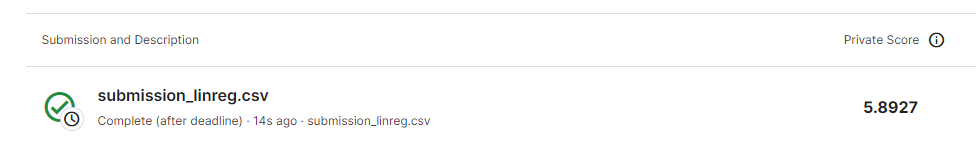

#### 2. Lasso

In [157]:
%%time

lasso = Lasso(random_state=RANDOM_STATE)

lasso.fit(X_train_linear, y_train_linear)

make_log("train", "Lasso", lasso, None)

CPU times: total: 3.17 s
Wall time: 1.08 s


In [158]:
%%time

y_pred_lasso = lasso.predict(test_linear)

make_log("predict", "Lasso", lasso, y_pred_lasso)

make_submission_file(y_pred_lasso, 'submission_lasso.csv')

CPU times: total: 5.98 s
Wall time: 4.95 s


Посмотрим какой скор будет после сабмита.

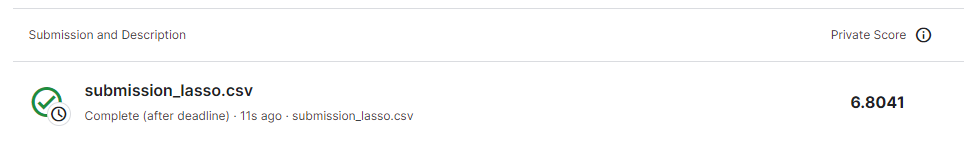

In [159]:
%%time

n_alphas_lasso = 200
alphas_lasso = {'alpha': list(np.linspace(0.1, 10, n_alphas_lasso))}

lasso_gridsearch = GridSearchCV(lasso, alphas_lasso, scoring='neg_mean_absolute_error', cv=tscv, verbose=3)
lasso_gridsearch.fit(X_train_linear, y_train_linear)

make_log("gridsearch", "Lasso GridSearch", lasso_gridsearch, None)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END ........................alpha=0.1;, score=-3.763 total time=   0.3s
[CV 2/5] END ........................alpha=0.1;, score=-3.803 total time=   0.7s
[CV 3/5] END ........................alpha=0.1;, score=-3.765 total time=   1.1s
[CV 4/5] END ........................alpha=0.1;, score=-3.738 total time=   1.5s
[CV 5/5] END ........................alpha=0.1;, score=-3.756 total time=   1.9s
[CV 1/5] END ........alpha=0.14974874371859298;, score=-3.741 total time=   0.2s
[CV 2/5] END ........alpha=0.14974874371859298;, score=-3.781 total time=   0.6s
[CV 3/5] END ........alpha=0.14974874371859298;, score=-3.740 total time=   1.1s
[CV 4/5] END ........alpha=0.14974874371859298;, score=-3.715 total time=   1.5s
[CV 5/5] END ........alpha=0.14974874371859298;, score=-3.731 total time=   1.9s
[CV 1/5] END ........alpha=0.19949748743718593;, score=-3.723 total time=   0.2s
[CV 2/5] END ........alpha=0.1994974874371859

[CV 2/5] END .........alpha=1.0949748743718595;, score=-4.041 total time=   0.3s
[CV 3/5] END .........alpha=1.0949748743718595;, score=-4.002 total time=   0.5s
[CV 4/5] END .........alpha=1.0949748743718595;, score=-3.972 total time=   0.7s
[CV 5/5] END .........alpha=1.0949748743718595;, score=-3.991 total time=   0.9s
[CV 1/5] END .........alpha=1.1447236180904523;, score=-4.033 total time=   0.1s
[CV 2/5] END .........alpha=1.1447236180904523;, score=-4.067 total time=   0.3s
[CV 3/5] END .........alpha=1.1447236180904523;, score=-4.028 total time=   0.6s
[CV 4/5] END .........alpha=1.1447236180904523;, score=-3.998 total time=   0.8s
[CV 5/5] END .........alpha=1.1447236180904523;, score=-4.017 total time=   0.9s
[CV 1/5] END .........alpha=1.1944723618090454;, score=-4.059 total time=   0.1s
[CV 2/5] END .........alpha=1.1944723618090454;, score=-4.093 total time=   0.3s
[CV 3/5] END .........alpha=1.1944723618090454;, score=-4.054 total time=   0.6s
[CV 4/5] END .........alpha=

[CV 4/5] END ..........alpha=2.089949748743719;, score=-4.505 total time=   0.7s
[CV 5/5] END ..........alpha=2.089949748743719;, score=-4.524 total time=   0.9s
[CV 1/5] END ..........alpha=2.139698492462312;, score=-4.556 total time=   0.2s
[CV 2/5] END ..........alpha=2.139698492462312;, score=-4.596 total time=   0.3s
[CV 3/5] END ..........alpha=2.139698492462312;, score=-4.559 total time=   0.6s
[CV 4/5] END ..........alpha=2.139698492462312;, score=-4.531 total time=   0.7s
[CV 5/5] END ..........alpha=2.139698492462312;, score=-4.549 total time=   0.9s
[CV 1/5] END .........alpha=2.1894472361809045;, score=-4.582 total time=   0.1s
[CV 2/5] END .........alpha=2.1894472361809045;, score=-4.622 total time=   0.3s
[CV 3/5] END .........alpha=2.1894472361809045;, score=-4.584 total time=   0.5s
[CV 4/5] END .........alpha=2.1894472361809045;, score=-4.557 total time=   0.7s
[CV 5/5] END .........alpha=2.1894472361809045;, score=-4.576 total time=   1.0s
[CV 1/5] END .........alpha=

[CV 1/5] END .........alpha=3.1346733668341713;, score=-5.123 total time=   0.1s
[CV 2/5] END .........alpha=3.1346733668341713;, score=-5.173 total time=   0.4s
[CV 3/5] END .........alpha=3.1346733668341713;, score=-5.125 total time=   0.6s
[CV 4/5] END .........alpha=3.1346733668341713;, score=-5.102 total time=   0.7s
[CV 5/5] END .........alpha=3.1346733668341713;, score=-5.123 total time=   0.9s
[CV 1/5] END ..........alpha=3.184422110552764;, score=-5.154 total time=   0.2s
[CV 2/5] END ..........alpha=3.184422110552764;, score=-5.204 total time=   0.4s
[CV 3/5] END ..........alpha=3.184422110552764;, score=-5.156 total time=   0.5s
[CV 4/5] END ..........alpha=3.184422110552764;, score=-5.133 total time=   0.8s
[CV 5/5] END ..........alpha=3.184422110552764;, score=-5.154 total time=   0.9s
[CV 1/5] END ..........alpha=3.234170854271357;, score=-5.186 total time=   0.2s
[CV 2/5] END ..........alpha=3.234170854271357;, score=-5.236 total time=   0.3s
[CV 3/5] END ..........alpha

[CV 3/5] END ...........alpha=4.12964824120603;, score=-5.683 total time=   0.4s
[CV 4/5] END ...........alpha=4.12964824120603;, score=-5.664 total time=   0.6s
[CV 5/5] END ...........alpha=4.12964824120603;, score=-5.684 total time=   0.7s
[CV 1/5] END ..........alpha=4.179396984924623;, score=-5.719 total time=   0.1s
[CV 2/5] END ..........alpha=4.179396984924623;, score=-5.772 total time=   0.2s
[CV 3/5] END ..........alpha=4.179396984924623;, score=-5.710 total time=   0.4s
[CV 4/5] END ..........alpha=4.179396984924623;, score=-5.691 total time=   0.6s
[CV 5/5] END ..........alpha=4.179396984924623;, score=-5.712 total time=   0.8s
[CV 1/5] END ..........alpha=4.229145728643216;, score=-5.747 total time=   0.1s
[CV 2/5] END ..........alpha=4.229145728643216;, score=-5.800 total time=   0.3s
[CV 3/5] END ..........alpha=4.229145728643216;, score=-5.738 total time=   0.4s
[CV 4/5] END ..........alpha=4.229145728643216;, score=-5.719 total time=   0.6s
[CV 5/5] END ..........alpha

[CV 5/5] END ..........alpha=5.124623115577889;, score=-6.186 total time=   0.7s
[CV 1/5] END ..........alpha=5.174371859296483;, score=-6.203 total time=   0.1s
[CV 2/5] END ..........alpha=5.174371859296483;, score=-6.254 total time=   0.3s
[CV 3/5] END ..........alpha=5.174371859296483;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha=5.174371859296483;, score=-6.171 total time=   0.6s
[CV 5/5] END ..........alpha=5.174371859296483;, score=-6.186 total time=   0.7s
[CV 1/5] END ..........alpha=5.224120603015075;, score=-6.203 total time=   0.1s
[CV 2/5] END ..........alpha=5.224120603015075;, score=-6.254 total time=   0.3s
[CV 3/5] END ..........alpha=5.224120603015075;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha=5.224120603015075;, score=-6.171 total time=   0.5s
[CV 5/5] END ..........alpha=5.224120603015075;, score=-6.186 total time=   0.7s
[CV 1/5] END ..........alpha=5.273869346733668;, score=-6.203 total time=   0.1s
[CV 2/5] END ..........alpha

[CV 2/5] END ..........alpha=6.169346733668342;, score=-6.254 total time=   0.3s
[CV 3/5] END ..........alpha=6.169346733668342;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha=6.169346733668342;, score=-6.171 total time=   0.5s
[CV 5/5] END ..........alpha=6.169346733668342;, score=-6.186 total time=   0.7s
[CV 1/5] END ..........alpha=6.219095477386935;, score=-6.203 total time=   0.1s
[CV 2/5] END ..........alpha=6.219095477386935;, score=-6.254 total time=   0.3s
[CV 3/5] END ..........alpha=6.219095477386935;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha=6.219095477386935;, score=-6.171 total time=   0.5s
[CV 5/5] END ..........alpha=6.219095477386935;, score=-6.186 total time=   0.7s
[CV 1/5] END ..........alpha=6.268844221105527;, score=-6.203 total time=   0.1s
[CV 2/5] END ..........alpha=6.268844221105527;, score=-6.254 total time=   0.3s
[CV 3/5] END ..........alpha=6.268844221105527;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha

[CV 4/5] END .........alpha=7.1643216080402015;, score=-6.171 total time=   0.5s
[CV 5/5] END .........alpha=7.1643216080402015;, score=-6.186 total time=   0.7s
[CV 1/5] END ..........alpha=7.214070351758794;, score=-6.203 total time=   0.1s
[CV 2/5] END ..........alpha=7.214070351758794;, score=-6.254 total time=   0.2s
[CV 3/5] END ..........alpha=7.214070351758794;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha=7.214070351758794;, score=-6.171 total time=   0.5s
[CV 5/5] END ..........alpha=7.214070351758794;, score=-6.186 total time=   0.7s
[CV 1/5] END ..........alpha=7.263819095477387;, score=-6.203 total time=   0.1s
[CV 2/5] END ..........alpha=7.263819095477387;, score=-6.254 total time=   0.2s
[CV 3/5] END ..........alpha=7.263819095477387;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha=7.263819095477387;, score=-6.171 total time=   0.5s
[CV 5/5] END ..........alpha=7.263819095477387;, score=-6.186 total time=   0.7s
[CV 1/5] END ...........alph

[CV 2/5] END ..........alpha=8.209045226130653;, score=-6.254 total time=   0.3s
[CV 3/5] END ..........alpha=8.209045226130653;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha=8.209045226130653;, score=-6.171 total time=   0.5s
[CV 5/5] END ..........alpha=8.209045226130653;, score=-6.186 total time=   0.7s
[CV 1/5] END ..........alpha=8.258793969849247;, score=-6.203 total time=   0.1s
[CV 2/5] END ..........alpha=8.258793969849247;, score=-6.254 total time=   0.2s
[CV 3/5] END ..........alpha=8.258793969849247;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha=8.258793969849247;, score=-6.171 total time=   0.5s
[CV 5/5] END ..........alpha=8.258793969849247;, score=-6.186 total time=   0.6s
[CV 1/5] END ..........alpha=8.308542713567839;, score=-6.203 total time=   0.1s
[CV 2/5] END ..........alpha=8.308542713567839;, score=-6.254 total time=   0.2s
[CV 3/5] END ..........alpha=8.308542713567839;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha

[CV 4/5] END ..........alpha=9.204020100502513;, score=-6.171 total time=   0.5s
[CV 5/5] END ..........alpha=9.204020100502513;, score=-6.186 total time=   0.7s
[CV 1/5] END ..........alpha=9.253768844221106;, score=-6.203 total time=   0.1s
[CV 2/5] END ..........alpha=9.253768844221106;, score=-6.254 total time=   0.2s
[CV 3/5] END ..........alpha=9.253768844221106;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha=9.253768844221106;, score=-6.171 total time=   0.5s
[CV 5/5] END ..........alpha=9.253768844221106;, score=-6.186 total time=   0.6s
[CV 1/5] END ..........alpha=9.303517587939698;, score=-6.203 total time=   0.1s
[CV 2/5] END ..........alpha=9.303517587939698;, score=-6.254 total time=   0.2s
[CV 3/5] END ..........alpha=9.303517587939698;, score=-6.196 total time=   0.4s
[CV 4/5] END ..........alpha=9.303517587939698;, score=-6.171 total time=   0.5s
[CV 5/5] END ..........alpha=9.303517587939698;, score=-6.186 total time=   0.6s
[CV 1/5] END ..........alpha

In [160]:
print("Лучшее значение параметра : ", lasso_gridsearch.best_params_)
print("Лучший скор: ", lasso_gridsearch.best_score_)

Лучшее значение параметра :  {'alpha': 0.39849246231155777}
Лучший скор:  -3.67864148679019


In [161]:
%%time

y_pred_lasso_gs = lasso_gridsearch.predict(test_linear)

make_log("predict", "Lasso GridSearch", lasso_gridsearch, y_pred_lasso_gs)

make_submission_file(y_pred_lasso_gs, 'submission_lasso_gridsearch.csv')

CPU times: total: 6.08 s
Wall time: 5 s


Посмотрим какой скор будет после сабмита.

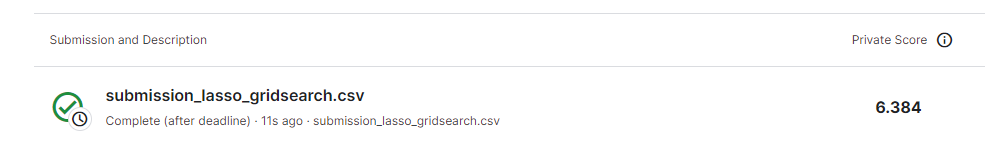

#### 3. Ridge

In [162]:
%%time

ridge = Ridge(random_state=RANDOM_STATE)

ridge.fit(X_train_linear, y_train_linear)

make_log("train", "Ridge", ridge, None)

CPU times: total: 1.38 s
Wall time: 556 ms


In [163]:
%%time

y_pred_ridge = ridge.predict(test_linear)

make_log("predict", "Ridge", ridge, y_pred_ridge)

make_submission_file(y_pred_ridge, 'submission_ridge.csv')

CPU times: total: 6.03 s
Wall time: 5 s


Посмотрим какой скор будет после сабмита.

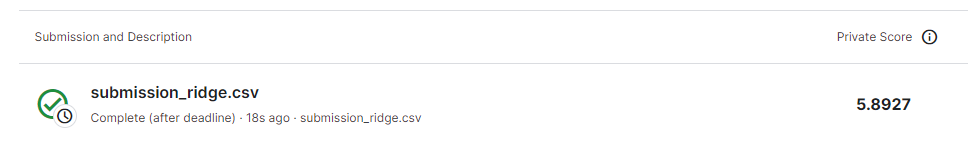

In [164]:
%%time

n_alphas_ridge = 200
alphas_ridge = {'alpha': list(np.linspace(0.1, 10, n_alphas_ridge))} 

ridge_gridsearch = GridSearchCV(ridge, alphas_ridge, scoring='neg_mean_absolute_error', cv=tscv, verbose=3)
ridge_gridsearch.fit(X_train_linear, y_train_linear)

make_log("gridsearch", "Ridge GridSearch", ridge_gridsearch, None)

print("Лучшее значение параметра : ", ridge_gridsearch.best_params_)
print("Лучший скор: ", ridge_gridsearch.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END ........................alpha=0.1;, score=-3.822 total time=   0.0s
[CV 2/5] END ........................alpha=0.1;, score=-3.860 total time=   0.2s
[CV 3/5] END ........................alpha=0.1;, score=-3.827 total time=   0.3s
[CV 4/5] END ........................alpha=0.1;, score=-3.799 total time=   0.4s
[CV 5/5] END ........................alpha=0.1;, score=-3.819 total time=   0.5s
[CV 1/5] END ........alpha=0.14974874371859298;, score=-3.822 total time=   0.1s
[CV 2/5] END ........alpha=0.14974874371859298;, score=-3.860 total time=   0.2s
[CV 3/5] END ........alpha=0.14974874371859298;, score=-3.827 total time=   0.3s
[CV 4/5] END ........alpha=0.14974874371859298;, score=-3.799 total time=   0.4s
[CV 5/5] END ........alpha=0.14974874371859298;, score=-3.819 total time=   0.5s
[CV 1/5] END ........alpha=0.19949748743718593;, score=-3.822 total time=   0.1s
[CV 2/5] END ........alpha=0.1994974874371859

[CV 2/5] END .........alpha=1.0949748743718595;, score=-3.860 total time=   0.2s
[CV 3/5] END .........alpha=1.0949748743718595;, score=-3.827 total time=   0.2s
[CV 4/5] END .........alpha=1.0949748743718595;, score=-3.799 total time=   0.4s
[CV 5/5] END .........alpha=1.0949748743718595;, score=-3.819 total time=   0.4s
[CV 1/5] END .........alpha=1.1447236180904523;, score=-3.822 total time=   0.1s
[CV 2/5] END .........alpha=1.1447236180904523;, score=-3.860 total time=   0.2s
[CV 3/5] END .........alpha=1.1447236180904523;, score=-3.827 total time=   0.3s
[CV 4/5] END .........alpha=1.1447236180904523;, score=-3.799 total time=   0.4s
[CV 5/5] END .........alpha=1.1447236180904523;, score=-3.819 total time=   0.5s
[CV 1/5] END .........alpha=1.1944723618090454;, score=-3.822 total time=   0.1s
[CV 2/5] END .........alpha=1.1944723618090454;, score=-3.860 total time=   0.2s
[CV 3/5] END .........alpha=1.1944723618090454;, score=-3.827 total time=   0.3s
[CV 4/5] END .........alpha=

[CV 4/5] END ..........alpha=2.089949748743719;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=2.089949748743719;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=2.139698492462312;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=2.139698492462312;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=2.139698492462312;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=2.139698492462312;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=2.139698492462312;, score=-3.819 total time=   0.5s
[CV 1/5] END .........alpha=2.1894472361809045;, score=-3.822 total time=   0.1s
[CV 2/5] END .........alpha=2.1894472361809045;, score=-3.860 total time=   0.2s
[CV 3/5] END .........alpha=2.1894472361809045;, score=-3.827 total time=   0.3s
[CV 4/5] END .........alpha=2.1894472361809045;, score=-3.799 total time=   0.4s
[CV 5/5] END .........alpha=2.1894472361809045;, score=-3.819 total time=   0.5s
[CV 1/5] END .........alpha=

[CV 2/5] END .........alpha=3.1346733668341713;, score=-3.860 total time=   0.2s
[CV 3/5] END .........alpha=3.1346733668341713;, score=-3.827 total time=   0.3s
[CV 4/5] END .........alpha=3.1346733668341713;, score=-3.799 total time=   0.4s
[CV 5/5] END .........alpha=3.1346733668341713;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=3.184422110552764;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=3.184422110552764;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=3.184422110552764;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=3.184422110552764;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=3.184422110552764;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=3.234170854271357;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=3.234170854271357;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=3.234170854271357;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha

[CV 4/5] END ...........alpha=4.12964824120603;, score=-3.799 total time=   0.4s
[CV 5/5] END ...........alpha=4.12964824120603;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=4.179396984924623;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=4.179396984924623;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=4.179396984924623;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=4.179396984924623;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=4.179396984924623;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=4.229145728643216;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=4.229145728643216;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=4.229145728643216;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=4.229145728643216;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=4.229145728643216;, score=-3.819 total time=   0.5s
[CV 1/5] END .........alpha=

[CV 2/5] END ..........alpha=5.174371859296483;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=5.174371859296483;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=5.174371859296483;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=5.174371859296483;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=5.224120603015075;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=5.224120603015075;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=5.224120603015075;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=5.224120603015075;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=5.224120603015075;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=5.273869346733668;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=5.273869346733668;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=5.273869346733668;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha

[CV 4/5] END ..........alpha=6.169346733668342;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=6.169346733668342;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=6.219095477386935;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=6.219095477386935;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=6.219095477386935;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=6.219095477386935;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=6.219095477386935;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=6.268844221105527;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=6.268844221105527;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=6.268844221105527;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=6.268844221105527;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=6.268844221105527;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha

[CV 2/5] END ..........alpha=7.214070351758794;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=7.214070351758794;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=7.214070351758794;, score=-3.799 total time=   0.3s
[CV 5/5] END ..........alpha=7.214070351758794;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=7.263819095477387;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=7.263819095477387;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=7.263819095477387;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=7.263819095477387;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=7.263819095477387;, score=-3.819 total time=   0.4s
[CV 1/5] END ...........alpha=7.31356783919598;, score=-3.822 total time=   0.1s
[CV 2/5] END ...........alpha=7.31356783919598;, score=-3.860 total time=   0.2s
[CV 3/5] END ...........alpha=7.31356783919598;, score=-3.827 total time=   0.3s
[CV 4/5] END ...........alph

[CV 4/5] END ..........alpha=8.209045226130653;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=8.209045226130653;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=8.258793969849247;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=8.258793969849247;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=8.258793969849247;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=8.258793969849247;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=8.258793969849247;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=8.308542713567839;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=8.308542713567839;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=8.308542713567839;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=8.308542713567839;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=8.308542713567839;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha

[CV 2/5] END ..........alpha=9.253768844221106;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=9.253768844221106;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=9.253768844221106;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=9.253768844221106;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=9.303517587939698;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=9.303517587939698;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=9.303517587939698;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha=9.303517587939698;, score=-3.799 total time=   0.4s
[CV 5/5] END ..........alpha=9.303517587939698;, score=-3.819 total time=   0.5s
[CV 1/5] END ..........alpha=9.353266331658292;, score=-3.822 total time=   0.1s
[CV 2/5] END ..........alpha=9.353266331658292;, score=-3.860 total time=   0.2s
[CV 3/5] END ..........alpha=9.353266331658292;, score=-3.827 total time=   0.3s
[CV 4/5] END ..........alpha

In [165]:
%%time

y_pred_ridge_gs = ridge_gridsearch.predict(test_linear)

make_log("predict", "Ridge GridSearch", ridge_gridsearch, y_pred_ridge_gs)

make_submission_file(y_pred_ridge_gs, 'submission_ridge_gridsearch.csv')

CPU times: total: 6.06 s
Wall time: 5 s


Посмотрим какой скор будет после сабмита.

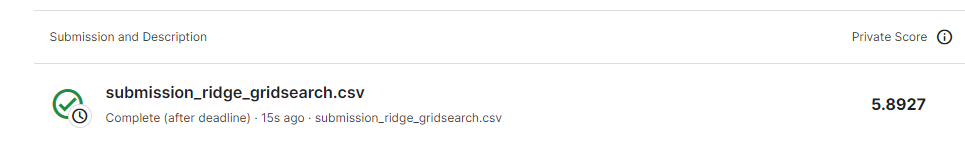

#### 4. ElasticNet

In [166]:
%%time

elasticnet = ElasticNet(random_state=RANDOM_STATE)

elasticnet.fit(X_train_linear, y_train_linear)

make_log("train", "ElasticNet", elasticnet, None)

CPU times: total: 4.62 s
Wall time: 1.11 s


In [167]:
%%time

y_pred_elasticnet = elasticnet.predict(test_linear)

make_log("predict", "ElasticNet", elasticnet, y_pred_elasticnet)

make_submission_file(y_pred_elasticnet, 'submission_elasticnet.csv')

CPU times: total: 6.05 s
Wall time: 4.97 s


Посмотрим какой скор будет после сабмита.

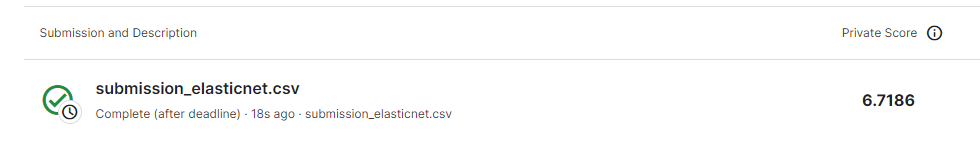

In [168]:
%%time

n_alphas_elasticnet = 200
alphas_elasticnet = {'alpha': list(np.linspace(0.1, 10, n_alphas_elasticnet))} 

elasticnet_gridsearch = GridSearchCV(elasticnet, alphas_elasticnet,
                                     scoring='neg_mean_absolute_error', n_jobs=2, cv=tscv, verbose=3)
elasticnet_gridsearch.fit(X_train_linear, y_train_linear)

make_log("gridsearch", "ElasticNet GridSearch", elasticnet_gridsearch, None)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: total: 10.3 s
Wall time: 8min 21s


In [169]:
print("Лучшее значение параметра : ", elasticnet_gridsearch.best_params_)
print("Лучший скор: ", elasticnet_gridsearch.best_score_)

Лучшее значение параметра :  {'alpha': 0.2492462311557789}
Лучший скор:  -3.7434475598508783


In [170]:
%%time

y_pred_elasticnet_gs = elasticnet_gridsearch.predict(test_linear)

make_log("predict", "ElasticNet GridSearch", elasticnet_gridsearch, y_pred_elasticnet_gs)

make_submission_file(y_pred_elasticnet_gs, 'submission_elasticnet_gridsearch.csv')

CPU times: total: 6.06 s
Wall time: 4.97 s


Посмотрим какой скор будет после сабмита.

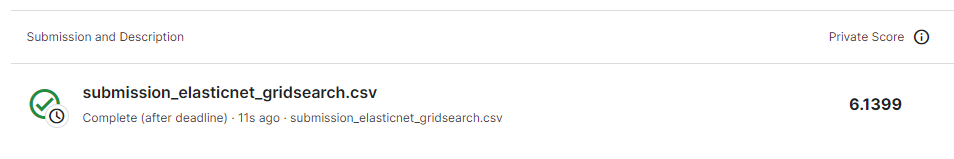

#### 5. LinearSVR

In [171]:
%%time

linearsvr = LinearSVR(random_state=RANDOM_STATE, dual="auto")

linearsvr.fit(X_train, np.array(y_train[TARGET_NAME]))

make_log("train", "LinearSVR", linearsvr, None)

CPU times: total: 9min 32s
Wall time: 9min 33s


In [172]:
%%time

y_pred_linearsvr = linearsvr.predict(test_data)

make_log("predict", "LinearSVR", linearsvr, y_pred_linearsvr)

make_submission_file(y_pred_linearsvr, 'submission_linearsvr.csv')

CPU times: total: 6.39 s
Wall time: 5.29 s


Посмотрим какой скор будет после сабмита.

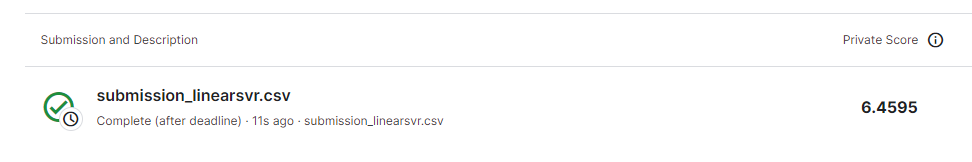

#### 6. KNeighborsRegressor

In [173]:
%%time

k_neigh_regressor = KNeighborsRegressor()

k_neigh_regressor.fit(X_train, y_train)

make_log("train", "KNeighborsRegressor", k_neigh_regressor, None)

CPU times: total: 36.5 s
Wall time: 36.6 s


In [174]:
%%time

y_pred_knregressor = k_neigh_regressor.predict(test_data)

make_log("predict", "KNeighborsRegressor", k_neigh_regressor, y_pred_knregressor)

make_submission_file(y_pred_knregressor, 'submission_knregressor.csv')

CPU times: total: 1h 10min 58s
Wall time: 1h 11min 2s


Посмотрим какой скор будет после сабмита.

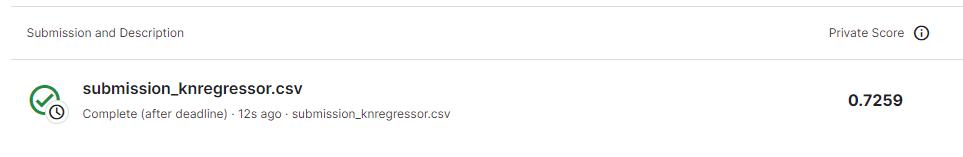

### Теперь перейдём к более сложным моделям. К градиентным бустингам.

#### 7. LightGBMRegressor

In [175]:
%%time

lightgbm_regressor = lgb.LGBMRegressor(objective ='regression', metric = 'mae', random_state=RANDOM_STATE)

lightgbm_regressor.fit(X_train_forest, y_train_forest)

make_log("train", "LGBMRegressor", lightgbm_regressor, None)

CPU times: total: 59.5 s
Wall time: 16.8 s


In [176]:
%%time

y_pred_lgbmregressor = lightgbm_regressor.predict(test_forest)

make_log("predict", "LGBMRegressor", lightgbm_regressor, y_pred_lgbmregressor)

make_submission_file(y_pred_lgbmregressor, 'submission_lgbmregressor.csv')

CPU times: total: 21.7 s
Wall time: 10.5 s


Посмотрим какой скор будет после сабмита.

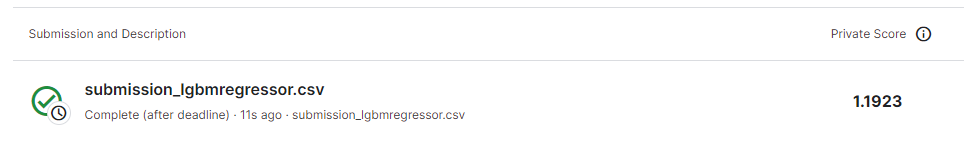

In [177]:
%%time

n_reg_alpha = 10
n_reg_lambda = 15

params_lgbmregressor = {"num_leaves": [5, 10, 15, 20, 25, 30, 35, 40],
                        "n_estimators": [50, 100, 150, 200],
                        "reg_alpha": list(np.linspace(0.0, 3, n_reg_alpha)),
                        "reg_lambda": list(np.linspace(0.0, 3, n_reg_lambda))} 

lgbmregressor_randomsearch = RandomizedSearchCV(lightgbm_regressor, params_lgbmregressor, n_iter=30,
                                                scoring='neg_mean_absolute_error', cv=tscv,
                                                verbose=3, random_state=RANDOM_STATE)

lgbmregressor_randomsearch.fit(X_train_forest, y_train_forest)

make_log("randomsearch", "LGBMRegressor RandomSearch", lgbmregressor_randomsearch, None)

print("Лучшее значение параметра : ", lgbmregressor_randomsearch.best_params_)
print("Лучший скор: ", lgbmregressor_randomsearch.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END n_estimators=50, num_leaves=30, reg_alpha=2.333333333333333, reg_lambda=1.0714285714285714;, score=-0.884 total time=   2.6s
[CV 2/5] END n_estimators=50, num_leaves=30, reg_alpha=2.333333333333333, reg_lambda=1.0714285714285714;, score=-0.887 total time=   4.2s
[CV 3/5] END n_estimators=50, num_leaves=30, reg_alpha=2.333333333333333, reg_lambda=1.0714285714285714;, score=-0.884 total time=   5.9s
[CV 4/5] END n_estimators=50, num_leaves=30, reg_alpha=2.333333333333333, reg_lambda=1.0714285714285714;, score=-0.875 total time=   7.4s
[CV 5/5] END n_estimators=50, num_leaves=30, reg_alpha=2.333333333333333, reg_lambda=1.0714285714285714;, score=-0.879 total time=   9.4s
[CV 1/5] END n_estimators=200, num_leaves=10, reg_alpha=0.3333333333333333, reg_lambda=1.5;, score=-0.901 total time=   4.8s
[CV 2/5] END n_estimators=200, num_leaves=10, reg_alpha=0.3333333333333333, reg_lambda=1.5;, score=-0.899 total time=   8.5

[CV 2/5] END n_estimators=150, num_leaves=5, reg_alpha=0.6666666666666666, reg_lambda=0.6428571428571428;, score=-1.197 total time=   6.3s
[CV 3/5] END n_estimators=150, num_leaves=5, reg_alpha=0.6666666666666666, reg_lambda=0.6428571428571428;, score=-1.183 total time=   8.4s
[CV 4/5] END n_estimators=150, num_leaves=5, reg_alpha=0.6666666666666666, reg_lambda=0.6428571428571428;, score=-1.186 total time=  10.8s
[CV 5/5] END n_estimators=150, num_leaves=5, reg_alpha=0.6666666666666666, reg_lambda=0.6428571428571428;, score=-1.191 total time=  14.3s
[CV 1/5] END n_estimators=50, num_leaves=40, reg_alpha=2.6666666666666665, reg_lambda=3.0;, score=-0.824 total time=   2.8s
[CV 2/5] END n_estimators=50, num_leaves=40, reg_alpha=2.6666666666666665, reg_lambda=3.0;, score=-0.827 total time=   4.6s
[CV 3/5] END n_estimators=50, num_leaves=40, reg_alpha=2.6666666666666665, reg_lambda=3.0;, score=-0.825 total time=   6.7s
[CV 4/5] END n_estimators=50, num_leaves=40, reg_alpha=2.666666666666666

[CV 2/5] END n_estimators=50, num_leaves=10, reg_alpha=0.6666666666666666, reg_lambda=1.9285714285714284;, score=-1.216 total time=   3.3s
[CV 3/5] END n_estimators=50, num_leaves=10, reg_alpha=0.6666666666666666, reg_lambda=1.9285714285714284;, score=-1.209 total time=   4.9s
[CV 4/5] END n_estimators=50, num_leaves=10, reg_alpha=0.6666666666666666, reg_lambda=1.9285714285714284;, score=-1.198 total time=   6.3s
[CV 5/5] END n_estimators=50, num_leaves=10, reg_alpha=0.6666666666666666, reg_lambda=1.9285714285714284;, score=-1.200 total time=   7.7s
[CV 1/5] END n_estimators=150, num_leaves=15, reg_alpha=0.6666666666666666, reg_lambda=0.8571428571428571;, score=-0.838 total time=   4.4s
[CV 2/5] END n_estimators=150, num_leaves=15, reg_alpha=0.6666666666666666, reg_lambda=0.8571428571428571;, score=-0.846 total time=   7.4s
[CV 3/5] END n_estimators=150, num_leaves=15, reg_alpha=0.6666666666666666, reg_lambda=0.8571428571428571;, score=-0.842 total time=  11.2s
[CV 4/5] END n_estimator

In [178]:
%%time

y_pred_lgbmregressor_rs = lgbmregressor_randomsearch.predict(test_forest)

make_log("predict", "LGBMRegressor RandomSearch", lgbmregressor_randomsearch, y_pred_lgbmregressor_rs)

make_submission_file(y_pred_lgbmregressor_rs, 'submission_lgbmregressor_randomsearch.csv')

CPU times: total: 34.2 s
Wall time: 13.3 s


Посмотрим какой скор будет после сабмита.

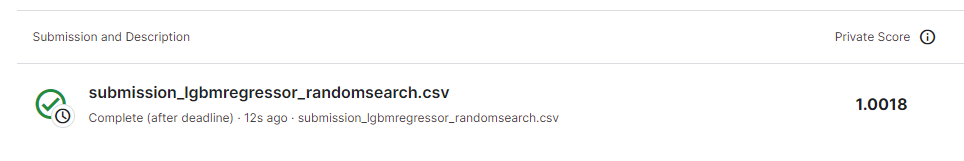

#### 8. CatBoostRegressor

In [179]:
%%time

catboost_regressor = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='MAE')

catboost_regressor.fit(X_train_forest, y_train_forest)

make_log("train", "CatBoostRegressor", catboost_regressor, None)

0:	learn: 4.9629099	total: 613ms	remaining: 10m 11s
1:	learn: 4.8490863	total: 1.04s	remaining: 8m 40s
2:	learn: 4.7436236	total: 1.45s	remaining: 8m 3s
3:	learn: 4.6419140	total: 1.87s	remaining: 7m 45s
4:	learn: 4.5417322	total: 2.28s	remaining: 7m 33s
5:	learn: 4.4435493	total: 2.67s	remaining: 7m 21s
6:	learn: 4.3443499	total: 3.07s	remaining: 7m 15s
7:	learn: 4.2402747	total: 3.49s	remaining: 7m 12s
8:	learn: 4.1385629	total: 3.9s	remaining: 7m 9s
9:	learn: 4.0479669	total: 4.28s	remaining: 7m 3s
10:	learn: 3.9649228	total: 4.66s	remaining: 6m 58s
11:	learn: 3.8807364	total: 5.04s	remaining: 6m 55s
12:	learn: 3.7923621	total: 5.46s	remaining: 6m 54s
13:	learn: 3.7102970	total: 5.83s	remaining: 6m 50s
14:	learn: 3.6298847	total: 6.21s	remaining: 6m 47s
15:	learn: 3.5494025	total: 6.59s	remaining: 6m 45s
16:	learn: 3.4742944	total: 6.99s	remaining: 6m 44s
17:	learn: 3.4033275	total: 7.38s	remaining: 6m 42s
18:	learn: 3.3351838	total: 7.77s	remaining: 6m 41s
19:	learn: 3.2679038	tota

158:	learn: 1.2144029	total: 1m 4s	remaining: 5m 41s
159:	learn: 1.2129215	total: 1m 4s	remaining: 5m 40s
160:	learn: 1.2115007	total: 1m 5s	remaining: 5m 40s
161:	learn: 1.2085170	total: 1m 5s	remaining: 5m 40s
162:	learn: 1.2063847	total: 1m 6s	remaining: 5m 39s
163:	learn: 1.2052781	total: 1m 6s	remaining: 5m 39s
164:	learn: 1.2045429	total: 1m 6s	remaining: 5m 39s
165:	learn: 1.2036256	total: 1m 7s	remaining: 5m 38s
166:	learn: 1.2028626	total: 1m 7s	remaining: 5m 38s
167:	learn: 1.2001267	total: 1m 8s	remaining: 5m 37s
168:	learn: 1.1968483	total: 1m 8s	remaining: 5m 37s
169:	learn: 1.1942419	total: 1m 9s	remaining: 5m 36s
170:	learn: 1.1932467	total: 1m 9s	remaining: 5m 36s
171:	learn: 1.1903603	total: 1m 9s	remaining: 5m 35s
172:	learn: 1.1883337	total: 1m 10s	remaining: 5m 35s
173:	learn: 1.1869771	total: 1m 10s	remaining: 5m 35s
174:	learn: 1.1844817	total: 1m 11s	remaining: 5m 34s
175:	learn: 1.1819876	total: 1m 11s	remaining: 5m 34s
176:	learn: 1.1792378	total: 1m 11s	remain

311:	learn: 1.0013383	total: 2m 6s	remaining: 4m 39s
312:	learn: 1.0005759	total: 2m 6s	remaining: 4m 38s
313:	learn: 1.0002305	total: 2m 7s	remaining: 4m 38s
314:	learn: 0.9986875	total: 2m 7s	remaining: 4m 37s
315:	learn: 0.9982766	total: 2m 8s	remaining: 4m 37s
316:	learn: 0.9970530	total: 2m 8s	remaining: 4m 36s
317:	learn: 0.9968036	total: 2m 8s	remaining: 4m 36s
318:	learn: 0.9964112	total: 2m 9s	remaining: 4m 36s
319:	learn: 0.9961340	total: 2m 9s	remaining: 4m 35s
320:	learn: 0.9951872	total: 2m 10s	remaining: 4m 35s
321:	learn: 0.9945227	total: 2m 10s	remaining: 4m 34s
322:	learn: 0.9928548	total: 2m 11s	remaining: 4m 34s
323:	learn: 0.9925523	total: 2m 11s	remaining: 4m 34s
324:	learn: 0.9919588	total: 2m 11s	remaining: 4m 33s
325:	learn: 0.9907634	total: 2m 12s	remaining: 4m 33s
326:	learn: 0.9901431	total: 2m 12s	remaining: 4m 32s
327:	learn: 0.9891457	total: 2m 12s	remaining: 4m 32s
328:	learn: 0.9885998	total: 2m 13s	remaining: 4m 31s
329:	learn: 0.9880459	total: 2m 13s	r

464:	learn: 0.9069308	total: 3m 8s	remaining: 3m 36s
465:	learn: 0.9063382	total: 3m 8s	remaining: 3m 35s
466:	learn: 0.9053668	total: 3m 8s	remaining: 3m 35s
467:	learn: 0.9051059	total: 3m 9s	remaining: 3m 35s
468:	learn: 0.9048539	total: 3m 9s	remaining: 3m 34s
469:	learn: 0.9045015	total: 3m 10s	remaining: 3m 34s
470:	learn: 0.9034514	total: 3m 10s	remaining: 3m 34s
471:	learn: 0.9024767	total: 3m 10s	remaining: 3m 33s
472:	learn: 0.9022477	total: 3m 11s	remaining: 3m 33s
473:	learn: 0.9018987	total: 3m 11s	remaining: 3m 32s
474:	learn: 0.9011823	total: 3m 12s	remaining: 3m 32s
475:	learn: 0.9008876	total: 3m 12s	remaining: 3m 31s
476:	learn: 0.9006613	total: 3m 12s	remaining: 3m 31s
477:	learn: 0.9003288	total: 3m 13s	remaining: 3m 31s
478:	learn: 0.8994525	total: 3m 13s	remaining: 3m 30s
479:	learn: 0.8991105	total: 3m 14s	remaining: 3m 30s
480:	learn: 0.8989250	total: 3m 14s	remaining: 3m 29s
481:	learn: 0.8985013	total: 3m 14s	remaining: 3m 29s
482:	learn: 0.8982875	total: 3m 1

617:	learn: 0.8434080	total: 4m 9s	remaining: 2m 34s
618:	learn: 0.8425801	total: 4m 10s	remaining: 2m 33s
619:	learn: 0.8424280	total: 4m 10s	remaining: 2m 33s
620:	learn: 0.8420576	total: 4m 10s	remaining: 2m 33s
621:	learn: 0.8416286	total: 4m 11s	remaining: 2m 32s
622:	learn: 0.8411815	total: 4m 11s	remaining: 2m 32s
623:	learn: 0.8406439	total: 4m 12s	remaining: 2m 31s
624:	learn: 0.8403426	total: 4m 12s	remaining: 2m 31s
625:	learn: 0.8399564	total: 4m 12s	remaining: 2m 31s
626:	learn: 0.8398559	total: 4m 13s	remaining: 2m 30s
627:	learn: 0.8391143	total: 4m 13s	remaining: 2m 30s
628:	learn: 0.8388239	total: 4m 14s	remaining: 2m 29s
629:	learn: 0.8380641	total: 4m 14s	remaining: 2m 29s
630:	learn: 0.8379354	total: 4m 14s	remaining: 2m 29s
631:	learn: 0.8375276	total: 4m 15s	remaining: 2m 28s
632:	learn: 0.8370288	total: 4m 15s	remaining: 2m 28s
633:	learn: 0.8369085	total: 4m 16s	remaining: 2m 27s
634:	learn: 0.8364896	total: 4m 16s	remaining: 2m 27s
635:	learn: 0.8362081	total: 

770:	learn: 0.7957690	total: 5m 11s	remaining: 1m 32s
771:	learn: 0.7956159	total: 5m 11s	remaining: 1m 32s
772:	learn: 0.7951126	total: 5m 12s	remaining: 1m 31s
773:	learn: 0.7947681	total: 5m 12s	remaining: 1m 31s
774:	learn: 0.7945280	total: 5m 12s	remaining: 1m 30s
775:	learn: 0.7943108	total: 5m 13s	remaining: 1m 30s
776:	learn: 0.7941006	total: 5m 13s	remaining: 1m 30s
777:	learn: 0.7939813	total: 5m 14s	remaining: 1m 29s
778:	learn: 0.7936930	total: 5m 14s	remaining: 1m 29s
779:	learn: 0.7934316	total: 5m 14s	remaining: 1m 28s
780:	learn: 0.7931562	total: 5m 15s	remaining: 1m 28s
781:	learn: 0.7927525	total: 5m 15s	remaining: 1m 28s
782:	learn: 0.7925355	total: 5m 16s	remaining: 1m 27s
783:	learn: 0.7922668	total: 5m 16s	remaining: 1m 27s
784:	learn: 0.7920774	total: 5m 16s	remaining: 1m 26s
785:	learn: 0.7918204	total: 5m 17s	remaining: 1m 26s
786:	learn: 0.7917179	total: 5m 17s	remaining: 1m 25s
787:	learn: 0.7910311	total: 5m 18s	remaining: 1m 25s
788:	learn: 0.7908600	total:

925:	learn: 0.7555892	total: 6m 13s	remaining: 29.9s
926:	learn: 0.7553742	total: 6m 14s	remaining: 29.5s
927:	learn: 0.7552593	total: 6m 14s	remaining: 29s
928:	learn: 0.7551180	total: 6m 14s	remaining: 28.6s
929:	learn: 0.7549783	total: 6m 15s	remaining: 28.2s
930:	learn: 0.7547139	total: 6m 15s	remaining: 27.8s
931:	learn: 0.7543813	total: 6m 16s	remaining: 27.4s
932:	learn: 0.7543312	total: 6m 16s	remaining: 27s
933:	learn: 0.7537985	total: 6m 16s	remaining: 26.6s
934:	learn: 0.7536921	total: 6m 17s	remaining: 26.2s
935:	learn: 0.7535149	total: 6m 17s	remaining: 25.8s
936:	learn: 0.7534764	total: 6m 18s	remaining: 25.4s
937:	learn: 0.7532198	total: 6m 18s	remaining: 25s
938:	learn: 0.7530762	total: 6m 18s	remaining: 24.6s
939:	learn: 0.7528150	total: 6m 19s	remaining: 24.2s
940:	learn: 0.7526555	total: 6m 19s	remaining: 23.8s
941:	learn: 0.7526181	total: 6m 20s	remaining: 23.4s
942:	learn: 0.7524180	total: 6m 20s	remaining: 23s
943:	learn: 0.7522596	total: 6m 20s	remaining: 22.6s
9

In [180]:
%%time

y_pred_cbregressor = catboost_regressor.predict(test_forest)

make_log("predict", "CatBoostRegressor", catboost_regressor, y_pred_cbregressor)

make_submission_file(y_pred_cbregressor, 'submission_cbregressor.csv')

CPU times: total: 13.6 s
Wall time: 8.91 s


Посмотрим какой скор будет после сабмита.

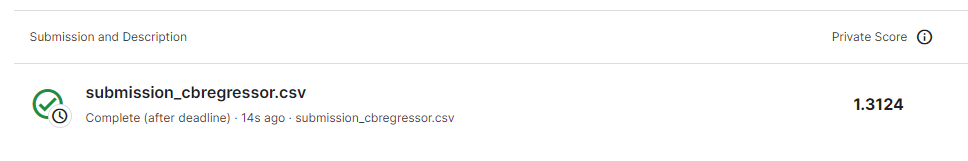

In [203]:
%%time

params_cbregressor = {'learning_rate': [0.02, 0.03, 0.04, 0.05, 0.06, 0.09, 0.12, 0.15, 0.18],
                        "l2_leaf_reg": [5, 6, 7, 8, 9, 10, 11, 12],
                        "n_estimators": [300, 350, 400, 450, 500, 550, 600, 650],
                        "depth": [6, 7, 8, 9, 10, 11, 12, 13]} 

cbregressor_randomsearch = RandomizedSearchCV(catboost_regressor, params_cbregressor, n_iter=10,
                                              scoring='neg_mean_absolute_error', cv=tscv,
                                              verbose=3, random_state=RANDOM_STATE)

cbregressor_randomsearch.fit(X_train_forest, y_train_forest)

make_log("randomsearch", "CatBoostRegressor RandomSearch", cbregressor_randomsearch, None)

print("Лучшее значение параметра : ", cbregressor_randomsearch.best_params_)
print("Лучший скор: ", cbregressor_randomsearch.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 4.4124801	total: 108ms	remaining: 53.8s
1:	learn: 3.8744499	total: 180ms	remaining: 44.9s
2:	learn: 3.3527854	total: 250ms	remaining: 41.5s
3:	learn: 2.9534133	total: 318ms	remaining: 39.4s
4:	learn: 2.5825462	total: 393ms	remaining: 38.9s
5:	learn: 2.2957732	total: 464ms	remaining: 38.2s
6:	learn: 2.0686649	total: 535ms	remaining: 37.7s
7:	learn: 1.9081640	total: 616ms	remaining: 37.9s
8:	learn: 1.7927242	total: 689ms	remaining: 37.6s
9:	learn: 1.6834031	total: 760ms	remaining: 37.2s
10:	learn: 1.5737617	total: 830ms	remaining: 36.9s
11:	learn: 1.4921996	total: 902ms	remaining: 36.7s
12:	learn: 1.4344232	total: 974ms	remaining: 36.5s
13:	learn: 1.3789964	total: 1.05s	remaining: 36.4s
14:	learn: 1.3317259	total: 1.12s	remaining: 36.3s
15:	learn: 1.3009950	total: 1.19s	remaining: 36.1s
16:	learn: 1.2747105	total: 1.26s	remaining: 35.9s
17:	learn: 1.2434535	total: 1.34s	remaining: 35.8s
18:	learn: 1.2250883	total: 1.4

160:	learn: 0.7176057	total: 11.5s	remaining: 24.2s
161:	learn: 0.7166577	total: 11.6s	remaining: 24.2s
162:	learn: 0.7163822	total: 11.7s	remaining: 24.1s
163:	learn: 0.7153316	total: 11.7s	remaining: 24s
164:	learn: 0.7129429	total: 11.8s	remaining: 24s
165:	learn: 0.7123207	total: 11.9s	remaining: 23.9s
166:	learn: 0.7118615	total: 11.9s	remaining: 23.8s
167:	learn: 0.7116072	total: 12s	remaining: 23.7s
168:	learn: 0.7100714	total: 12.1s	remaining: 23.7s
169:	learn: 0.7083118	total: 12.2s	remaining: 23.6s
170:	learn: 0.7067110	total: 12.2s	remaining: 23.5s
171:	learn: 0.7061650	total: 12.3s	remaining: 23.5s
172:	learn: 0.7050710	total: 12.4s	remaining: 23.4s
173:	learn: 0.7046947	total: 12.5s	remaining: 23.3s
174:	learn: 0.7043975	total: 12.5s	remaining: 23.3s
175:	learn: 0.7035827	total: 12.6s	remaining: 23.2s
176:	learn: 0.7027398	total: 12.7s	remaining: 23.1s
177:	learn: 0.7017475	total: 12.7s	remaining: 23s
178:	learn: 0.7011531	total: 12.8s	remaining: 23s
179:	learn: 0.6995252	

321:	learn: 0.6235928	total: 23.2s	remaining: 12.8s
322:	learn: 0.6233147	total: 23.3s	remaining: 12.8s
323:	learn: 0.6230217	total: 23.4s	remaining: 12.7s
324:	learn: 0.6227198	total: 23.4s	remaining: 12.6s
325:	learn: 0.6223611	total: 23.5s	remaining: 12.5s
326:	learn: 0.6217754	total: 23.6s	remaining: 12.5s
327:	learn: 0.6215347	total: 23.6s	remaining: 12.4s
328:	learn: 0.6213285	total: 23.7s	remaining: 12.3s
329:	learn: 0.6208238	total: 23.8s	remaining: 12.3s
330:	learn: 0.6204915	total: 23.9s	remaining: 12.2s
331:	learn: 0.6196858	total: 23.9s	remaining: 12.1s
332:	learn: 0.6193025	total: 24s	remaining: 12s
333:	learn: 0.6190076	total: 24.1s	remaining: 12s
334:	learn: 0.6188277	total: 24.1s	remaining: 11.9s
335:	learn: 0.6183059	total: 24.2s	remaining: 11.8s
336:	learn: 0.6179561	total: 24.3s	remaining: 11.7s
337:	learn: 0.6174947	total: 24.4s	remaining: 11.7s
338:	learn: 0.6173596	total: 24.4s	remaining: 11.6s
339:	learn: 0.6169747	total: 24.5s	remaining: 11.5s
340:	learn: 0.6167

481:	learn: 0.5814242	total: 34.7s	remaining: 1.3s
482:	learn: 0.5813418	total: 34.8s	remaining: 1.22s
483:	learn: 0.5812136	total: 34.9s	remaining: 1.15s
484:	learn: 0.5810854	total: 35s	remaining: 1.08s
485:	learn: 0.5806101	total: 35s	remaining: 1.01s
486:	learn: 0.5804845	total: 35.1s	remaining: 937ms
487:	learn: 0.5801847	total: 35.2s	remaining: 865ms
488:	learn: 0.5799101	total: 35.3s	remaining: 793ms
489:	learn: 0.5797295	total: 35.3s	remaining: 721ms
490:	learn: 0.5796394	total: 35.4s	remaining: 649ms
491:	learn: 0.5788876	total: 35.5s	remaining: 577ms
492:	learn: 0.5785783	total: 35.5s	remaining: 505ms
493:	learn: 0.5784625	total: 35.6s	remaining: 433ms
494:	learn: 0.5782395	total: 35.7s	remaining: 361ms
495:	learn: 0.5780520	total: 35.8s	remaining: 288ms
496:	learn: 0.5779185	total: 35.8s	remaining: 216ms
497:	learn: 0.5776230	total: 35.9s	remaining: 144ms
498:	learn: 0.5774477	total: 36s	remaining: 72.1ms
499:	learn: 0.5773166	total: 36s	remaining: 0us
[CV 1/5] END depth=7, 

140:	learn: 0.7372009	total: 19.9s	remaining: 50.7s
141:	learn: 0.7367097	total: 20.1s	remaining: 50.6s
142:	learn: 0.7358240	total: 20.2s	remaining: 50.5s
143:	learn: 0.7346990	total: 20.4s	remaining: 50.3s
144:	learn: 0.7335363	total: 20.5s	remaining: 50.2s
145:	learn: 0.7329813	total: 20.6s	remaining: 50s
146:	learn: 0.7314088	total: 20.8s	remaining: 49.9s
147:	learn: 0.7311970	total: 20.9s	remaining: 49.7s
148:	learn: 0.7298388	total: 21.1s	remaining: 49.6s
149:	learn: 0.7287157	total: 21.2s	remaining: 49.5s
150:	learn: 0.7279575	total: 21.3s	remaining: 49.3s
151:	learn: 0.7276327	total: 21.5s	remaining: 49.2s
152:	learn: 0.7262151	total: 21.6s	remaining: 49.1s
153:	learn: 0.7256612	total: 21.8s	remaining: 49s
154:	learn: 0.7241980	total: 21.9s	remaining: 48.8s
155:	learn: 0.7222159	total: 22.1s	remaining: 48.7s
156:	learn: 0.7209892	total: 22.2s	remaining: 48.6s
157:	learn: 0.7201294	total: 22.4s	remaining: 48.4s
158:	learn: 0.7194238	total: 22.5s	remaining: 48.3s
159:	learn: 0.71

300:	learn: 0.6362090	total: 42.9s	remaining: 28.4s
301:	learn: 0.6356901	total: 43.1s	remaining: 28.2s
302:	learn: 0.6355102	total: 43.2s	remaining: 28.1s
303:	learn: 0.6351602	total: 43.4s	remaining: 28s
304:	learn: 0.6343087	total: 43.5s	remaining: 27.8s
305:	learn: 0.6339314	total: 43.7s	remaining: 27.7s
306:	learn: 0.6333011	total: 43.8s	remaining: 27.5s
307:	learn: 0.6329436	total: 44s	remaining: 27.4s
308:	learn: 0.6326578	total: 44.1s	remaining: 27.3s
309:	learn: 0.6325341	total: 44.3s	remaining: 27.1s
310:	learn: 0.6318747	total: 44.4s	remaining: 27s
311:	learn: 0.6316742	total: 44.6s	remaining: 26.8s
312:	learn: 0.6313526	total: 44.7s	remaining: 26.7s
313:	learn: 0.6310831	total: 44.8s	remaining: 26.6s
314:	learn: 0.6308028	total: 45s	remaining: 26.4s
315:	learn: 0.6303657	total: 45.1s	remaining: 26.3s
316:	learn: 0.6300962	total: 45.3s	remaining: 26.1s
317:	learn: 0.6298782	total: 45.4s	remaining: 26s
318:	learn: 0.6296406	total: 45.6s	remaining: 25.9s
319:	learn: 0.6291647	

460:	learn: 0.5870523	total: 1m 6s	remaining: 5.59s
461:	learn: 0.5868584	total: 1m 6s	remaining: 5.45s
462:	learn: 0.5865918	total: 1m 6s	remaining: 5.31s
463:	learn: 0.5864213	total: 1m 6s	remaining: 5.16s
464:	learn: 0.5863503	total: 1m 6s	remaining: 5.02s
465:	learn: 0.5861142	total: 1m 6s	remaining: 4.88s
466:	learn: 0.5859754	total: 1m 6s	remaining: 4.73s
467:	learn: 0.5855074	total: 1m 7s	remaining: 4.59s
468:	learn: 0.5853267	total: 1m 7s	remaining: 4.44s
469:	learn: 0.5850156	total: 1m 7s	remaining: 4.3s
470:	learn: 0.5847350	total: 1m 7s	remaining: 4.16s
471:	learn: 0.5842737	total: 1m 7s	remaining: 4.01s
472:	learn: 0.5841103	total: 1m 7s	remaining: 3.87s
473:	learn: 0.5840044	total: 1m 7s	remaining: 3.73s
474:	learn: 0.5838775	total: 1m 8s	remaining: 3.58s
475:	learn: 0.5836387	total: 1m 8s	remaining: 3.44s
476:	learn: 0.5833242	total: 1m 8s	remaining: 3.3s
477:	learn: 0.5830897	total: 1m 8s	remaining: 3.15s
478:	learn: 0.5828641	total: 1m 8s	remaining: 3.01s
479:	learn: 0.

116:	learn: 0.7734984	total: 24.9s	remaining: 1m 21s
117:	learn: 0.7720092	total: 25.1s	remaining: 1m 21s
118:	learn: 0.7711546	total: 25.3s	remaining: 1m 21s
119:	learn: 0.7706649	total: 25.5s	remaining: 1m 20s
120:	learn: 0.7675043	total: 25.7s	remaining: 1m 20s
121:	learn: 0.7666329	total: 26s	remaining: 1m 20s
122:	learn: 0.7645156	total: 26.2s	remaining: 1m 20s
123:	learn: 0.7641218	total: 26.4s	remaining: 1m 19s
124:	learn: 0.7632261	total: 26.6s	remaining: 1m 19s
125:	learn: 0.7619713	total: 26.8s	remaining: 1m 19s
126:	learn: 0.7615266	total: 27s	remaining: 1m 19s
127:	learn: 0.7591064	total: 27.3s	remaining: 1m 19s
128:	learn: 0.7584764	total: 27.5s	remaining: 1m 19s
129:	learn: 0.7572023	total: 27.7s	remaining: 1m 18s
130:	learn: 0.7556659	total: 27.9s	remaining: 1m 18s
131:	learn: 0.7534697	total: 28.1s	remaining: 1m 18s
132:	learn: 0.7515451	total: 28.3s	remaining: 1m 18s
133:	learn: 0.7495291	total: 28.5s	remaining: 1m 17s
134:	learn: 0.7480137	total: 28.7s	remaining: 1m 1

274:	learn: 0.6475980	total: 58.9s	remaining: 48.2s
275:	learn: 0.6470587	total: 59.1s	remaining: 48s
276:	learn: 0.6467839	total: 59.4s	remaining: 47.8s
277:	learn: 0.6464192	total: 59.6s	remaining: 47.6s
278:	learn: 0.6459523	total: 59.8s	remaining: 47.4s
279:	learn: 0.6458213	total: 60s	remaining: 47.1s
280:	learn: 0.6453280	total: 1m	remaining: 46.9s
281:	learn: 0.6448626	total: 1m	remaining: 46.7s
282:	learn: 0.6445622	total: 1m	remaining: 46.5s
283:	learn: 0.6438771	total: 1m	remaining: 46.3s
284:	learn: 0.6435284	total: 1m 1s	remaining: 46.1s
285:	learn: 0.6430398	total: 1m 1s	remaining: 45.9s
286:	learn: 0.6424500	total: 1m 1s	remaining: 45.6s
287:	learn: 0.6421363	total: 1m 1s	remaining: 45.4s
288:	learn: 0.6415742	total: 1m 1s	remaining: 45.2s
289:	learn: 0.6413046	total: 1m 2s	remaining: 45s
290:	learn: 0.6406639	total: 1m 2s	remaining: 44.8s
291:	learn: 0.6404736	total: 1m 2s	remaining: 44.6s
292:	learn: 0.6402519	total: 1m 2s	remaining: 44.4s
293:	learn: 0.6393990	total: 1

431:	learn: 0.5985178	total: 1m 32s	remaining: 14.6s
432:	learn: 0.5980893	total: 1m 33s	remaining: 14.4s
433:	learn: 0.5978560	total: 1m 33s	remaining: 14.2s
434:	learn: 0.5977152	total: 1m 33s	remaining: 14s
435:	learn: 0.5976141	total: 1m 33s	remaining: 13.8s
436:	learn: 0.5973762	total: 1m 34s	remaining: 13.6s
437:	learn: 0.5969772	total: 1m 34s	remaining: 13.3s
438:	learn: 0.5966361	total: 1m 34s	remaining: 13.1s
439:	learn: 0.5963034	total: 1m 34s	remaining: 12.9s
440:	learn: 0.5959662	total: 1m 34s	remaining: 12.7s
441:	learn: 0.5954083	total: 1m 35s	remaining: 12.5s
442:	learn: 0.5952987	total: 1m 35s	remaining: 12.3s
443:	learn: 0.5950079	total: 1m 35s	remaining: 12s
444:	learn: 0.5947553	total: 1m 35s	remaining: 11.8s
445:	learn: 0.5945819	total: 1m 35s	remaining: 11.6s
446:	learn: 0.5944927	total: 1m 36s	remaining: 11.4s
447:	learn: 0.5942730	total: 1m 36s	remaining: 11.2s
448:	learn: 0.5941933	total: 1m 36s	remaining: 11s
449:	learn: 0.5937980	total: 1m 36s	remaining: 10.8s

87:	learn: 0.8277291	total: 24.9s	remaining: 1m 56s
88:	learn: 0.8251147	total: 25.2s	remaining: 1m 56s
89:	learn: 0.8235267	total: 25.5s	remaining: 1m 56s
90:	learn: 0.8204068	total: 25.8s	remaining: 1m 55s
91:	learn: 0.8189205	total: 26.1s	remaining: 1m 55s
92:	learn: 0.8174127	total: 26.4s	remaining: 1m 55s
93:	learn: 0.8157996	total: 26.6s	remaining: 1m 55s
94:	learn: 0.8144328	total: 26.9s	remaining: 1m 54s
95:	learn: 0.8134365	total: 27.2s	remaining: 1m 54s
96:	learn: 0.8122978	total: 27.5s	remaining: 1m 54s
97:	learn: 0.8110403	total: 27.8s	remaining: 1m 53s
98:	learn: 0.8077970	total: 28s	remaining: 1m 53s
99:	learn: 0.8069295	total: 28.3s	remaining: 1m 53s
100:	learn: 0.8059691	total: 28.6s	remaining: 1m 52s
101:	learn: 0.8042509	total: 28.9s	remaining: 1m 52s
102:	learn: 0.8032562	total: 29.2s	remaining: 1m 52s
103:	learn: 0.7997035	total: 29.4s	remaining: 1m 52s
104:	learn: 0.7981088	total: 29.7s	remaining: 1m 51s
105:	learn: 0.7953425	total: 30s	remaining: 1m 51s
106:	learn

243:	learn: 0.6643349	total: 1m 9s	remaining: 1m 12s
244:	learn: 0.6641012	total: 1m 9s	remaining: 1m 12s
245:	learn: 0.6637635	total: 1m 10s	remaining: 1m 12s
246:	learn: 0.6634986	total: 1m 10s	remaining: 1m 12s
247:	learn: 0.6628054	total: 1m 10s	remaining: 1m 11s
248:	learn: 0.6621790	total: 1m 11s	remaining: 1m 11s
249:	learn: 0.6620676	total: 1m 11s	remaining: 1m 11s
250:	learn: 0.6614611	total: 1m 11s	remaining: 1m 11s
251:	learn: 0.6613255	total: 1m 11s	remaining: 1m 10s
252:	learn: 0.6607257	total: 1m 12s	remaining: 1m 10s
253:	learn: 0.6602897	total: 1m 12s	remaining: 1m 10s
254:	learn: 0.6595675	total: 1m 12s	remaining: 1m 9s
255:	learn: 0.6588116	total: 1m 13s	remaining: 1m 9s
256:	learn: 0.6584578	total: 1m 13s	remaining: 1m 9s
257:	learn: 0.6574109	total: 1m 13s	remaining: 1m 9s
258:	learn: 0.6569424	total: 1m 13s	remaining: 1m 8s
259:	learn: 0.6567333	total: 1m 14s	remaining: 1m 8s
260:	learn: 0.6562468	total: 1m 14s	remaining: 1m 8s
261:	learn: 0.6554469	total: 1m 14s	r

398:	learn: 0.6046703	total: 1m 54s	remaining: 28.9s
399:	learn: 0.6044495	total: 1m 54s	remaining: 28.7s
400:	learn: 0.6041925	total: 1m 54s	remaining: 28.4s
401:	learn: 0.6039450	total: 1m 55s	remaining: 28.1s
402:	learn: 0.6037287	total: 1m 55s	remaining: 27.8s
403:	learn: 0.6035584	total: 1m 55s	remaining: 27.5s
404:	learn: 0.6034306	total: 1m 56s	remaining: 27.3s
405:	learn: 0.6030857	total: 1m 56s	remaining: 27s
406:	learn: 0.6029076	total: 1m 56s	remaining: 26.7s
407:	learn: 0.6026458	total: 1m 57s	remaining: 26.4s
408:	learn: 0.6025261	total: 1m 57s	remaining: 26.1s
409:	learn: 0.6023155	total: 1m 57s	remaining: 25.8s
410:	learn: 0.6020768	total: 1m 57s	remaining: 25.5s
411:	learn: 0.6016231	total: 1m 58s	remaining: 25.3s
412:	learn: 0.6015332	total: 1m 58s	remaining: 25s
413:	learn: 0.6011570	total: 1m 58s	remaining: 24.7s
414:	learn: 0.6010401	total: 1m 59s	remaining: 24.4s
415:	learn: 0.6009655	total: 1m 59s	remaining: 24.1s
416:	learn: 0.6007115	total: 1m 59s	remaining: 23.

54:	learn: 0.9291029	total: 19.7s	remaining: 2m 39s
55:	learn: 0.9248020	total: 20.1s	remaining: 2m 39s
56:	learn: 0.9182320	total: 20.5s	remaining: 2m 38s
57:	learn: 0.9108845	total: 20.8s	remaining: 2m 38s
58:	learn: 0.9073751	total: 21.2s	remaining: 2m 38s
59:	learn: 0.9044675	total: 21.5s	remaining: 2m 37s
60:	learn: 0.9029386	total: 21.9s	remaining: 2m 37s
61:	learn: 0.8983577	total: 22.3s	remaining: 2m 37s
62:	learn: 0.8966665	total: 22.6s	remaining: 2m 37s
63:	learn: 0.8942096	total: 23s	remaining: 2m 36s
64:	learn: 0.8904922	total: 23.3s	remaining: 2m 36s
65:	learn: 0.8892157	total: 23.7s	remaining: 2m 35s
66:	learn: 0.8827848	total: 24s	remaining: 2m 35s
67:	learn: 0.8775316	total: 24.4s	remaining: 2m 34s
68:	learn: 0.8764268	total: 24.7s	remaining: 2m 34s
69:	learn: 0.8741316	total: 25.1s	remaining: 2m 33s
70:	learn: 0.8725563	total: 25.4s	remaining: 2m 33s
71:	learn: 0.8693999	total: 25.7s	remaining: 2m 32s
72:	learn: 0.8670010	total: 26.1s	remaining: 2m 32s
73:	learn: 0.864

211:	learn: 0.6789288	total: 1m 15s	remaining: 1m 42s
212:	learn: 0.6784644	total: 1m 15s	remaining: 1m 41s
213:	learn: 0.6779645	total: 1m 15s	remaining: 1m 41s
214:	learn: 0.6775226	total: 1m 16s	remaining: 1m 41s
215:	learn: 0.6769884	total: 1m 16s	remaining: 1m 40s
216:	learn: 0.6755000	total: 1m 17s	remaining: 1m 40s
217:	learn: 0.6751380	total: 1m 17s	remaining: 1m 40s
218:	learn: 0.6746087	total: 1m 17s	remaining: 1m 39s
219:	learn: 0.6736440	total: 1m 18s	remaining: 1m 39s
220:	learn: 0.6722472	total: 1m 18s	remaining: 1m 39s
221:	learn: 0.6719562	total: 1m 18s	remaining: 1m 38s
222:	learn: 0.6716867	total: 1m 19s	remaining: 1m 38s
223:	learn: 0.6712822	total: 1m 19s	remaining: 1m 37s
224:	learn: 0.6710918	total: 1m 19s	remaining: 1m 37s
225:	learn: 0.6707416	total: 1m 20s	remaining: 1m 37s
226:	learn: 0.6698778	total: 1m 20s	remaining: 1m 36s
227:	learn: 0.6695448	total: 1m 20s	remaining: 1m 36s
228:	learn: 0.6682876	total: 1m 21s	remaining: 1m 36s
229:	learn: 0.6678468	total:

365:	learn: 0.6118656	total: 2m 10s	remaining: 47.8s
366:	learn: 0.6113641	total: 2m 10s	remaining: 47.4s
367:	learn: 0.6108686	total: 2m 11s	remaining: 47.1s
368:	learn: 0.6103258	total: 2m 11s	remaining: 46.7s
369:	learn: 0.6101242	total: 2m 11s	remaining: 46.3s
370:	learn: 0.6098212	total: 2m 12s	remaining: 46s
371:	learn: 0.6096551	total: 2m 12s	remaining: 45.7s
372:	learn: 0.6092437	total: 2m 13s	remaining: 45.3s
373:	learn: 0.6090941	total: 2m 13s	remaining: 44.9s
374:	learn: 0.6088705	total: 2m 13s	remaining: 44.6s
375:	learn: 0.6087175	total: 2m 14s	remaining: 44.2s
376:	learn: 0.6082748	total: 2m 14s	remaining: 43.9s
377:	learn: 0.6081104	total: 2m 14s	remaining: 43.5s
378:	learn: 0.6076733	total: 2m 15s	remaining: 43.1s
379:	learn: 0.6072928	total: 2m 15s	remaining: 42.8s
380:	learn: 0.6071155	total: 2m 15s	remaining: 42.4s
381:	learn: 0.6068974	total: 2m 16s	remaining: 42.1s
382:	learn: 0.6066326	total: 2m 16s	remaining: 41.7s
383:	learn: 0.6065151	total: 2m 16s	remaining: 4

20:	learn: 2.1154086	total: 3.68s	remaining: 1m 23s
21:	learn: 2.0437874	total: 3.89s	remaining: 1m 24s
22:	learn: 1.9738597	total: 4.06s	remaining: 1m 24s
23:	learn: 1.9076891	total: 4.22s	remaining: 1m 23s
24:	learn: 1.8466792	total: 4.39s	remaining: 1m 23s
25:	learn: 1.7893644	total: 4.55s	remaining: 1m 23s
26:	learn: 1.7341586	total: 4.72s	remaining: 1m 22s
27:	learn: 1.6837296	total: 4.92s	remaining: 1m 22s
28:	learn: 1.6358393	total: 5.09s	remaining: 1m 22s
29:	learn: 1.5914349	total: 5.26s	remaining: 1m 22s
30:	learn: 1.5481225	total: 5.43s	remaining: 1m 22s
31:	learn: 1.5082164	total: 5.6s	remaining: 1m 21s
32:	learn: 1.4695914	total: 5.78s	remaining: 1m 21s
33:	learn: 1.4327236	total: 6s	remaining: 1m 22s
34:	learn: 1.4001820	total: 6.16s	remaining: 1m 21s
35:	learn: 1.3663121	total: 6.33s	remaining: 1m 21s
36:	learn: 1.3372425	total: 6.49s	remaining: 1m 21s
37:	learn: 1.3107311	total: 6.66s	remaining: 1m 21s
38:	learn: 1.2840266	total: 6.85s	remaining: 1m 21s
39:	learn: 1.257

180:	learn: 0.6341506	total: 32.6s	remaining: 57.4s
181:	learn: 0.6338087	total: 32.7s	remaining: 57.2s
182:	learn: 0.6328324	total: 32.9s	remaining: 57.1s
183:	learn: 0.6316285	total: 33.1s	remaining: 56.9s
184:	learn: 0.6307442	total: 33.3s	remaining: 56.7s
185:	learn: 0.6298855	total: 33.5s	remaining: 56.5s
186:	learn: 0.6293354	total: 33.6s	remaining: 56.3s
187:	learn: 0.6286896	total: 33.8s	remaining: 56.1s
188:	learn: 0.6279808	total: 34s	remaining: 56s
189:	learn: 0.6264702	total: 34.2s	remaining: 55.8s
190:	learn: 0.6256336	total: 34.3s	remaining: 55.6s
191:	learn: 0.6249838	total: 34.5s	remaining: 55.4s
192:	learn: 0.6245491	total: 34.7s	remaining: 55.2s
193:	learn: 0.6236395	total: 34.9s	remaining: 55s
194:	learn: 0.6225132	total: 35.1s	remaining: 54.9s
195:	learn: 0.6219231	total: 35.2s	remaining: 54.7s
196:	learn: 0.6213826	total: 35.4s	remaining: 54.5s
197:	learn: 0.6210980	total: 35.6s	remaining: 54.3s
198:	learn: 0.6195803	total: 35.8s	remaining: 54.1s
199:	learn: 0.6184

340:	learn: 0.5404667	total: 1m 1s	remaining: 28.7s
341:	learn: 0.5400502	total: 1m 1s	remaining: 28.6s
342:	learn: 0.5397479	total: 1m 2s	remaining: 28.4s
343:	learn: 0.5396119	total: 1m 2s	remaining: 28.2s
344:	learn: 0.5392321	total: 1m 2s	remaining: 28.1s
345:	learn: 0.5391171	total: 1m 2s	remaining: 27.9s
346:	learn: 0.5386012	total: 1m 2s	remaining: 27.7s
347:	learn: 0.5384330	total: 1m 3s	remaining: 27.5s
348:	learn: 0.5379688	total: 1m 3s	remaining: 27.4s
349:	learn: 0.5377229	total: 1m 3s	remaining: 27.2s
350:	learn: 0.5375676	total: 1m 3s	remaining: 27s
351:	learn: 0.5371666	total: 1m 3s	remaining: 26.8s
352:	learn: 0.5367270	total: 1m 3s	remaining: 26.6s
353:	learn: 0.5362578	total: 1m 4s	remaining: 26.5s
354:	learn: 0.5359102	total: 1m 4s	remaining: 26.3s
355:	learn: 0.5357554	total: 1m 4s	remaining: 26.1s
356:	learn: 0.5355056	total: 1m 4s	remaining: 25.9s
357:	learn: 0.5352894	total: 1m 4s	remaining: 25.7s
358:	learn: 0.5349490	total: 1m 5s	remaining: 25.5s
359:	learn: 0.

497:	learn: 0.4976866	total: 1m 30s	remaining: 362ms
498:	learn: 0.4975598	total: 1m 30s	remaining: 181ms
499:	learn: 0.4974587	total: 1m 30s	remaining: 0us
[CV 1/5] END depth=12, l2_leaf_reg=9, learning_rate=0.05, n_estimators=500;, score=-0.525 total time= 1.5min
0:	learn: 4.8609425	total: 297ms	remaining: 2m 28s
1:	learn: 4.6425427	total: 586ms	remaining: 2m 25s
2:	learn: 4.4348987	total: 895ms	remaining: 2m 28s
3:	learn: 4.2422128	total: 1.21s	remaining: 2m 29s
4:	learn: 4.0544082	total: 1.52s	remaining: 2m 30s
5:	learn: 3.8752686	total: 1.82s	remaining: 2m 29s
6:	learn: 3.7040138	total: 2.14s	remaining: 2m 30s
7:	learn: 3.5449197	total: 2.45s	remaining: 2m 30s
8:	learn: 3.3917403	total: 2.75s	remaining: 2m 30s
9:	learn: 3.2467019	total: 3.1s	remaining: 2m 31s
10:	learn: 3.1163184	total: 3.39s	remaining: 2m 30s
11:	learn: 2.9873222	total: 3.68s	remaining: 2m 29s
12:	learn: 2.8637185	total: 3.98s	remaining: 2m 29s
13:	learn: 2.7465038	total: 4.25s	remaining: 2m 27s
14:	learn: 2.6391

153:	learn: 0.6677191	total: 45s	remaining: 1m 41s
154:	learn: 0.6667138	total: 45.3s	remaining: 1m 40s
155:	learn: 0.6648346	total: 45.6s	remaining: 1m 40s
156:	learn: 0.6636793	total: 45.9s	remaining: 1m 40s
157:	learn: 0.6622645	total: 46.1s	remaining: 1m 39s
158:	learn: 0.6600425	total: 46.4s	remaining: 1m 39s
159:	learn: 0.6596223	total: 46.7s	remaining: 1m 39s
160:	learn: 0.6583554	total: 47s	remaining: 1m 39s
161:	learn: 0.6571035	total: 47.3s	remaining: 1m 38s
162:	learn: 0.6562570	total: 47.6s	remaining: 1m 38s
163:	learn: 0.6552093	total: 47.9s	remaining: 1m 38s
164:	learn: 0.6542406	total: 48.2s	remaining: 1m 37s
165:	learn: 0.6538207	total: 48.5s	remaining: 1m 37s
166:	learn: 0.6532207	total: 48.7s	remaining: 1m 37s
167:	learn: 0.6524286	total: 49.1s	remaining: 1m 36s
168:	learn: 0.6514303	total: 49.4s	remaining: 1m 36s
169:	learn: 0.6505588	total: 49.7s	remaining: 1m 36s
170:	learn: 0.6494263	total: 50s	remaining: 1m 36s
171:	learn: 0.6483552	total: 50.3s	remaining: 1m 35s

308:	learn: 0.5639603	total: 1m 30s	remaining: 56s
309:	learn: 0.5630576	total: 1m 30s	remaining: 55.7s
310:	learn: 0.5627763	total: 1m 31s	remaining: 55.4s
311:	learn: 0.5624525	total: 1m 31s	remaining: 55.1s
312:	learn: 0.5621532	total: 1m 31s	remaining: 54.8s
313:	learn: 0.5617245	total: 1m 32s	remaining: 54.5s
314:	learn: 0.5613798	total: 1m 32s	remaining: 54.2s
315:	learn: 0.5609840	total: 1m 32s	remaining: 53.9s
316:	learn: 0.5605439	total: 1m 32s	remaining: 53.6s
317:	learn: 0.5598557	total: 1m 33s	remaining: 53.3s
318:	learn: 0.5591302	total: 1m 33s	remaining: 53s
319:	learn: 0.5584821	total: 1m 33s	remaining: 52.7s
320:	learn: 0.5581693	total: 1m 34s	remaining: 52.4s
321:	learn: 0.5578155	total: 1m 34s	remaining: 52.1s
322:	learn: 0.5575493	total: 1m 34s	remaining: 51.8s
323:	learn: 0.5571064	total: 1m 34s	remaining: 51.5s
324:	learn: 0.5566490	total: 1m 35s	remaining: 51.2s
325:	learn: 0.5561798	total: 1m 35s	remaining: 50.9s
326:	learn: 0.5555201	total: 1m 35s	remaining: 50.

464:	learn: 0.5157102	total: 2m 16s	remaining: 10.3s
465:	learn: 0.5154251	total: 2m 16s	remaining: 9.97s
466:	learn: 0.5151754	total: 2m 17s	remaining: 9.68s
467:	learn: 0.5150335	total: 2m 17s	remaining: 9.39s
468:	learn: 0.5146267	total: 2m 17s	remaining: 9.1s
469:	learn: 0.5144444	total: 2m 17s	remaining: 8.8s
470:	learn: 0.5141544	total: 2m 18s	remaining: 8.51s
471:	learn: 0.5139408	total: 2m 18s	remaining: 8.22s
472:	learn: 0.5137514	total: 2m 18s	remaining: 7.92s
473:	learn: 0.5135367	total: 2m 19s	remaining: 7.63s
474:	learn: 0.5131462	total: 2m 19s	remaining: 7.33s
475:	learn: 0.5127285	total: 2m 19s	remaining: 7.04s
476:	learn: 0.5123493	total: 2m 19s	remaining: 6.75s
477:	learn: 0.5122224	total: 2m 20s	remaining: 6.46s
478:	learn: 0.5121092	total: 2m 20s	remaining: 6.16s
479:	learn: 0.5118496	total: 2m 20s	remaining: 5.87s
480:	learn: 0.5116436	total: 2m 21s	remaining: 5.57s
481:	learn: 0.5115051	total: 2m 21s	remaining: 5.28s
482:	learn: 0.5114128	total: 2m 21s	remaining: 4

120:	learn: 0.7160641	total: 49.4s	remaining: 2m 34s
121:	learn: 0.7140812	total: 49.8s	remaining: 2m 34s
122:	learn: 0.7122237	total: 50.2s	remaining: 2m 33s
123:	learn: 0.7107258	total: 50.6s	remaining: 2m 33s
124:	learn: 0.7092368	total: 51s	remaining: 2m 33s
125:	learn: 0.7077256	total: 51.4s	remaining: 2m 32s
126:	learn: 0.7054493	total: 51.8s	remaining: 2m 32s
127:	learn: 0.7037957	total: 52.2s	remaining: 2m 31s
128:	learn: 0.7022792	total: 52.6s	remaining: 2m 31s
129:	learn: 0.7007605	total: 53s	remaining: 2m 30s
130:	learn: 0.6994788	total: 53.5s	remaining: 2m 30s
131:	learn: 0.6980658	total: 53.9s	remaining: 2m 30s
132:	learn: 0.6964740	total: 54.3s	remaining: 2m 29s
133:	learn: 0.6947482	total: 54.7s	remaining: 2m 29s
134:	learn: 0.6940598	total: 55.1s	remaining: 2m 28s
135:	learn: 0.6920832	total: 55.5s	remaining: 2m 28s
136:	learn: 0.6907750	total: 55.9s	remaining: 2m 28s
137:	learn: 0.6892331	total: 56.3s	remaining: 2m 27s
138:	learn: 0.6881558	total: 56.7s	remaining: 2m 2

274:	learn: 0.5787659	total: 1m 52s	remaining: 1m 31s
275:	learn: 0.5777737	total: 1m 52s	remaining: 1m 31s
276:	learn: 0.5774438	total: 1m 53s	remaining: 1m 31s
277:	learn: 0.5771363	total: 1m 53s	remaining: 1m 30s
278:	learn: 0.5768965	total: 1m 53s	remaining: 1m 30s
279:	learn: 0.5766172	total: 1m 54s	remaining: 1m 29s
280:	learn: 0.5761683	total: 1m 54s	remaining: 1m 29s
281:	learn: 0.5754705	total: 1m 55s	remaining: 1m 29s
282:	learn: 0.5751437	total: 1m 55s	remaining: 1m 28s
283:	learn: 0.5743693	total: 1m 56s	remaining: 1m 28s
284:	learn: 0.5737090	total: 1m 56s	remaining: 1m 27s
285:	learn: 0.5734740	total: 1m 56s	remaining: 1m 27s
286:	learn: 0.5733243	total: 1m 57s	remaining: 1m 26s
287:	learn: 0.5727938	total: 1m 57s	remaining: 1m 26s
288:	learn: 0.5721754	total: 1m 58s	remaining: 1m 26s
289:	learn: 0.5719572	total: 1m 58s	remaining: 1m 25s
290:	learn: 0.5712943	total: 1m 58s	remaining: 1m 25s
291:	learn: 0.5711258	total: 1m 59s	remaining: 1m 24s
292:	learn: 0.5707996	total:

429:	learn: 0.5258479	total: 2m 56s	remaining: 28.7s
430:	learn: 0.5254318	total: 2m 56s	remaining: 28.3s
431:	learn: 0.5252312	total: 2m 56s	remaining: 27.9s
432:	learn: 0.5251385	total: 2m 57s	remaining: 27.4s
433:	learn: 0.5248503	total: 2m 57s	remaining: 27s
434:	learn: 0.5245745	total: 2m 58s	remaining: 26.6s
435:	learn: 0.5243348	total: 2m 58s	remaining: 26.2s
436:	learn: 0.5241783	total: 2m 58s	remaining: 25.8s
437:	learn: 0.5238980	total: 2m 59s	remaining: 25.4s
438:	learn: 0.5235710	total: 2m 59s	remaining: 25s
439:	learn: 0.5232417	total: 3m	remaining: 24.6s
440:	learn: 0.5230035	total: 3m	remaining: 24.2s
441:	learn: 0.5227049	total: 3m 1s	remaining: 23.8s
442:	learn: 0.5224449	total: 3m 1s	remaining: 23.3s
443:	learn: 0.5221042	total: 3m 1s	remaining: 22.9s
444:	learn: 0.5218052	total: 3m 2s	remaining: 22.5s
445:	learn: 0.5214621	total: 3m 2s	remaining: 22.1s
446:	learn: 0.5213271	total: 3m 3s	remaining: 21.7s
447:	learn: 0.5210295	total: 3m 3s	remaining: 21.3s
448:	learn: 

85:	learn: 0.7949893	total: 45.5s	remaining: 3m 38s
86:	learn: 0.7913985	total: 46s	remaining: 3m 38s
87:	learn: 0.7872059	total: 46.6s	remaining: 3m 38s
88:	learn: 0.7852167	total: 47.1s	remaining: 3m 37s
89:	learn: 0.7813299	total: 47.7s	remaining: 3m 37s
90:	learn: 0.7773759	total: 48.2s	remaining: 3m 36s
91:	learn: 0.7731979	total: 48.8s	remaining: 3m 36s
92:	learn: 0.7714438	total: 49.3s	remaining: 3m 35s
93:	learn: 0.7679714	total: 49.8s	remaining: 3m 35s
94:	learn: 0.7647851	total: 50.3s	remaining: 3m 34s
95:	learn: 0.7618398	total: 50.8s	remaining: 3m 33s
96:	learn: 0.7596592	total: 51.4s	remaining: 3m 33s
97:	learn: 0.7580554	total: 51.9s	remaining: 3m 32s
98:	learn: 0.7559260	total: 52.4s	remaining: 3m 32s
99:	learn: 0.7528143	total: 52.9s	remaining: 3m 31s
100:	learn: 0.7494622	total: 53.4s	remaining: 3m 31s
101:	learn: 0.7469147	total: 53.9s	remaining: 3m 30s
102:	learn: 0.7440220	total: 54.4s	remaining: 3m 29s
103:	learn: 0.7429760	total: 54.9s	remaining: 3m 29s
104:	learn

239:	learn: 0.5929888	total: 2m 6s	remaining: 2m 17s
240:	learn: 0.5927032	total: 2m 7s	remaining: 2m 16s
241:	learn: 0.5924561	total: 2m 7s	remaining: 2m 16s
242:	learn: 0.5918949	total: 2m 8s	remaining: 2m 15s
243:	learn: 0.5909529	total: 2m 8s	remaining: 2m 15s
244:	learn: 0.5902619	total: 2m 9s	remaining: 2m 14s
245:	learn: 0.5896734	total: 2m 9s	remaining: 2m 14s
246:	learn: 0.5892130	total: 2m 10s	remaining: 2m 13s
247:	learn: 0.5888818	total: 2m 10s	remaining: 2m 12s
248:	learn: 0.5883758	total: 2m 11s	remaining: 2m 12s
249:	learn: 0.5880681	total: 2m 11s	remaining: 2m 11s
250:	learn: 0.5877542	total: 2m 12s	remaining: 2m 11s
251:	learn: 0.5870175	total: 2m 12s	remaining: 2m 10s
252:	learn: 0.5858342	total: 2m 13s	remaining: 2m 10s
253:	learn: 0.5853925	total: 2m 13s	remaining: 2m 9s
254:	learn: 0.5852206	total: 2m 14s	remaining: 2m 9s
255:	learn: 0.5844454	total: 2m 15s	remaining: 2m 8s
256:	learn: 0.5839040	total: 2m 15s	remaining: 2m 8s
257:	learn: 0.5834822	total: 2m 16s	rem

393:	learn: 0.5330664	total: 3m 28s	remaining: 56.1s
394:	learn: 0.5328406	total: 3m 28s	remaining: 55.5s
395:	learn: 0.5325688	total: 3m 29s	remaining: 55s
396:	learn: 0.5321769	total: 3m 29s	remaining: 54.5s
397:	learn: 0.5319893	total: 3m 30s	remaining: 53.9s
398:	learn: 0.5317657	total: 3m 31s	remaining: 53.4s
399:	learn: 0.5313943	total: 3m 31s	remaining: 52.9s
400:	learn: 0.5311607	total: 3m 32s	remaining: 52.4s
401:	learn: 0.5309593	total: 3m 32s	remaining: 51.8s
402:	learn: 0.5306041	total: 3m 33s	remaining: 51.3s
403:	learn: 0.5301253	total: 3m 33s	remaining: 50.8s
404:	learn: 0.5299019	total: 3m 34s	remaining: 50.2s
405:	learn: 0.5297587	total: 3m 34s	remaining: 49.7s
406:	learn: 0.5296454	total: 3m 35s	remaining: 49.2s
407:	learn: 0.5294845	total: 3m 35s	remaining: 48.7s
408:	learn: 0.5293720	total: 3m 36s	remaining: 48.1s
409:	learn: 0.5289231	total: 3m 36s	remaining: 47.6s
410:	learn: 0.5285046	total: 3m 37s	remaining: 47.1s
411:	learn: 0.5280390	total: 3m 37s	remaining: 4

49:	learn: 1.0613217	total: 32.6s	remaining: 4m 53s
50:	learn: 1.0478630	total: 33.2s	remaining: 4m 52s
51:	learn: 1.0342028	total: 33.8s	remaining: 4m 51s
52:	learn: 1.0223580	total: 34.5s	remaining: 4m 50s
53:	learn: 1.0118548	total: 35.1s	remaining: 4m 50s
54:	learn: 0.9995169	total: 35.8s	remaining: 4m 50s
55:	learn: 0.9895686	total: 36.5s	remaining: 4m 49s
56:	learn: 0.9777266	total: 37.2s	remaining: 4m 49s
57:	learn: 0.9676915	total: 37.8s	remaining: 4m 48s
58:	learn: 0.9572297	total: 38.5s	remaining: 4m 47s
59:	learn: 0.9469159	total: 39.1s	remaining: 4m 46s
60:	learn: 0.9395294	total: 39.7s	remaining: 4m 46s
61:	learn: 0.9314317	total: 40.4s	remaining: 4m 45s
62:	learn: 0.9221563	total: 41s	remaining: 4m 44s
63:	learn: 0.9121094	total: 41.7s	remaining: 4m 44s
64:	learn: 0.9037573	total: 42.4s	remaining: 4m 43s
65:	learn: 0.8948439	total: 43s	remaining: 4m 42s
66:	learn: 0.8882067	total: 43.7s	remaining: 4m 42s
67:	learn: 0.8808111	total: 44.3s	remaining: 4m 41s
68:	learn: 0.873

204:	learn: 0.6170797	total: 2m 11s	remaining: 3m 8s
205:	learn: 0.6168539	total: 2m 12s	remaining: 3m 8s
206:	learn: 0.6162419	total: 2m 12s	remaining: 3m 7s
207:	learn: 0.6153441	total: 2m 13s	remaining: 3m 7s
208:	learn: 0.6146674	total: 2m 13s	remaining: 3m 6s
209:	learn: 0.6138683	total: 2m 14s	remaining: 3m 5s
210:	learn: 0.6135166	total: 2m 15s	remaining: 3m 5s
211:	learn: 0.6126544	total: 2m 15s	remaining: 3m 4s
212:	learn: 0.6121341	total: 2m 16s	remaining: 3m 3s
213:	learn: 0.6109827	total: 2m 17s	remaining: 3m 3s
214:	learn: 0.6104430	total: 2m 17s	remaining: 3m 2s
215:	learn: 0.6098695	total: 2m 18s	remaining: 3m 1s
216:	learn: 0.6090607	total: 2m 18s	remaining: 3m 1s
217:	learn: 0.6084122	total: 2m 19s	remaining: 3m
218:	learn: 0.6076170	total: 2m 20s	remaining: 2m 59s
219:	learn: 0.6070735	total: 2m 20s	remaining: 2m 59s
220:	learn: 0.6060974	total: 2m 21s	remaining: 2m 58s
221:	learn: 0.6054186	total: 2m 22s	remaining: 2m 57s
222:	learn: 0.6049052	total: 2m 22s	remaining

357:	learn: 0.5426893	total: 3m 49s	remaining: 1m 31s
358:	learn: 0.5423849	total: 3m 50s	remaining: 1m 30s
359:	learn: 0.5420616	total: 3m 50s	remaining: 1m 29s
360:	learn: 0.5419296	total: 3m 51s	remaining: 1m 29s
361:	learn: 0.5416760	total: 3m 52s	remaining: 1m 28s
362:	learn: 0.5414991	total: 3m 52s	remaining: 1m 27s
363:	learn: 0.5409960	total: 3m 53s	remaining: 1m 27s
364:	learn: 0.5408440	total: 3m 54s	remaining: 1m 26s
365:	learn: 0.5404754	total: 3m 54s	remaining: 1m 25s
366:	learn: 0.5403212	total: 3m 55s	remaining: 1m 25s
367:	learn: 0.5401820	total: 3m 56s	remaining: 1m 24s
368:	learn: 0.5399747	total: 3m 56s	remaining: 1m 24s
369:	learn: 0.5395648	total: 3m 57s	remaining: 1m 23s
370:	learn: 0.5389402	total: 3m 57s	remaining: 1m 22s
371:	learn: 0.5386716	total: 3m 58s	remaining: 1m 22s
372:	learn: 0.5384556	total: 3m 59s	remaining: 1m 21s
373:	learn: 0.5382286	total: 3m 59s	remaining: 1m 20s
374:	learn: 0.5379992	total: 4m	remaining: 1m 20s
375:	learn: 0.5377446	total: 4m 

12:	learn: 1.1607999	total: 1.95s	remaining: 1m 12s
13:	learn: 1.1063325	total: 2.08s	remaining: 1m 12s
14:	learn: 1.0589552	total: 2.22s	remaining: 1m 11s
15:	learn: 1.0263891	total: 2.36s	remaining: 1m 11s
16:	learn: 0.9961837	total: 2.51s	remaining: 1m 11s
17:	learn: 0.9713570	total: 2.64s	remaining: 1m 10s
18:	learn: 0.9428081	total: 2.78s	remaining: 1m 10s
19:	learn: 0.9237786	total: 2.91s	remaining: 1m 9s
20:	learn: 0.9089502	total: 3.05s	remaining: 1m 9s
21:	learn: 0.8929775	total: 3.17s	remaining: 1m 8s
22:	learn: 0.8723684	total: 3.3s	remaining: 1m 8s
23:	learn: 0.8568776	total: 3.46s	remaining: 1m 8s
24:	learn: 0.8460220	total: 3.6s	remaining: 1m 8s
25:	learn: 0.8359915	total: 3.73s	remaining: 1m 8s
26:	learn: 0.8290526	total: 3.86s	remaining: 1m 7s
27:	learn: 0.8238951	total: 3.99s	remaining: 1m 7s
28:	learn: 0.8144263	total: 4.13s	remaining: 1m 7s
29:	learn: 0.8028452	total: 4.26s	remaining: 1m 6s
30:	learn: 0.7971034	total: 4.4s	remaining: 1m 6s
31:	learn: 0.7927592	total:

174:	learn: 0.5333670	total: 24.5s	remaining: 45.5s
175:	learn: 0.5326917	total: 24.6s	remaining: 45.4s
176:	learn: 0.5322270	total: 24.8s	remaining: 45.2s
177:	learn: 0.5318605	total: 24.9s	remaining: 45.1s
178:	learn: 0.5310773	total: 25s	remaining: 44.9s
179:	learn: 0.5304819	total: 25.2s	remaining: 44.7s
180:	learn: 0.5300656	total: 25.3s	remaining: 44.6s
181:	learn: 0.5297043	total: 25.5s	remaining: 44.5s
182:	learn: 0.5287784	total: 25.6s	remaining: 44.4s
183:	learn: 0.5282256	total: 25.7s	remaining: 44.2s
184:	learn: 0.5277048	total: 25.9s	remaining: 44.1s
185:	learn: 0.5273013	total: 26s	remaining: 43.9s
186:	learn: 0.5269278	total: 26.1s	remaining: 43.8s
187:	learn: 0.5263504	total: 26.3s	remaining: 43.6s
188:	learn: 0.5252241	total: 26.4s	remaining: 43.5s
189:	learn: 0.5248140	total: 26.6s	remaining: 43.4s
190:	learn: 0.5239137	total: 26.7s	remaining: 43.2s
191:	learn: 0.5234804	total: 26.8s	remaining: 43.1s
192:	learn: 0.5231834	total: 27s	remaining: 42.9s
193:	learn: 0.5220

334:	learn: 0.4658744	total: 46.8s	remaining: 23.1s
335:	learn: 0.4656209	total: 46.9s	remaining: 22.9s
336:	learn: 0.4652402	total: 47.1s	remaining: 22.8s
337:	learn: 0.4648634	total: 47.2s	remaining: 22.6s
338:	learn: 0.4645931	total: 47.3s	remaining: 22.5s
339:	learn: 0.4642871	total: 47.5s	remaining: 22.3s
340:	learn: 0.4641548	total: 47.6s	remaining: 22.2s
341:	learn: 0.4638746	total: 47.8s	remaining: 22.1s
342:	learn: 0.4636018	total: 47.9s	remaining: 21.9s
343:	learn: 0.4633030	total: 48.1s	remaining: 21.8s
344:	learn: 0.4631871	total: 48.2s	remaining: 21.7s
345:	learn: 0.4629919	total: 48.4s	remaining: 21.5s
346:	learn: 0.4628279	total: 48.5s	remaining: 21.4s
347:	learn: 0.4625623	total: 48.7s	remaining: 21.3s
348:	learn: 0.4624199	total: 48.8s	remaining: 21.1s
349:	learn: 0.4621926	total: 49s	remaining: 21s
350:	learn: 0.4618457	total: 49.1s	remaining: 20.9s
351:	learn: 0.4616487	total: 49.3s	remaining: 20.7s
352:	learn: 0.4613228	total: 49.5s	remaining: 20.6s
353:	learn: 0.46

494:	learn: 0.4294633	total: 1m 9s	remaining: 699ms
495:	learn: 0.4293990	total: 1m 9s	remaining: 559ms
496:	learn: 0.4292330	total: 1m 9s	remaining: 419ms
497:	learn: 0.4288524	total: 1m 9s	remaining: 280ms
498:	learn: 0.4287542	total: 1m 9s	remaining: 140ms
499:	learn: 0.4286371	total: 1m 9s	remaining: 0us
[CV 1/5] END depth=11, l2_leaf_reg=7, learning_rate=0.18, n_estimators=500;, score=-0.489 total time= 1.2min
0:	learn: 4.2749942	total: 250ms	remaining: 2m 4s
1:	learn: 3.6058425	total: 490ms	remaining: 2m 2s
2:	learn: 3.0570464	total: 729ms	remaining: 2m
3:	learn: 2.6330968	total: 961ms	remaining: 1m 59s
4:	learn: 2.2825842	total: 1.21s	remaining: 1m 59s
5:	learn: 2.0072465	total: 1.45s	remaining: 1m 59s
6:	learn: 1.7992816	total: 1.7s	remaining: 1m 59s
7:	learn: 1.6294308	total: 1.95s	remaining: 1m 59s
8:	learn: 1.4764915	total: 2.19s	remaining: 1m 59s
9:	learn: 1.3620021	total: 2.43s	remaining: 1m 59s
10:	learn: 1.2803567	total: 2.67s	remaining: 1m 58s
11:	learn: 1.2153140	total

150:	learn: 0.5564354	total: 37.1s	remaining: 1m 25s
151:	learn: 0.5556333	total: 37.3s	remaining: 1m 25s
152:	learn: 0.5548291	total: 37.6s	remaining: 1m 25s
153:	learn: 0.5540478	total: 37.8s	remaining: 1m 24s
154:	learn: 0.5533273	total: 38.1s	remaining: 1m 24s
155:	learn: 0.5522868	total: 38.3s	remaining: 1m 24s
156:	learn: 0.5515685	total: 38.6s	remaining: 1m 24s
157:	learn: 0.5512172	total: 38.8s	remaining: 1m 23s
158:	learn: 0.5505581	total: 39s	remaining: 1m 23s
159:	learn: 0.5494737	total: 39.3s	remaining: 1m 23s
160:	learn: 0.5490316	total: 39.5s	remaining: 1m 23s
161:	learn: 0.5476806	total: 39.8s	remaining: 1m 23s
162:	learn: 0.5469621	total: 40s	remaining: 1m 22s
163:	learn: 0.5466267	total: 40.3s	remaining: 1m 22s
164:	learn: 0.5462169	total: 40.5s	remaining: 1m 22s
165:	learn: 0.5457851	total: 40.8s	remaining: 1m 22s
166:	learn: 0.5454407	total: 41s	remaining: 1m 21s
167:	learn: 0.5452378	total: 41.3s	remaining: 1m 21s
168:	learn: 0.5442171	total: 41.6s	remaining: 1m 21s

308:	learn: 0.4862844	total: 1m 16s	remaining: 47.2s
309:	learn: 0.4856825	total: 1m 16s	remaining: 47s
310:	learn: 0.4851784	total: 1m 16s	remaining: 46.7s
311:	learn: 0.4848563	total: 1m 17s	remaining: 46.5s
312:	learn: 0.4845292	total: 1m 17s	remaining: 46.2s
313:	learn: 0.4840439	total: 1m 17s	remaining: 46s
314:	learn: 0.4835392	total: 1m 17s	remaining: 45.7s
315:	learn: 0.4832445	total: 1m 18s	remaining: 45.5s
316:	learn: 0.4829340	total: 1m 18s	remaining: 45.2s
317:	learn: 0.4825480	total: 1m 18s	remaining: 45s
318:	learn: 0.4822215	total: 1m 18s	remaining: 44.7s
319:	learn: 0.4820350	total: 1m 19s	remaining: 44.5s
320:	learn: 0.4818121	total: 1m 19s	remaining: 44.2s
321:	learn: 0.4815457	total: 1m 19s	remaining: 44s
322:	learn: 0.4812928	total: 1m 19s	remaining: 43.7s
323:	learn: 0.4809589	total: 1m 20s	remaining: 43.5s
324:	learn: 0.4806876	total: 1m 20s	remaining: 43.2s
325:	learn: 0.4804741	total: 1m 20s	remaining: 43s
326:	learn: 0.4802778	total: 1m 20s	remaining: 42.7s
327

464:	learn: 0.4490269	total: 1m 54s	remaining: 8.65s
465:	learn: 0.4489107	total: 1m 55s	remaining: 8.41s
466:	learn: 0.4487424	total: 1m 55s	remaining: 8.16s
467:	learn: 0.4485723	total: 1m 55s	remaining: 7.91s
468:	learn: 0.4484242	total: 1m 55s	remaining: 7.66s
469:	learn: 0.4482341	total: 1m 56s	remaining: 7.42s
470:	learn: 0.4481271	total: 1m 56s	remaining: 7.17s
471:	learn: 0.4480177	total: 1m 56s	remaining: 6.92s
472:	learn: 0.4476614	total: 1m 56s	remaining: 6.67s
473:	learn: 0.4475079	total: 1m 57s	remaining: 6.43s
474:	learn: 0.4473369	total: 1m 57s	remaining: 6.18s
475:	learn: 0.4471387	total: 1m 57s	remaining: 5.93s
476:	learn: 0.4469123	total: 1m 57s	remaining: 5.69s
477:	learn: 0.4468434	total: 1m 58s	remaining: 5.44s
478:	learn: 0.4467191	total: 1m 58s	remaining: 5.19s
479:	learn: 0.4462610	total: 1m 58s	remaining: 4.95s
480:	learn: 0.4460698	total: 1m 58s	remaining: 4.7s
481:	learn: 0.4458997	total: 1m 59s	remaining: 4.45s
482:	learn: 0.4456540	total: 1m 59s	remaining: 

120:	learn: 0.5802576	total: 42.9s	remaining: 2m 14s
121:	learn: 0.5786226	total: 43.3s	remaining: 2m 14s
122:	learn: 0.5778349	total: 43.6s	remaining: 2m 13s
123:	learn: 0.5770823	total: 44s	remaining: 2m 13s
124:	learn: 0.5749648	total: 44.4s	remaining: 2m 13s
125:	learn: 0.5735212	total: 44.8s	remaining: 2m 12s
126:	learn: 0.5723549	total: 45.2s	remaining: 2m 12s
127:	learn: 0.5716210	total: 45.5s	remaining: 2m 12s
128:	learn: 0.5701253	total: 45.9s	remaining: 2m 11s
129:	learn: 0.5691703	total: 46.2s	remaining: 2m 11s
130:	learn: 0.5682184	total: 46.6s	remaining: 2m 11s
131:	learn: 0.5674499	total: 46.9s	remaining: 2m 10s
132:	learn: 0.5663118	total: 47.3s	remaining: 2m 10s
133:	learn: 0.5658379	total: 47.6s	remaining: 2m 10s
134:	learn: 0.5654156	total: 48s	remaining: 2m 9s
135:	learn: 0.5647674	total: 48.3s	remaining: 2m 9s
136:	learn: 0.5638354	total: 48.7s	remaining: 2m 8s
137:	learn: 0.5632806	total: 49s	remaining: 2m 8s
138:	learn: 0.5627077	total: 49.4s	remaining: 2m 8s
139:

275:	learn: 0.4979396	total: 1m 38s	remaining: 1m 19s
276:	learn: 0.4975884	total: 1m 38s	remaining: 1m 19s
277:	learn: 0.4969969	total: 1m 39s	remaining: 1m 19s
278:	learn: 0.4968374	total: 1m 39s	remaining: 1m 18s
279:	learn: 0.4963729	total: 1m 39s	remaining: 1m 18s
280:	learn: 0.4962244	total: 1m 40s	remaining: 1m 18s
281:	learn: 0.4960902	total: 1m 40s	remaining: 1m 17s
282:	learn: 0.4956445	total: 1m 40s	remaining: 1m 17s
283:	learn: 0.4952611	total: 1m 41s	remaining: 1m 17s
284:	learn: 0.4948828	total: 1m 41s	remaining: 1m 16s
285:	learn: 0.4943817	total: 1m 41s	remaining: 1m 16s
286:	learn: 0.4941800	total: 1m 42s	remaining: 1m 15s
287:	learn: 0.4938786	total: 1m 42s	remaining: 1m 15s
288:	learn: 0.4937898	total: 1m 43s	remaining: 1m 15s
289:	learn: 0.4931845	total: 1m 43s	remaining: 1m 14s
290:	learn: 0.4929082	total: 1m 43s	remaining: 1m 14s
291:	learn: 0.4926115	total: 1m 44s	remaining: 1m 14s
292:	learn: 0.4922452	total: 1m 44s	remaining: 1m 13s
293:	learn: 0.4921006	total:

431:	learn: 0.4598057	total: 2m 34s	remaining: 24.3s
432:	learn: 0.4596341	total: 2m 34s	remaining: 23.9s
433:	learn: 0.4595637	total: 2m 35s	remaining: 23.6s
434:	learn: 0.4594271	total: 2m 35s	remaining: 23.2s
435:	learn: 0.4592461	total: 2m 35s	remaining: 22.9s
436:	learn: 0.4591771	total: 2m 36s	remaining: 22.5s
437:	learn: 0.4590636	total: 2m 36s	remaining: 22.2s
438:	learn: 0.4589284	total: 2m 36s	remaining: 21.8s
439:	learn: 0.4588303	total: 2m 37s	remaining: 21.5s
440:	learn: 0.4586720	total: 2m 37s	remaining: 21.1s
441:	learn: 0.4582944	total: 2m 38s	remaining: 20.7s
442:	learn: 0.4581602	total: 2m 38s	remaining: 20.4s
443:	learn: 0.4580454	total: 2m 38s	remaining: 20s
444:	learn: 0.4576827	total: 2m 39s	remaining: 19.7s
445:	learn: 0.4574580	total: 2m 39s	remaining: 19.3s
446:	learn: 0.4572088	total: 2m 39s	remaining: 18.9s
447:	learn: 0.4568997	total: 2m 40s	remaining: 18.6s
448:	learn: 0.4567334	total: 2m 40s	remaining: 18.2s
449:	learn: 0.4565293	total: 2m 40s	remaining: 1

86:	learn: 0.6110541	total: 40.6s	remaining: 3m 12s
87:	learn: 0.6093555	total: 41.1s	remaining: 3m 12s
88:	learn: 0.6080516	total: 41.5s	remaining: 3m 11s
89:	learn: 0.6068791	total: 42s	remaining: 3m 11s
90:	learn: 0.6057995	total: 42.4s	remaining: 3m 10s
91:	learn: 0.6054394	total: 42.9s	remaining: 3m 10s
92:	learn: 0.6041328	total: 43.3s	remaining: 3m 9s
93:	learn: 0.6029064	total: 43.8s	remaining: 3m 9s
94:	learn: 0.6018530	total: 44.2s	remaining: 3m 8s
95:	learn: 0.6009510	total: 44.7s	remaining: 3m 8s
96:	learn: 0.6001145	total: 45.1s	remaining: 3m 7s
97:	learn: 0.5987232	total: 45.6s	remaining: 3m 7s
98:	learn: 0.5978857	total: 46.1s	remaining: 3m 6s
99:	learn: 0.5969104	total: 46.5s	remaining: 3m 6s
100:	learn: 0.5961914	total: 47s	remaining: 3m 5s
101:	learn: 0.5934596	total: 47.5s	remaining: 3m 5s
102:	learn: 0.5908874	total: 47.9s	remaining: 3m 4s
103:	learn: 0.5896916	total: 48.4s	remaining: 3m 4s
104:	learn: 0.5886088	total: 48.9s	remaining: 3m 3s
105:	learn: 0.5877335	to

241:	learn: 0.5059384	total: 1m 52s	remaining: 2m
242:	learn: 0.5056342	total: 1m 53s	remaining: 1m 59s
243:	learn: 0.5053733	total: 1m 53s	remaining: 1m 59s
244:	learn: 0.5048762	total: 1m 54s	remaining: 1m 58s
245:	learn: 0.5045005	total: 1m 54s	remaining: 1m 58s
246:	learn: 0.5043467	total: 1m 55s	remaining: 1m 57s
247:	learn: 0.5040286	total: 1m 55s	remaining: 1m 57s
248:	learn: 0.5036631	total: 1m 55s	remaining: 1m 56s
249:	learn: 0.5032576	total: 1m 56s	remaining: 1m 56s
250:	learn: 0.5029769	total: 1m 56s	remaining: 1m 55s
251:	learn: 0.5027370	total: 1m 57s	remaining: 1m 55s
252:	learn: 0.5022967	total: 1m 57s	remaining: 1m 55s
253:	learn: 0.5020670	total: 1m 58s	remaining: 1m 54s
254:	learn: 0.5015437	total: 1m 58s	remaining: 1m 54s
255:	learn: 0.5013146	total: 1m 59s	remaining: 1m 53s
256:	learn: 0.5009261	total: 1m 59s	remaining: 1m 53s
257:	learn: 0.5005801	total: 2m	remaining: 1m 52s
258:	learn: 0.5000878	total: 2m	remaining: 1m 52s
259:	learn: 0.4998313	total: 2m 1s	remai

395:	learn: 0.4662794	total: 3m 4s	remaining: 48.5s
396:	learn: 0.4661185	total: 3m 5s	remaining: 48.1s
397:	learn: 0.4657851	total: 3m 5s	remaining: 47.6s
398:	learn: 0.4655266	total: 3m 6s	remaining: 47.1s
399:	learn: 0.4653041	total: 3m 6s	remaining: 46.7s
400:	learn: 0.4650923	total: 3m 7s	remaining: 46.2s
401:	learn: 0.4649253	total: 3m 7s	remaining: 45.7s
402:	learn: 0.4648213	total: 3m 8s	remaining: 45.3s
403:	learn: 0.4647107	total: 3m 8s	remaining: 44.8s
404:	learn: 0.4644844	total: 3m 8s	remaining: 44.3s
405:	learn: 0.4642553	total: 3m 9s	remaining: 43.9s
406:	learn: 0.4641939	total: 3m 9s	remaining: 43.4s
407:	learn: 0.4640562	total: 3m 10s	remaining: 42.9s
408:	learn: 0.4638693	total: 3m 10s	remaining: 42.4s
409:	learn: 0.4637466	total: 3m 11s	remaining: 42s
410:	learn: 0.4634922	total: 3m 11s	remaining: 41.5s
411:	learn: 0.4632826	total: 3m 12s	remaining: 41s
412:	learn: 0.4630971	total: 3m 12s	remaining: 40.6s
413:	learn: 0.4629627	total: 3m 13s	remaining: 40.1s
414:	lear

50:	learn: 0.6945695	total: 29.1s	remaining: 4m 16s
51:	learn: 0.6912326	total: 29.7s	remaining: 4m 15s
52:	learn: 0.6897188	total: 30.2s	remaining: 4m 14s
53:	learn: 0.6841124	total: 30.8s	remaining: 4m 14s
54:	learn: 0.6824858	total: 31.4s	remaining: 4m 13s
55:	learn: 0.6800981	total: 31.9s	remaining: 4m 13s
56:	learn: 0.6782816	total: 32.5s	remaining: 4m 12s
57:	learn: 0.6757635	total: 33.1s	remaining: 4m 11s
58:	learn: 0.6727677	total: 33.6s	remaining: 4m 11s
59:	learn: 0.6714317	total: 34.2s	remaining: 4m 10s
60:	learn: 0.6676391	total: 34.8s	remaining: 4m 10s
61:	learn: 0.6638463	total: 35.3s	remaining: 4m 9s
62:	learn: 0.6619235	total: 35.9s	remaining: 4m 8s
63:	learn: 0.6595938	total: 36.4s	remaining: 4m 8s
64:	learn: 0.6578952	total: 37s	remaining: 4m 7s
65:	learn: 0.6547030	total: 37.6s	remaining: 4m 7s
66:	learn: 0.6539449	total: 38.1s	remaining: 4m 6s
67:	learn: 0.6522282	total: 38.7s	remaining: 4m 6s
68:	learn: 0.6494310	total: 39.3s	remaining: 4m 5s
69:	learn: 0.6481077	t

206:	learn: 0.5246578	total: 1m 58s	remaining: 2m 47s
207:	learn: 0.5244511	total: 1m 59s	remaining: 2m 47s
208:	learn: 0.5241022	total: 1m 59s	remaining: 2m 46s
209:	learn: 0.5237893	total: 2m	remaining: 2m 46s
210:	learn: 0.5235569	total: 2m	remaining: 2m 45s
211:	learn: 0.5229535	total: 2m 1s	remaining: 2m 45s
212:	learn: 0.5223400	total: 2m 2s	remaining: 2m 44s
213:	learn: 0.5218118	total: 2m 2s	remaining: 2m 43s
214:	learn: 0.5211640	total: 2m 3s	remaining: 2m 43s
215:	learn: 0.5207203	total: 2m 3s	remaining: 2m 42s
216:	learn: 0.5203174	total: 2m 4s	remaining: 2m 42s
217:	learn: 0.5199924	total: 2m 5s	remaining: 2m 41s
218:	learn: 0.5196309	total: 2m 5s	remaining: 2m 41s
219:	learn: 0.5192223	total: 2m 6s	remaining: 2m 40s
220:	learn: 0.5185976	total: 2m 6s	remaining: 2m 40s
221:	learn: 0.5183376	total: 2m 7s	remaining: 2m 39s
222:	learn: 0.5177375	total: 2m 7s	remaining: 2m 38s
223:	learn: 0.5174406	total: 2m 8s	remaining: 2m 38s
224:	learn: 0.5170404	total: 2m 9s	remaining: 2m 

360:	learn: 0.4773271	total: 3m 28s	remaining: 1m 20s
361:	learn: 0.4770905	total: 3m 28s	remaining: 1m 19s
362:	learn: 0.4767648	total: 3m 29s	remaining: 1m 19s
363:	learn: 0.4765336	total: 3m 29s	remaining: 1m 18s
364:	learn: 0.4763439	total: 3m 30s	remaining: 1m 17s
365:	learn: 0.4761664	total: 3m 31s	remaining: 1m 17s
366:	learn: 0.4760011	total: 3m 31s	remaining: 1m 16s
367:	learn: 0.4758869	total: 3m 32s	remaining: 1m 16s
368:	learn: 0.4755041	total: 3m 32s	remaining: 1m 15s
369:	learn: 0.4753991	total: 3m 33s	remaining: 1m 14s
370:	learn: 0.4751443	total: 3m 33s	remaining: 1m 14s
371:	learn: 0.4750373	total: 3m 34s	remaining: 1m 13s
372:	learn: 0.4748313	total: 3m 35s	remaining: 1m 13s
373:	learn: 0.4744637	total: 3m 35s	remaining: 1m 12s
374:	learn: 0.4742694	total: 3m 36s	remaining: 1m 12s
375:	learn: 0.4740903	total: 3m 36s	remaining: 1m 11s
376:	learn: 0.4738823	total: 3m 37s	remaining: 1m 10s
377:	learn: 0.4737434	total: 3m 37s	remaining: 1m 10s
378:	learn: 0.4735305	total:

16:	learn: 2.5253655	total: 1.1s	remaining: 24.7s
17:	learn: 2.4441468	total: 1.17s	remaining: 24.8s
18:	learn: 2.3633973	total: 1.24s	remaining: 24.8s
19:	learn: 2.2957099	total: 1.31s	remaining: 24.8s
20:	learn: 2.2348288	total: 1.37s	remaining: 24.7s
21:	learn: 2.1701427	total: 1.43s	remaining: 24.6s
22:	learn: 2.1071287	total: 1.5s	remaining: 24.6s
23:	learn: 2.0499620	total: 1.57s	remaining: 24.5s
24:	learn: 2.0062093	total: 1.63s	remaining: 24.5s
25:	learn: 1.9573601	total: 1.7s	remaining: 24.4s
26:	learn: 1.9105160	total: 1.76s	remaining: 24.3s
27:	learn: 1.8723587	total: 1.83s	remaining: 24.3s
28:	learn: 1.8350262	total: 1.89s	remaining: 24.2s
29:	learn: 1.7972667	total: 1.96s	remaining: 24.1s
30:	learn: 1.7610577	total: 2.02s	remaining: 24.1s
31:	learn: 1.7325103	total: 2.09s	remaining: 24s
32:	learn: 1.6992518	total: 2.15s	remaining: 23.9s
33:	learn: 1.6724277	total: 2.22s	remaining: 23.9s
34:	learn: 1.6447889	total: 2.28s	remaining: 23.8s
35:	learn: 1.6208265	total: 2.35s	re

178:	learn: 0.9841287	total: 11.6s	remaining: 14.3s
179:	learn: 0.9830052	total: 11.7s	remaining: 14.3s
180:	learn: 0.9824384	total: 11.7s	remaining: 14.2s
181:	learn: 0.9800744	total: 11.8s	remaining: 14.1s
182:	learn: 0.9793874	total: 11.9s	remaining: 14.1s
183:	learn: 0.9777719	total: 11.9s	remaining: 14s
184:	learn: 0.9765902	total: 12s	remaining: 13.9s
185:	learn: 0.9748892	total: 12s	remaining: 13.9s
186:	learn: 0.9729051	total: 12.1s	remaining: 13.8s
187:	learn: 0.9700298	total: 12.2s	remaining: 13.7s
188:	learn: 0.9679285	total: 12.2s	remaining: 13.7s
189:	learn: 0.9669922	total: 12.3s	remaining: 13.6s
190:	learn: 0.9663210	total: 12.4s	remaining: 13.5s
191:	learn: 0.9648106	total: 12.4s	remaining: 13.5s
192:	learn: 0.9632164	total: 12.5s	remaining: 13.4s
193:	learn: 0.9620802	total: 12.6s	remaining: 13.3s
194:	learn: 0.9607392	total: 12.6s	remaining: 13.3s
195:	learn: 0.9594752	total: 12.7s	remaining: 13.2s
196:	learn: 0.9573062	total: 12.8s	remaining: 13.2s
197:	learn: 0.9569

340:	learn: 0.8284863	total: 22.1s	remaining: 3.83s
341:	learn: 0.8283448	total: 22.2s	remaining: 3.77s
342:	learn: 0.8278445	total: 22.3s	remaining: 3.7s
343:	learn: 0.8275007	total: 22.3s	remaining: 3.64s
344:	learn: 0.8271179	total: 22.4s	remaining: 3.57s
345:	learn: 0.8260706	total: 22.5s	remaining: 3.51s
346:	learn: 0.8259360	total: 22.5s	remaining: 3.44s
347:	learn: 0.8252963	total: 22.6s	remaining: 3.38s
348:	learn: 0.8248724	total: 22.7s	remaining: 3.31s
349:	learn: 0.8245152	total: 22.7s	remaining: 3.25s
350:	learn: 0.8237241	total: 22.8s	remaining: 3.18s
351:	learn: 0.8232099	total: 22.8s	remaining: 3.12s
352:	learn: 0.8227424	total: 22.9s	remaining: 3.05s
353:	learn: 0.8222059	total: 23s	remaining: 2.98s
354:	learn: 0.8214001	total: 23s	remaining: 2.92s
355:	learn: 0.8211008	total: 23.1s	remaining: 2.85s
356:	learn: 0.8209703	total: 23.2s	remaining: 2.79s
357:	learn: 0.8198913	total: 23.2s	remaining: 2.73s
358:	learn: 0.8192358	total: 23.3s	remaining: 2.66s
359:	learn: 0.818

100:	learn: 1.1364688	total: 13.1s	remaining: 38.9s
101:	learn: 1.1338096	total: 13.3s	remaining: 38.7s
102:	learn: 1.1313981	total: 13.4s	remaining: 38.6s
103:	learn: 1.1286125	total: 13.5s	remaining: 38.5s
104:	learn: 1.1225789	total: 13.7s	remaining: 38.4s
105:	learn: 1.1192751	total: 13.8s	remaining: 38.3s
106:	learn: 1.1170513	total: 13.9s	remaining: 38.2s
107:	learn: 1.1150397	total: 14.1s	remaining: 38.1s
108:	learn: 1.1144134	total: 14.2s	remaining: 37.9s
109:	learn: 1.1085467	total: 14.3s	remaining: 37.8s
110:	learn: 1.1055014	total: 14.5s	remaining: 37.7s
111:	learn: 1.1016544	total: 14.6s	remaining: 37.6s
112:	learn: 1.0983543	total: 14.7s	remaining: 37.4s
113:	learn: 1.0968698	total: 14.9s	remaining: 37.3s
114:	learn: 1.0916018	total: 15s	remaining: 37.2s
115:	learn: 1.0884960	total: 15.1s	remaining: 37.1s
116:	learn: 1.0870687	total: 15.3s	remaining: 36.9s
117:	learn: 1.0845733	total: 15.4s	remaining: 36.8s
118:	learn: 1.0797774	total: 15.5s	remaining: 36.7s
119:	learn: 1.

260:	learn: 0.8851611	total: 34.2s	remaining: 18.2s
261:	learn: 0.8841998	total: 34.4s	remaining: 18.1s
262:	learn: 0.8838261	total: 34.5s	remaining: 18s
263:	learn: 0.8836119	total: 34.6s	remaining: 17.8s
264:	learn: 0.8832845	total: 34.8s	remaining: 17.7s
265:	learn: 0.8828709	total: 34.9s	remaining: 17.6s
266:	learn: 0.8811621	total: 35s	remaining: 17.4s
267:	learn: 0.8807951	total: 35.2s	remaining: 17.3s
268:	learn: 0.8800061	total: 35.3s	remaining: 17.2s
269:	learn: 0.8792608	total: 35.4s	remaining: 17.1s
270:	learn: 0.8784607	total: 35.5s	remaining: 16.9s
271:	learn: 0.8770015	total: 35.7s	remaining: 16.8s
272:	learn: 0.8757028	total: 35.8s	remaining: 16.7s
273:	learn: 0.8747352	total: 35.9s	remaining: 16.5s
274:	learn: 0.8741053	total: 36.1s	remaining: 16.4s
275:	learn: 0.8734690	total: 36.2s	remaining: 16.3s
276:	learn: 0.8727807	total: 36.3s	remaining: 16.1s
277:	learn: 0.8722540	total: 36.4s	remaining: 16s
278:	learn: 0.8702708	total: 36.6s	remaining: 15.9s
279:	learn: 0.8696

18:	learn: 2.3860013	total: 3.71s	remaining: 1m 14s
19:	learn: 2.3133644	total: 3.91s	remaining: 1m 14s
20:	learn: 2.2436169	total: 4.12s	remaining: 1m 14s
21:	learn: 2.1812263	total: 4.32s	remaining: 1m 14s
22:	learn: 2.1206630	total: 4.52s	remaining: 1m 14s
23:	learn: 2.0649176	total: 4.72s	remaining: 1m 13s
24:	learn: 2.0099311	total: 4.92s	remaining: 1m 13s
25:	learn: 1.9655721	total: 5.11s	remaining: 1m 13s
26:	learn: 1.9211362	total: 5.31s	remaining: 1m 13s
27:	learn: 1.8774355	total: 5.51s	remaining: 1m 13s
28:	learn: 1.8392083	total: 5.71s	remaining: 1m 13s
29:	learn: 1.7972005	total: 5.91s	remaining: 1m 12s
30:	learn: 1.7629339	total: 6.11s	remaining: 1m 12s
31:	learn: 1.7273034	total: 6.3s	remaining: 1m 12s
32:	learn: 1.6971281	total: 6.5s	remaining: 1m 12s
33:	learn: 1.6654576	total: 6.7s	remaining: 1m 12s
34:	learn: 1.6377596	total: 6.9s	remaining: 1m 11s
35:	learn: 1.6137200	total: 7.09s	remaining: 1m 11s
36:	learn: 1.5910068	total: 7.3s	remaining: 1m 11s
37:	learn: 1.5673

178:	learn: 0.9685191	total: 35.3s	remaining: 43.6s
179:	learn: 0.9678510	total: 35.5s	remaining: 43.4s
180:	learn: 0.9672112	total: 35.7s	remaining: 43.2s
181:	learn: 0.9664787	total: 35.9s	remaining: 43s
182:	learn: 0.9658961	total: 36.1s	remaining: 42.8s
183:	learn: 0.9646008	total: 36.3s	remaining: 42.6s
184:	learn: 0.9625561	total: 36.5s	remaining: 42.5s
185:	learn: 0.9614171	total: 36.7s	remaining: 42.2s
186:	learn: 0.9596056	total: 36.9s	remaining: 42.1s
187:	learn: 0.9591324	total: 37.1s	remaining: 41.9s
188:	learn: 0.9575967	total: 37.3s	remaining: 41.6s
189:	learn: 0.9570887	total: 37.5s	remaining: 41.5s
190:	learn: 0.9565897	total: 37.7s	remaining: 41.3s
191:	learn: 0.9552004	total: 37.9s	remaining: 41.1s
192:	learn: 0.9542024	total: 38.1s	remaining: 40.9s
193:	learn: 0.9539297	total: 38.3s	remaining: 40.7s
194:	learn: 0.9533328	total: 38.5s	remaining: 40.5s
195:	learn: 0.9523776	total: 38.7s	remaining: 40.3s
196:	learn: 0.9519158	total: 38.9s	remaining: 40.1s
197:	learn: 0.

337:	learn: 0.8357540	total: 1m 7s	remaining: 12.3s
338:	learn: 0.8345328	total: 1m 7s	remaining: 12.1s
339:	learn: 0.8341035	total: 1m 7s	remaining: 11.9s
340:	learn: 0.8335333	total: 1m 7s	remaining: 11.7s
341:	learn: 0.8329691	total: 1m 7s	remaining: 11.5s
342:	learn: 0.8319094	total: 1m 8s	remaining: 11.3s
343:	learn: 0.8314203	total: 1m 8s	remaining: 11.1s
344:	learn: 0.8305445	total: 1m 8s	remaining: 10.9s
345:	learn: 0.8301995	total: 1m 8s	remaining: 10.7s
346:	learn: 0.8296875	total: 1m 8s	remaining: 10.5s
347:	learn: 0.8286898	total: 1m 9s	remaining: 10.3s
348:	learn: 0.8282549	total: 1m 9s	remaining: 10.1s
349:	learn: 0.8275249	total: 1m 9s	remaining: 9.92s
350:	learn: 0.8273664	total: 1m 9s	remaining: 9.72s
351:	learn: 0.8269968	total: 1m 9s	remaining: 9.52s
352:	learn: 0.8262251	total: 1m 10s	remaining: 9.32s
353:	learn: 0.8253227	total: 1m 10s	remaining: 9.12s
354:	learn: 0.8249917	total: 1m 10s	remaining: 8.93s
355:	learn: 0.8248579	total: 1m 10s	remaining: 8.73s
356:	lea

93:	learn: 1.1591196	total: 24.7s	remaining: 1m 20s
94:	learn: 1.1545902	total: 25s	remaining: 1m 20s
95:	learn: 1.1519653	total: 25.2s	remaining: 1m 19s
96:	learn: 1.1455745	total: 25.5s	remaining: 1m 19s
97:	learn: 1.1399654	total: 25.8s	remaining: 1m 19s
98:	learn: 1.1361771	total: 26s	remaining: 1m 19s
99:	learn: 1.1318218	total: 26.3s	remaining: 1m 18s
100:	learn: 1.1287728	total: 26.5s	remaining: 1m 18s
101:	learn: 1.1251964	total: 26.8s	remaining: 1m 18s
102:	learn: 1.1232260	total: 27s	remaining: 1m 17s
103:	learn: 1.1186680	total: 27.3s	remaining: 1m 17s
104:	learn: 1.1154823	total: 27.6s	remaining: 1m 17s
105:	learn: 1.1130241	total: 27.8s	remaining: 1m 17s
106:	learn: 1.1090236	total: 28.1s	remaining: 1m 16s
107:	learn: 1.1070974	total: 28.3s	remaining: 1m 16s
108:	learn: 1.1053465	total: 28.6s	remaining: 1m 16s
109:	learn: 1.1025952	total: 28.8s	remaining: 1m 16s
110:	learn: 1.0990700	total: 29.1s	remaining: 1m 15s
111:	learn: 1.0961741	total: 29.4s	remaining: 1m 15s
112:	l

252:	learn: 0.8911976	total: 1m 6s	remaining: 38.8s
253:	learn: 0.8904957	total: 1m 7s	remaining: 38.5s
254:	learn: 0.8899497	total: 1m 7s	remaining: 38.3s
255:	learn: 0.8894730	total: 1m 7s	remaining: 38s
256:	learn: 0.8891805	total: 1m 7s	remaining: 37.7s
257:	learn: 0.8877161	total: 1m 8s	remaining: 37.5s
258:	learn: 0.8860581	total: 1m 8s	remaining: 37.2s
259:	learn: 0.8843887	total: 1m 8s	remaining: 37s
260:	learn: 0.8835739	total: 1m 8s	remaining: 36.7s
261:	learn: 0.8814418	total: 1m 9s	remaining: 36.4s
262:	learn: 0.8808612	total: 1m 9s	remaining: 36.2s
263:	learn: 0.8789278	total: 1m 9s	remaining: 35.9s
264:	learn: 0.8785641	total: 1m 9s	remaining: 35.6s
265:	learn: 0.8781025	total: 1m 10s	remaining: 35.4s
266:	learn: 0.8772894	total: 1m 10s	remaining: 35.1s
267:	learn: 0.8771592	total: 1m 10s	remaining: 34.8s
268:	learn: 0.8764333	total: 1m 11s	remaining: 34.6s
269:	learn: 0.8762189	total: 1m 11s	remaining: 34.3s
270:	learn: 0.8749831	total: 1m 11s	remaining: 34.1s
271:	learn

6:	learn: 3.7190263	total: 2.33s	remaining: 2m 10s
7:	learn: 3.5504301	total: 2.67s	remaining: 2m 10s
8:	learn: 3.4050924	total: 2.98s	remaining: 2m 9s
9:	learn: 3.2647929	total: 3.31s	remaining: 2m 9s
10:	learn: 3.1360860	total: 3.65s	remaining: 2m 9s
11:	learn: 3.0090793	total: 3.98s	remaining: 2m 8s
12:	learn: 2.8992124	total: 4.33s	remaining: 2m 8s
13:	learn: 2.7964335	total: 4.65s	remaining: 2m 8s
14:	learn: 2.6988169	total: 4.99s	remaining: 2m 7s
15:	learn: 2.6016959	total: 5.32s	remaining: 2m 7s
16:	learn: 2.5168002	total: 5.66s	remaining: 2m 7s
17:	learn: 2.4412830	total: 6s	remaining: 2m 7s
18:	learn: 2.3586188	total: 6.33s	remaining: 2m 7s
19:	learn: 2.2890996	total: 6.68s	remaining: 2m 6s
20:	learn: 2.2229438	total: 7.01s	remaining: 2m 6s
21:	learn: 2.1657161	total: 7.34s	remaining: 2m 6s
22:	learn: 2.1097716	total: 7.68s	remaining: 2m 5s
23:	learn: 2.0548768	total: 8.02s	remaining: 2m 5s
24:	learn: 1.9976217	total: 8.35s	remaining: 2m 5s
25:	learn: 1.9493843	total: 8.69s	re

164:	learn: 0.9972126	total: 54.7s	remaining: 1m 17s
165:	learn: 0.9956970	total: 55s	remaining: 1m 17s
166:	learn: 0.9938353	total: 55.3s	remaining: 1m 17s
167:	learn: 0.9918407	total: 55.6s	remaining: 1m 16s
168:	learn: 0.9909667	total: 56s	remaining: 1m 16s
169:	learn: 0.9899269	total: 56.3s	remaining: 1m 16s
170:	learn: 0.9885315	total: 56.6s	remaining: 1m 15s
171:	learn: 0.9875320	total: 56.9s	remaining: 1m 15s
172:	learn: 0.9865343	total: 57.3s	remaining: 1m 15s
173:	learn: 0.9849982	total: 57.6s	remaining: 1m 14s
174:	learn: 0.9837810	total: 57.9s	remaining: 1m 14s
175:	learn: 0.9830737	total: 58.3s	remaining: 1m 14s
176:	learn: 0.9827504	total: 58.6s	remaining: 1m 13s
177:	learn: 0.9813525	total: 58.9s	remaining: 1m 13s
178:	learn: 0.9806953	total: 59.3s	remaining: 1m 13s
179:	learn: 0.9774076	total: 59.6s	remaining: 1m 12s
180:	learn: 0.9763403	total: 1m	remaining: 1m 12s
181:	learn: 0.9750245	total: 1m	remaining: 1m 12s
182:	learn: 0.9733157	total: 1m	remaining: 1m 11s
183:	l

320:	learn: 0.8483473	total: 1m 46s	remaining: 26.3s
321:	learn: 0.8476083	total: 1m 47s	remaining: 25.9s
322:	learn: 0.8472016	total: 1m 47s	remaining: 25.6s
323:	learn: 0.8467214	total: 1m 47s	remaining: 25.3s
324:	learn: 0.8460036	total: 1m 48s	remaining: 24.9s
325:	learn: 0.8454292	total: 1m 48s	remaining: 24.6s
326:	learn: 0.8448349	total: 1m 48s	remaining: 24.3s
327:	learn: 0.8440592	total: 1m 49s	remaining: 23.9s
328:	learn: 0.8423160	total: 1m 49s	remaining: 23.6s
329:	learn: 0.8417035	total: 1m 49s	remaining: 23.3s
330:	learn: 0.8407283	total: 1m 50s	remaining: 23s
331:	learn: 0.8405499	total: 1m 50s	remaining: 22.6s
332:	learn: 0.8393675	total: 1m 50s	remaining: 22.3s
333:	learn: 0.8378061	total: 1m 51s	remaining: 22s
334:	learn: 0.8367222	total: 1m 51s	remaining: 21.6s
335:	learn: 0.8363973	total: 1m 51s	remaining: 21.3s
336:	learn: 0.8356867	total: 1m 52s	remaining: 21s
337:	learn: 0.8355271	total: 1m 52s	remaining: 20.6s
338:	learn: 0.8343879	total: 1m 52s	remaining: 20.3s

77:	learn: 0.7251331	total: 20.1s	remaining: 1m 22s
78:	learn: 0.7216104	total: 20.3s	remaining: 1m 22s
79:	learn: 0.7187614	total: 20.6s	remaining: 1m 22s
80:	learn: 0.7153049	total: 20.8s	remaining: 1m 21s
81:	learn: 0.7125993	total: 21.1s	remaining: 1m 21s
82:	learn: 0.7094326	total: 21.3s	remaining: 1m 21s
83:	learn: 0.7066808	total: 21.6s	remaining: 1m 21s
84:	learn: 0.7036489	total: 21.9s	remaining: 1m 21s
85:	learn: 0.7013054	total: 22.2s	remaining: 1m 20s
86:	learn: 0.6998757	total: 22.4s	remaining: 1m 20s
87:	learn: 0.6973245	total: 22.7s	remaining: 1m 20s
88:	learn: 0.6937669	total: 23s	remaining: 1m 20s
89:	learn: 0.6926303	total: 23.3s	remaining: 1m 20s
90:	learn: 0.6895298	total: 23.6s	remaining: 1m 20s
91:	learn: 0.6878356	total: 23.9s	remaining: 1m 19s
92:	learn: 0.6865349	total: 24.1s	remaining: 1m 19s
93:	learn: 0.6850190	total: 24.4s	remaining: 1m 19s
94:	learn: 0.6824502	total: 24.6s	remaining: 1m 19s
95:	learn: 0.6800386	total: 24.9s	remaining: 1m 18s
96:	learn: 0.6

236:	learn: 0.5413472	total: 1m 1s	remaining: 42.1s
237:	learn: 0.5405828	total: 1m 1s	remaining: 41.8s
238:	learn: 0.5398850	total: 1m 1s	remaining: 41.5s
239:	learn: 0.5389081	total: 1m 1s	remaining: 41.3s
240:	learn: 0.5383474	total: 1m 2s	remaining: 41s
241:	learn: 0.5378886	total: 1m 2s	remaining: 40.8s
242:	learn: 0.5372144	total: 1m 2s	remaining: 40.5s
243:	learn: 0.5365605	total: 1m 2s	remaining: 40.3s
244:	learn: 0.5354776	total: 1m 3s	remaining: 40s
245:	learn: 0.5352008	total: 1m 3s	remaining: 39.7s
246:	learn: 0.5344951	total: 1m 3s	remaining: 39.5s
247:	learn: 0.5342023	total: 1m 4s	remaining: 39.2s
248:	learn: 0.5336592	total: 1m 4s	remaining: 39s
249:	learn: 0.5326051	total: 1m 4s	remaining: 38.7s
250:	learn: 0.5319529	total: 1m 4s	remaining: 38.5s
251:	learn: 0.5316818	total: 1m 5s	remaining: 38.2s
252:	learn: 0.5312330	total: 1m 5s	remaining: 37.9s
253:	learn: 0.5306650	total: 1m 5s	remaining: 37.7s
254:	learn: 0.5302795	total: 1m 5s	remaining: 37.4s
255:	learn: 0.5300

392:	learn: 0.4817727	total: 1m 41s	remaining: 1.8s
393:	learn: 0.4816247	total: 1m 41s	remaining: 1.55s
394:	learn: 0.4813264	total: 1m 41s	remaining: 1.29s
395:	learn: 0.4809727	total: 1m 42s	remaining: 1.03s
396:	learn: 0.4806535	total: 1m 42s	remaining: 774ms
397:	learn: 0.4802975	total: 1m 42s	remaining: 517ms
398:	learn: 0.4799221	total: 1m 43s	remaining: 258ms
399:	learn: 0.4797272	total: 1m 43s	remaining: 0us
[CV 1/5] END depth=13, l2_leaf_reg=10, learning_rate=0.06, n_estimators=400;, score=-0.514 total time= 1.7min
0:	learn: 4.8140386	total: 364ms	remaining: 2m 25s
1:	learn: 4.5515552	total: 740ms	remaining: 2m 27s
2:	learn: 4.3005604	total: 1.11s	remaining: 2m 27s
3:	learn: 4.0711795	total: 1.48s	remaining: 2m 26s
4:	learn: 3.8537311	total: 1.87s	remaining: 2m 27s
5:	learn: 3.6566269	total: 2.22s	remaining: 2m 26s
6:	learn: 3.4641997	total: 2.59s	remaining: 2m 25s
7:	learn: 3.2858521	total: 2.98s	remaining: 2m 26s
8:	learn: 3.1210655	total: 3.33s	remaining: 2m 24s
9:	learn: 

148:	learn: 0.6100748	total: 56.2s	remaining: 1m 34s
149:	learn: 0.6095167	total: 56.5s	remaining: 1m 34s
150:	learn: 0.6085415	total: 56.9s	remaining: 1m 33s
151:	learn: 0.6072735	total: 57.3s	remaining: 1m 33s
152:	learn: 0.6056269	total: 57.7s	remaining: 1m 33s
153:	learn: 0.6043630	total: 58.1s	remaining: 1m 32s
154:	learn: 0.6037936	total: 58.4s	remaining: 1m 32s
155:	learn: 0.6029932	total: 58.8s	remaining: 1m 31s
156:	learn: 0.6018910	total: 59.2s	remaining: 1m 31s
157:	learn: 0.6009759	total: 59.5s	remaining: 1m 31s
158:	learn: 0.5998866	total: 59.9s	remaining: 1m 30s
159:	learn: 0.5991898	total: 1m	remaining: 1m 30s
160:	learn: 0.5982018	total: 1m	remaining: 1m 30s
161:	learn: 0.5972090	total: 1m 1s	remaining: 1m 29s
162:	learn: 0.5962337	total: 1m 1s	remaining: 1m 29s
163:	learn: 0.5954956	total: 1m 1s	remaining: 1m 29s
164:	learn: 0.5950182	total: 1m 2s	remaining: 1m 28s
165:	learn: 0.5946033	total: 1m 2s	remaining: 1m 28s
166:	learn: 0.5937499	total: 1m 3s	remaining: 1m 28s

303:	learn: 0.5175644	total: 1m 54s	remaining: 36.3s
304:	learn: 0.5171186	total: 1m 55s	remaining: 35.9s
305:	learn: 0.5167673	total: 1m 55s	remaining: 35.5s
306:	learn: 0.5164052	total: 1m 55s	remaining: 35.1s
307:	learn: 0.5162473	total: 1m 56s	remaining: 34.7s
308:	learn: 0.5160365	total: 1m 56s	remaining: 34.4s
309:	learn: 0.5156924	total: 1m 57s	remaining: 34s
310:	learn: 0.5153835	total: 1m 57s	remaining: 33.6s
311:	learn: 0.5150215	total: 1m 57s	remaining: 33.2s
312:	learn: 0.5146082	total: 1m 58s	remaining: 32.8s
313:	learn: 0.5142665	total: 1m 58s	remaining: 32.4s
314:	learn: 0.5140476	total: 1m 58s	remaining: 32.1s
315:	learn: 0.5138786	total: 1m 59s	remaining: 31.7s
316:	learn: 0.5132101	total: 1m 59s	remaining: 31.3s
317:	learn: 0.5130099	total: 1m 59s	remaining: 30.9s
318:	learn: 0.5127080	total: 2m	remaining: 30.5s
319:	learn: 0.5124010	total: 2m	remaining: 30.1s
320:	learn: 0.5117124	total: 2m	remaining: 29.8s
321:	learn: 0.5114813	total: 2m 1s	remaining: 29.4s
322:	lea

59:	learn: 0.8203940	total: 30.4s	remaining: 2m 52s
60:	learn: 0.8141536	total: 30.9s	remaining: 2m 51s
61:	learn: 0.8054135	total: 31.4s	remaining: 2m 51s
62:	learn: 0.8000586	total: 31.9s	remaining: 2m 50s
63:	learn: 0.7947652	total: 32.4s	remaining: 2m 49s
64:	learn: 0.7872141	total: 32.9s	remaining: 2m 49s
65:	learn: 0.7822379	total: 33.4s	remaining: 2m 48s
66:	learn: 0.7773657	total: 33.8s	remaining: 2m 48s
67:	learn: 0.7721909	total: 34.4s	remaining: 2m 47s
68:	learn: 0.7660144	total: 34.8s	remaining: 2m 47s
69:	learn: 0.7633045	total: 35.3s	remaining: 2m 46s
70:	learn: 0.7578570	total: 35.8s	remaining: 2m 45s
71:	learn: 0.7525700	total: 36.3s	remaining: 2m 45s
72:	learn: 0.7485329	total: 36.8s	remaining: 2m 44s
73:	learn: 0.7443301	total: 37.4s	remaining: 2m 44s
74:	learn: 0.7405016	total: 37.9s	remaining: 2m 44s
75:	learn: 0.7380175	total: 38.4s	remaining: 2m 43s
76:	learn: 0.7357428	total: 38.9s	remaining: 2m 43s
77:	learn: 0.7326006	total: 39.5s	remaining: 2m 42s
78:	learn: 0

214:	learn: 0.5600913	total: 1m 49s	remaining: 1m 34s
215:	learn: 0.5596351	total: 1m 49s	remaining: 1m 33s
216:	learn: 0.5591488	total: 1m 50s	remaining: 1m 33s
217:	learn: 0.5585868	total: 1m 50s	remaining: 1m 32s
218:	learn: 0.5582270	total: 1m 51s	remaining: 1m 32s
219:	learn: 0.5578398	total: 1m 51s	remaining: 1m 31s
220:	learn: 0.5573710	total: 1m 52s	remaining: 1m 31s
221:	learn: 0.5568057	total: 1m 52s	remaining: 1m 30s
222:	learn: 0.5563120	total: 1m 53s	remaining: 1m 29s
223:	learn: 0.5560794	total: 1m 53s	remaining: 1m 29s
224:	learn: 0.5554801	total: 1m 54s	remaining: 1m 28s
225:	learn: 0.5545472	total: 1m 54s	remaining: 1m 28s
226:	learn: 0.5540340	total: 1m 55s	remaining: 1m 27s
227:	learn: 0.5534235	total: 1m 55s	remaining: 1m 27s
228:	learn: 0.5529290	total: 1m 56s	remaining: 1m 26s
229:	learn: 0.5522805	total: 1m 56s	remaining: 1m 26s
230:	learn: 0.5519194	total: 1m 57s	remaining: 1m 25s
231:	learn: 0.5515114	total: 1m 58s	remaining: 1m 25s
232:	learn: 0.5506567	total:

369:	learn: 0.5014875	total: 3m 8s	remaining: 15.3s
370:	learn: 0.5009092	total: 3m 8s	remaining: 14.7s
371:	learn: 0.5006635	total: 3m 9s	remaining: 14.2s
372:	learn: 0.5003294	total: 3m 9s	remaining: 13.7s
373:	learn: 0.5000846	total: 3m 10s	remaining: 13.2s
374:	learn: 0.4998187	total: 3m 10s	remaining: 12.7s
375:	learn: 0.4995939	total: 3m 11s	remaining: 12.2s
376:	learn: 0.4993275	total: 3m 11s	remaining: 11.7s
377:	learn: 0.4991807	total: 3m 12s	remaining: 11.2s
378:	learn: 0.4989791	total: 3m 12s	remaining: 10.7s
379:	learn: 0.4984661	total: 3m 13s	remaining: 10.2s
380:	learn: 0.4982784	total: 3m 13s	remaining: 9.66s
381:	learn: 0.4980379	total: 3m 14s	remaining: 9.15s
382:	learn: 0.4977824	total: 3m 14s	remaining: 8.64s
383:	learn: 0.4975271	total: 3m 15s	remaining: 8.13s
384:	learn: 0.4970762	total: 3m 15s	remaining: 7.63s
385:	learn: 0.4968058	total: 3m 16s	remaining: 7.12s
386:	learn: 0.4965559	total: 3m 16s	remaining: 6.61s
387:	learn: 0.4964671	total: 3m 17s	remaining: 6.1

125:	learn: 0.6359953	total: 1m 19s	remaining: 2m 53s
126:	learn: 0.6349368	total: 1m 20s	remaining: 2m 52s
127:	learn: 0.6332402	total: 1m 21s	remaining: 2m 52s
128:	learn: 0.6320493	total: 1m 21s	remaining: 2m 51s
129:	learn: 0.6307158	total: 1m 22s	remaining: 2m 50s
130:	learn: 0.6299671	total: 1m 22s	remaining: 2m 50s
131:	learn: 0.6288881	total: 1m 23s	remaining: 2m 49s
132:	learn: 0.6266589	total: 1m 24s	remaining: 2m 49s
133:	learn: 0.6255261	total: 1m 24s	remaining: 2m 48s
134:	learn: 0.6248574	total: 1m 25s	remaining: 2m 47s
135:	learn: 0.6231410	total: 1m 26s	remaining: 2m 47s
136:	learn: 0.6223818	total: 1m 26s	remaining: 2m 46s
137:	learn: 0.6209706	total: 1m 27s	remaining: 2m 45s
138:	learn: 0.6198238	total: 1m 27s	remaining: 2m 45s
139:	learn: 0.6183424	total: 1m 28s	remaining: 2m 44s
140:	learn: 0.6164077	total: 1m 29s	remaining: 2m 44s
141:	learn: 0.6160408	total: 1m 29s	remaining: 2m 43s
142:	learn: 0.6148025	total: 1m 30s	remaining: 2m 42s
143:	learn: 0.6140257	total:

278:	learn: 0.5291011	total: 2m 56s	remaining: 1m 16s
279:	learn: 0.5289151	total: 2m 57s	remaining: 1m 15s
280:	learn: 0.5287351	total: 2m 57s	remaining: 1m 15s
281:	learn: 0.5283340	total: 2m 58s	remaining: 1m 14s
282:	learn: 0.5279967	total: 2m 58s	remaining: 1m 13s
283:	learn: 0.5276966	total: 2m 59s	remaining: 1m 13s
284:	learn: 0.5273821	total: 3m	remaining: 1m 12s
285:	learn: 0.5270621	total: 3m	remaining: 1m 12s
286:	learn: 0.5266728	total: 3m 1s	remaining: 1m 11s
287:	learn: 0.5261468	total: 3m 2s	remaining: 1m 10s
288:	learn: 0.5256198	total: 3m 2s	remaining: 1m 10s
289:	learn: 0.5254972	total: 3m 3s	remaining: 1m 9s
290:	learn: 0.5250820	total: 3m 3s	remaining: 1m 8s
291:	learn: 0.5248330	total: 3m 4s	remaining: 1m 8s
292:	learn: 0.5245364	total: 3m 5s	remaining: 1m 7s
293:	learn: 0.5242197	total: 3m 5s	remaining: 1m 7s
294:	learn: 0.5238784	total: 3m 6s	remaining: 1m 6s
295:	learn: 0.5236154	total: 3m 7s	remaining: 1m 5s
296:	learn: 0.5232239	total: 3m 7s	remaining: 1m 5s
2

33:	learn: 1.1964921	total: 25.8s	remaining: 4m 37s
34:	learn: 1.1677228	total: 26.6s	remaining: 4m 37s
35:	learn: 1.1411773	total: 27.4s	remaining: 4m 36s
36:	learn: 1.1189244	total: 28.1s	remaining: 4m 36s
37:	learn: 1.0966801	total: 28.9s	remaining: 4m 35s
38:	learn: 1.0745914	total: 29.7s	remaining: 4m 34s
39:	learn: 1.0548814	total: 30.4s	remaining: 4m 33s
40:	learn: 1.0354305	total: 31.2s	remaining: 4m 32s
41:	learn: 1.0183464	total: 32s	remaining: 4m 32s
42:	learn: 1.0051767	total: 32.7s	remaining: 4m 31s
43:	learn: 0.9894218	total: 33.5s	remaining: 4m 30s
44:	learn: 0.9768931	total: 34.2s	remaining: 4m 29s
45:	learn: 0.9616520	total: 35s	remaining: 4m 29s
46:	learn: 0.9509176	total: 35.7s	remaining: 4m 28s
47:	learn: 0.9402668	total: 36.5s	remaining: 4m 27s
48:	learn: 0.9274150	total: 37.3s	remaining: 4m 27s
49:	learn: 0.9149426	total: 38s	remaining: 4m 26s
50:	learn: 0.9053524	total: 38.8s	remaining: 4m 25s
51:	learn: 0.8936243	total: 39.5s	remaining: 4m 24s
52:	learn: 0.88386

189:	learn: 0.5740518	total: 2m 23s	remaining: 2m 38s
190:	learn: 0.5736292	total: 2m 24s	remaining: 2m 37s
191:	learn: 0.5732665	total: 2m 25s	remaining: 2m 37s
192:	learn: 0.5725744	total: 2m 25s	remaining: 2m 36s
193:	learn: 0.5716358	total: 2m 26s	remaining: 2m 35s
194:	learn: 0.5708200	total: 2m 27s	remaining: 2m 34s
195:	learn: 0.5703079	total: 2m 28s	remaining: 2m 34s
196:	learn: 0.5695797	total: 2m 28s	remaining: 2m 33s
197:	learn: 0.5687158	total: 2m 29s	remaining: 2m 32s
198:	learn: 0.5683676	total: 2m 30s	remaining: 2m 31s
199:	learn: 0.5676607	total: 2m 31s	remaining: 2m 31s
200:	learn: 0.5670369	total: 2m 31s	remaining: 2m 30s
201:	learn: 0.5664516	total: 2m 32s	remaining: 2m 29s
202:	learn: 0.5659444	total: 2m 33s	remaining: 2m 29s
203:	learn: 0.5654140	total: 2m 34s	remaining: 2m 28s
204:	learn: 0.5643009	total: 2m 35s	remaining: 2m 27s
205:	learn: 0.5637408	total: 2m 35s	remaining: 2m 26s
206:	learn: 0.5634128	total: 2m 36s	remaining: 2m 26s
207:	learn: 0.5629359	total:

343:	learn: 0.5069844	total: 4m 20s	remaining: 42.4s
344:	learn: 0.5066700	total: 4m 21s	remaining: 41.6s
345:	learn: 0.5064225	total: 4m 21s	remaining: 40.9s
346:	learn: 0.5061310	total: 4m 22s	remaining: 40.1s
347:	learn: 0.5056524	total: 4m 23s	remaining: 39.4s
348:	learn: 0.5053833	total: 4m 24s	remaining: 38.6s
349:	learn: 0.5051068	total: 4m 25s	remaining: 37.9s
350:	learn: 0.5049788	total: 4m 25s	remaining: 37.1s
351:	learn: 0.5047943	total: 4m 26s	remaining: 36.4s
352:	learn: 0.5044214	total: 4m 27s	remaining: 35.6s
353:	learn: 0.5041930	total: 4m 28s	remaining: 34.8s
354:	learn: 0.5038022	total: 4m 28s	remaining: 34.1s
355:	learn: 0.5035870	total: 4m 29s	remaining: 33.3s
356:	learn: 0.5029701	total: 4m 30s	remaining: 32.6s
357:	learn: 0.5027060	total: 4m 31s	remaining: 31.8s
358:	learn: 0.5024672	total: 4m 31s	remaining: 31.1s
359:	learn: 0.5021935	total: 4m 32s	remaining: 30.3s
360:	learn: 0.5016853	total: 4m 33s	remaining: 29.5s
361:	learn: 0.5016047	total: 4m 34s	remaining:

102:	learn: 0.6132265	total: 14.2s	remaining: 54.6s
103:	learn: 0.6111725	total: 14.3s	remaining: 54.5s
104:	learn: 0.6096760	total: 14.4s	remaining: 54.3s
105:	learn: 0.6082087	total: 14.6s	remaining: 54.1s
106:	learn: 0.6069284	total: 14.7s	remaining: 54s
107:	learn: 0.6055637	total: 14.9s	remaining: 53.9s
108:	learn: 0.6032334	total: 15s	remaining: 53.8s
109:	learn: 0.6023189	total: 15.1s	remaining: 53.6s
110:	learn: 0.6009559	total: 15.2s	remaining: 53.4s
111:	learn: 0.6002022	total: 15.4s	remaining: 53.3s
112:	learn: 0.5998425	total: 15.5s	remaining: 53.1s
113:	learn: 0.5993430	total: 15.6s	remaining: 53s
114:	learn: 0.5974447	total: 15.8s	remaining: 52.9s
115:	learn: 0.5966641	total: 15.9s	remaining: 52.8s
116:	learn: 0.5957874	total: 16.1s	remaining: 52.6s
117:	learn: 0.5952777	total: 16.2s	remaining: 52.5s
118:	learn: 0.5943941	total: 16.3s	remaining: 52.3s
119:	learn: 0.5933973	total: 16.5s	remaining: 52.2s
120:	learn: 0.5928779	total: 16.6s	remaining: 52s
121:	learn: 0.591593

262:	learn: 0.5034077	total: 36.3s	remaining: 32.7s
263:	learn: 0.5032014	total: 36.4s	remaining: 32.5s
264:	learn: 0.5028158	total: 36.5s	remaining: 32.4s
265:	learn: 0.5023034	total: 36.7s	remaining: 32.3s
266:	learn: 0.5019684	total: 36.8s	remaining: 32.1s
267:	learn: 0.5015946	total: 37s	remaining: 32s
268:	learn: 0.5014115	total: 37.1s	remaining: 31.8s
269:	learn: 0.5010879	total: 37.2s	remaining: 31.7s
270:	learn: 0.5007638	total: 37.3s	remaining: 31.6s
271:	learn: 0.5003852	total: 37.5s	remaining: 31.4s
272:	learn: 0.5001772	total: 37.6s	remaining: 31.3s
273:	learn: 0.4997694	total: 37.8s	remaining: 31.2s
274:	learn: 0.4994163	total: 37.9s	remaining: 31s
275:	learn: 0.4989617	total: 38s	remaining: 30.9s
276:	learn: 0.4987167	total: 38.2s	remaining: 30.7s
277:	learn: 0.4980929	total: 38.3s	remaining: 30.6s
278:	learn: 0.4973782	total: 38.5s	remaining: 30.5s
279:	learn: 0.4967092	total: 38.6s	remaining: 30.3s
280:	learn: 0.4960598	total: 38.7s	remaining: 30.2s
281:	learn: 0.495795

422:	learn: 0.4572275	total: 58.7s	remaining: 10.7s
423:	learn: 0.4569672	total: 58.8s	remaining: 10.5s
424:	learn: 0.4567919	total: 59s	remaining: 10.4s
425:	learn: 0.4565578	total: 59.1s	remaining: 10.3s
426:	learn: 0.4563317	total: 59.3s	remaining: 10.1s
427:	learn: 0.4560083	total: 59.4s	remaining: 9.99s
428:	learn: 0.4558155	total: 59.5s	remaining: 9.85s
429:	learn: 0.4554419	total: 59.7s	remaining: 9.71s
430:	learn: 0.4553323	total: 59.8s	remaining: 9.57s
431:	learn: 0.4552414	total: 59.9s	remaining: 9.44s
432:	learn: 0.4549106	total: 1m	remaining: 9.3s
433:	learn: 0.4546565	total: 1m	remaining: 9.16s
434:	learn: 0.4544115	total: 1m	remaining: 9.02s
435:	learn: 0.4542211	total: 1m	remaining: 8.88s
436:	learn: 0.4541175	total: 1m	remaining: 8.74s
437:	learn: 0.4539920	total: 1m	remaining: 8.6s
438:	learn: 0.4538421	total: 1m	remaining: 8.46s
439:	learn: 0.4533179	total: 1m 1s	remaining: 8.32s
440:	learn: 0.4531413	total: 1m 1s	remaining: 8.18s
441:	learn: 0.4528807	total: 1m 1s	re

79:	learn: 0.6515778	total: 20.2s	remaining: 1m 45s
80:	learn: 0.6497349	total: 20.4s	remaining: 1m 45s
81:	learn: 0.6467909	total: 20.6s	remaining: 1m 45s
82:	learn: 0.6441860	total: 20.9s	remaining: 1m 45s
83:	learn: 0.6421303	total: 21.1s	remaining: 1m 44s
84:	learn: 0.6403727	total: 21.4s	remaining: 1m 44s
85:	learn: 0.6392946	total: 21.6s	remaining: 1m 44s
86:	learn: 0.6385663	total: 21.9s	remaining: 1m 43s
87:	learn: 0.6375697	total: 22.1s	remaining: 1m 43s
88:	learn: 0.6369897	total: 22.4s	remaining: 1m 43s
89:	learn: 0.6358912	total: 22.6s	remaining: 1m 42s
90:	learn: 0.6338224	total: 22.8s	remaining: 1m 42s
91:	learn: 0.6322420	total: 23.1s	remaining: 1m 42s
92:	learn: 0.6311585	total: 23.3s	remaining: 1m 42s
93:	learn: 0.6303897	total: 23.6s	remaining: 1m 41s
94:	learn: 0.6277794	total: 23.8s	remaining: 1m 41s
95:	learn: 0.6273600	total: 24s	remaining: 1m 41s
96:	learn: 0.6253780	total: 24.3s	remaining: 1m 40s
97:	learn: 0.6242732	total: 24.5s	remaining: 1m 40s
98:	learn: 0.6

235:	learn: 0.5222525	total: 58.4s	remaining: 1m 5s
236:	learn: 0.5219635	total: 58.6s	remaining: 1m 5s
237:	learn: 0.5215039	total: 58.9s	remaining: 1m 4s
238:	learn: 0.5212798	total: 59.1s	remaining: 1m 4s
239:	learn: 0.5208994	total: 59.4s	remaining: 1m 4s
240:	learn: 0.5203373	total: 59.6s	remaining: 1m 4s
241:	learn: 0.5195803	total: 59.8s	remaining: 1m 3s
242:	learn: 0.5192249	total: 1m	remaining: 1m 3s
243:	learn: 0.5190355	total: 1m	remaining: 1m 3s
244:	learn: 0.5187026	total: 1m	remaining: 1m 3s
245:	learn: 0.5184089	total: 1m	remaining: 1m 2s
246:	learn: 0.5182085	total: 1m 1s	remaining: 1m 2s
247:	learn: 0.5178808	total: 1m 1s	remaining: 1m 2s
248:	learn: 0.5176824	total: 1m 1s	remaining: 1m 2s
249:	learn: 0.5172299	total: 1m 1s	remaining: 1m 1s
250:	learn: 0.5168648	total: 1m 2s	remaining: 1m 1s
251:	learn: 0.5167220	total: 1m 2s	remaining: 1m 1s
252:	learn: 0.5165380	total: 1m 2s	remaining: 1m 1s
253:	learn: 0.5163193	total: 1m 2s	remaining: 1m
254:	learn: 0.5161166	total

392:	learn: 0.4766289	total: 1m 37s	remaining: 26.4s
393:	learn: 0.4764231	total: 1m 37s	remaining: 26.2s
394:	learn: 0.4762955	total: 1m 37s	remaining: 25.9s
395:	learn: 0.4760141	total: 1m 37s	remaining: 25.7s
396:	learn: 0.4758632	total: 1m 38s	remaining: 25.5s
397:	learn: 0.4756128	total: 1m 38s	remaining: 25.2s
398:	learn: 0.4754206	total: 1m 38s	remaining: 25s
399:	learn: 0.4751689	total: 1m 38s	remaining: 24.7s
400:	learn: 0.4750176	total: 1m 39s	remaining: 24.5s
401:	learn: 0.4749093	total: 1m 39s	remaining: 24.2s
402:	learn: 0.4747662	total: 1m 39s	remaining: 24s
403:	learn: 0.4745672	total: 1m 39s	remaining: 23.7s
404:	learn: 0.4742677	total: 1m 40s	remaining: 23.5s
405:	learn: 0.4740893	total: 1m 40s	remaining: 23.2s
406:	learn: 0.4738034	total: 1m 40s	remaining: 23s
407:	learn: 0.4735531	total: 1m 40s	remaining: 22.7s
408:	learn: 0.4733158	total: 1m 41s	remaining: 22.5s
409:	learn: 0.4732264	total: 1m 41s	remaining: 22.3s
410:	learn: 0.4731299	total: 1m 41s	remaining: 22s
4

47:	learn: 0.7316261	total: 17s	remaining: 2m 40s
48:	learn: 0.7280253	total: 17.4s	remaining: 2m 39s
49:	learn: 0.7231333	total: 17.7s	remaining: 2m 39s
50:	learn: 0.7200385	total: 18.1s	remaining: 2m 39s
51:	learn: 0.7181283	total: 18.4s	remaining: 2m 38s
52:	learn: 0.7147665	total: 18.8s	remaining: 2m 38s
53:	learn: 0.7121680	total: 19.1s	remaining: 2m 37s
54:	learn: 0.7085610	total: 19.5s	remaining: 2m 37s
55:	learn: 0.7048639	total: 19.9s	remaining: 2m 37s
56:	learn: 0.7028040	total: 20.3s	remaining: 2m 37s
57:	learn: 0.6994800	total: 20.6s	remaining: 2m 37s
58:	learn: 0.6969060	total: 21s	remaining: 2m 37s
59:	learn: 0.6930930	total: 21.4s	remaining: 2m 36s
60:	learn: 0.6903581	total: 21.8s	remaining: 2m 36s
61:	learn: 0.6860030	total: 22.1s	remaining: 2m 36s
62:	learn: 0.6797191	total: 22.5s	remaining: 2m 35s
63:	learn: 0.6787436	total: 22.8s	remaining: 2m 35s
64:	learn: 0.6754318	total: 23.2s	remaining: 2m 35s
65:	learn: 0.6723149	total: 23.5s	remaining: 2m 34s
66:	learn: 0.671

204:	learn: 0.5329864	total: 1m 13s	remaining: 1m 45s
205:	learn: 0.5325842	total: 1m 13s	remaining: 1m 45s
206:	learn: 0.5320777	total: 1m 13s	remaining: 1m 44s
207:	learn: 0.5313580	total: 1m 14s	remaining: 1m 44s
208:	learn: 0.5308453	total: 1m 14s	remaining: 1m 43s
209:	learn: 0.5299170	total: 1m 15s	remaining: 1m 43s
210:	learn: 0.5295217	total: 1m 15s	remaining: 1m 43s
211:	learn: 0.5288037	total: 1m 15s	remaining: 1m 42s
212:	learn: 0.5282221	total: 1m 16s	remaining: 1m 42s
213:	learn: 0.5277497	total: 1m 16s	remaining: 1m 42s
214:	learn: 0.5273785	total: 1m 16s	remaining: 1m 41s
215:	learn: 0.5268663	total: 1m 17s	remaining: 1m 41s
216:	learn: 0.5267133	total: 1m 17s	remaining: 1m 41s
217:	learn: 0.5264903	total: 1m 17s	remaining: 1m 40s
218:	learn: 0.5260325	total: 1m 18s	remaining: 1m 40s
219:	learn: 0.5256988	total: 1m 18s	remaining: 1m 39s
220:	learn: 0.5252100	total: 1m 18s	remaining: 1m 39s
221:	learn: 0.5248102	total: 1m 19s	remaining: 1m 39s
222:	learn: 0.5241972	total:

358:	learn: 0.4841162	total: 2m 8s	remaining: 50.4s
359:	learn: 0.4837644	total: 2m 8s	remaining: 50s
360:	learn: 0.4835450	total: 2m 8s	remaining: 49.7s
361:	learn: 0.4833390	total: 2m 9s	remaining: 49.3s
362:	learn: 0.4830003	total: 2m 9s	remaining: 48.9s
363:	learn: 0.4826707	total: 2m 10s	remaining: 48.6s
364:	learn: 0.4825464	total: 2m 10s	remaining: 48.2s
365:	learn: 0.4823974	total: 2m 10s	remaining: 47.9s
366:	learn: 0.4822916	total: 2m 11s	remaining: 47.5s
367:	learn: 0.4819814	total: 2m 11s	remaining: 47.1s
368:	learn: 0.4816739	total: 2m 11s	remaining: 46.8s
369:	learn: 0.4814481	total: 2m 12s	remaining: 46.4s
370:	learn: 0.4812985	total: 2m 12s	remaining: 46.1s
371:	learn: 0.4810074	total: 2m 12s	remaining: 45.7s
372:	learn: 0.4807314	total: 2m 13s	remaining: 45.4s
373:	learn: 0.4804836	total: 2m 13s	remaining: 45s
374:	learn: 0.4800549	total: 2m 14s	remaining: 44.7s
375:	learn: 0.4797542	total: 2m 14s	remaining: 44.3s
376:	learn: 0.4793831	total: 2m 14s	remaining: 44s
377:

12:	learn: 1.3025832	total: 6.02s	remaining: 3m 45s
13:	learn: 1.2409513	total: 6.51s	remaining: 3m 46s
14:	learn: 1.1837024	total: 6.96s	remaining: 3m 44s
15:	learn: 1.1396850	total: 7.43s	remaining: 3m 44s
16:	learn: 1.0993236	total: 7.88s	remaining: 3m 44s
17:	learn: 1.0610943	total: 8.36s	remaining: 3m 43s
18:	learn: 1.0291398	total: 8.81s	remaining: 3m 43s
19:	learn: 1.0003872	total: 9.28s	remaining: 3m 42s
20:	learn: 0.9705336	total: 9.74s	remaining: 3m 42s
21:	learn: 0.9480498	total: 10.2s	remaining: 3m 41s
22:	learn: 0.9278453	total: 10.7s	remaining: 3m 41s
23:	learn: 0.9131345	total: 11.1s	remaining: 3m 40s
24:	learn: 0.8951436	total: 11.6s	remaining: 3m 39s
25:	learn: 0.8824272	total: 12s	remaining: 3m 39s
26:	learn: 0.8751294	total: 12.5s	remaining: 3m 38s
27:	learn: 0.8609620	total: 12.9s	remaining: 3m 38s
28:	learn: 0.8471378	total: 13.4s	remaining: 3m 37s
29:	learn: 0.8389483	total: 13.9s	remaining: 3m 37s
30:	learn: 0.8337249	total: 14.3s	remaining: 3m 37s
31:	learn: 0.8

169:	learn: 0.5555049	total: 1m 19s	remaining: 2m 33s
170:	learn: 0.5543754	total: 1m 19s	remaining: 2m 32s
171:	learn: 0.5539436	total: 1m 19s	remaining: 2m 32s
172:	learn: 0.5533503	total: 1m 20s	remaining: 2m 32s
173:	learn: 0.5527124	total: 1m 20s	remaining: 2m 31s
174:	learn: 0.5519459	total: 1m 21s	remaining: 2m 31s
175:	learn: 0.5507029	total: 1m 21s	remaining: 2m 30s
176:	learn: 0.5502120	total: 1m 22s	remaining: 2m 30s
177:	learn: 0.5497522	total: 1m 22s	remaining: 2m 29s
178:	learn: 0.5491816	total: 1m 23s	remaining: 2m 29s
179:	learn: 0.5485272	total: 1m 23s	remaining: 2m 28s
180:	learn: 0.5480179	total: 1m 24s	remaining: 2m 28s
181:	learn: 0.5477838	total: 1m 24s	remaining: 2m 28s
182:	learn: 0.5474586	total: 1m 25s	remaining: 2m 27s
183:	learn: 0.5471607	total: 1m 25s	remaining: 2m 27s
184:	learn: 0.5466218	total: 1m 26s	remaining: 2m 26s
185:	learn: 0.5461397	total: 1m 26s	remaining: 2m 26s
186:	learn: 0.5458416	total: 1m 27s	remaining: 2m 25s
187:	learn: 0.5453928	total:

322:	learn: 0.4959031	total: 2m 30s	remaining: 1m 22s
323:	learn: 0.4955905	total: 2m 31s	remaining: 1m 22s
324:	learn: 0.4953375	total: 2m 31s	remaining: 1m 21s
325:	learn: 0.4951574	total: 2m 32s	remaining: 1m 21s
326:	learn: 0.4949818	total: 2m 32s	remaining: 1m 20s
327:	learn: 0.4948710	total: 2m 32s	remaining: 1m 20s
328:	learn: 0.4945932	total: 2m 33s	remaining: 1m 19s
329:	learn: 0.4943691	total: 2m 33s	remaining: 1m 19s
330:	learn: 0.4938686	total: 2m 34s	remaining: 1m 18s
331:	learn: 0.4937575	total: 2m 34s	remaining: 1m 18s
332:	learn: 0.4934813	total: 2m 35s	remaining: 1m 17s
333:	learn: 0.4930966	total: 2m 35s	remaining: 1m 17s
334:	learn: 0.4928925	total: 2m 36s	remaining: 1m 16s
335:	learn: 0.4927653	total: 2m 36s	remaining: 1m 16s
336:	learn: 0.4925532	total: 2m 37s	remaining: 1m 16s
337:	learn: 0.4924142	total: 2m 37s	remaining: 1m 15s
338:	learn: 0.4922468	total: 2m 38s	remaining: 1m 15s
339:	learn: 0.4920938	total: 2m 38s	remaining: 1m 14s
340:	learn: 0.4920065	total:

478:	learn: 0.4631608	total: 3m 43s	remaining: 9.81s
479:	learn: 0.4630304	total: 3m 44s	remaining: 9.35s
480:	learn: 0.4629025	total: 3m 44s	remaining: 8.88s
481:	learn: 0.4628057	total: 3m 45s	remaining: 8.41s
482:	learn: 0.4624517	total: 3m 45s	remaining: 7.94s
483:	learn: 0.4622685	total: 3m 46s	remaining: 7.48s
484:	learn: 0.4621063	total: 3m 46s	remaining: 7.01s
485:	learn: 0.4619952	total: 3m 47s	remaining: 6.54s
486:	learn: 0.4619234	total: 3m 47s	remaining: 6.08s
487:	learn: 0.4617891	total: 3m 48s	remaining: 5.61s
488:	learn: 0.4615320	total: 3m 48s	remaining: 5.14s
489:	learn: 0.4613747	total: 3m 48s	remaining: 4.67s
490:	learn: 0.4612665	total: 3m 49s	remaining: 4.21s
491:	learn: 0.4611837	total: 3m 49s	remaining: 3.74s
492:	learn: 0.4610401	total: 3m 50s	remaining: 3.27s
493:	learn: 0.4609249	total: 3m 50s	remaining: 2.8s
494:	learn: 0.4607646	total: 3m 51s	remaining: 2.34s
495:	learn: 0.4606439	total: 3m 51s	remaining: 1.87s
496:	learn: 0.4605827	total: 3m 52s	remaining: 

134:	learn: 0.5767413	total: 1m 17s	remaining: 3m 29s
135:	learn: 0.5760949	total: 1m 18s	remaining: 3m 29s
136:	learn: 0.5752920	total: 1m 18s	remaining: 3m 28s
137:	learn: 0.5745324	total: 1m 19s	remaining: 3m 28s
138:	learn: 0.5737526	total: 1m 19s	remaining: 3m 27s
139:	learn: 0.5725272	total: 1m 20s	remaining: 3m 26s
140:	learn: 0.5720696	total: 1m 21s	remaining: 3m 26s
141:	learn: 0.5714118	total: 1m 21s	remaining: 3m 25s
142:	learn: 0.5705999	total: 1m 22s	remaining: 3m 25s
143:	learn: 0.5691658	total: 1m 22s	remaining: 3m 24s
144:	learn: 0.5680497	total: 1m 23s	remaining: 3m 23s
145:	learn: 0.5673672	total: 1m 23s	remaining: 3m 23s
146:	learn: 0.5666215	total: 1m 24s	remaining: 3m 22s
147:	learn: 0.5660288	total: 1m 25s	remaining: 3m 22s
148:	learn: 0.5653146	total: 1m 25s	remaining: 3m 21s
149:	learn: 0.5649997	total: 1m 26s	remaining: 3m 21s
150:	learn: 0.5644696	total: 1m 26s	remaining: 3m 20s
151:	learn: 0.5638475	total: 1m 27s	remaining: 3m 20s
152:	learn: 0.5632029	total:

287:	learn: 0.5032644	total: 2m 46s	remaining: 2m 2s
288:	learn: 0.5028242	total: 2m 46s	remaining: 2m 1s
289:	learn: 0.5024536	total: 2m 47s	remaining: 2m 1s
290:	learn: 0.5021168	total: 2m 47s	remaining: 2m
291:	learn: 0.5018133	total: 2m 48s	remaining: 2m
292:	learn: 0.5016206	total: 2m 49s	remaining: 1m 59s
293:	learn: 0.5012956	total: 2m 49s	remaining: 1m 58s
294:	learn: 0.5011496	total: 2m 50s	remaining: 1m 58s
295:	learn: 0.5007836	total: 2m 50s	remaining: 1m 57s
296:	learn: 0.5004231	total: 2m 51s	remaining: 1m 57s
297:	learn: 0.5002232	total: 2m 51s	remaining: 1m 56s
298:	learn: 0.5000374	total: 2m 52s	remaining: 1m 55s
299:	learn: 0.4998713	total: 2m 53s	remaining: 1m 55s
300:	learn: 0.4995805	total: 2m 53s	remaining: 1m 54s
301:	learn: 0.4993232	total: 2m 54s	remaining: 1m 54s
302:	learn: 0.4991365	total: 2m 54s	remaining: 1m 53s
303:	learn: 0.4989873	total: 2m 55s	remaining: 1m 53s
304:	learn: 0.4985917	total: 2m 55s	remaining: 1m 52s
305:	learn: 0.4984605	total: 2m 56s	rem

442:	learn: 0.4694742	total: 4m 15s	remaining: 32.9s
443:	learn: 0.4693595	total: 4m 16s	remaining: 32.3s
444:	learn: 0.4692088	total: 4m 16s	remaining: 31.8s
445:	learn: 0.4689658	total: 4m 17s	remaining: 31.2s
446:	learn: 0.4686997	total: 4m 18s	remaining: 30.6s
447:	learn: 0.4686248	total: 4m 18s	remaining: 30s
448:	learn: 0.4685102	total: 4m 19s	remaining: 29.4s
449:	learn: 0.4683082	total: 4m 19s	remaining: 28.9s
450:	learn: 0.4682066	total: 4m 20s	remaining: 28.3s
451:	learn: 0.4680056	total: 4m 21s	remaining: 27.7s
452:	learn: 0.4679193	total: 4m 21s	remaining: 27.1s
453:	learn: 0.4676112	total: 4m 22s	remaining: 26.6s
454:	learn: 0.4674857	total: 4m 22s	remaining: 26s
455:	learn: 0.4673285	total: 4m 23s	remaining: 25.4s
456:	learn: 0.4672249	total: 4m 23s	remaining: 24.8s
457:	learn: 0.4670741	total: 4m 24s	remaining: 24.3s
458:	learn: 0.4669962	total: 4m 25s	remaining: 23.7s
459:	learn: 0.4668551	total: 4m 25s	remaining: 23.1s
460:	learn: 0.4667215	total: 4m 26s	remaining: 22.

100:	learn: 1.3103784	total: 13.9s	remaining: 48.1s
101:	learn: 1.3007651	total: 14s	remaining: 47.9s
102:	learn: 1.2915529	total: 14.2s	remaining: 47.8s
103:	learn: 1.2821666	total: 14.3s	remaining: 47.7s
104:	learn: 1.2732469	total: 14.5s	remaining: 47.5s
105:	learn: 1.2639098	total: 14.6s	remaining: 47.3s
106:	learn: 1.2548702	total: 14.7s	remaining: 47.3s
107:	learn: 1.2463588	total: 14.9s	remaining: 47.1s
108:	learn: 1.2373946	total: 15s	remaining: 47s
109:	learn: 1.2286970	total: 15.2s	remaining: 46.8s
110:	learn: 1.2203745	total: 15.3s	remaining: 46.7s
111:	learn: 1.2132897	total: 15.4s	remaining: 46.5s
112:	learn: 1.2053892	total: 15.6s	remaining: 46.4s
113:	learn: 1.1990385	total: 15.7s	remaining: 46.3s
114:	learn: 1.1912651	total: 15.8s	remaining: 46.1s
115:	learn: 1.1838811	total: 16s	remaining: 46s
116:	learn: 1.1761481	total: 16.1s	remaining: 45.8s
117:	learn: 1.1688029	total: 16.2s	remaining: 45.7s
118:	learn: 1.1620270	total: 16.4s	remaining: 45.5s
119:	learn: 1.1551874	

260:	learn: 0.7873548	total: 36.2s	remaining: 26.2s
261:	learn: 0.7866697	total: 36.3s	remaining: 26.1s
262:	learn: 0.7861544	total: 36.5s	remaining: 25.9s
263:	learn: 0.7847422	total: 36.6s	remaining: 25.8s
264:	learn: 0.7841881	total: 36.8s	remaining: 25.7s
265:	learn: 0.7829272	total: 36.9s	remaining: 25.5s
266:	learn: 0.7818068	total: 37s	remaining: 25.4s
267:	learn: 0.7808260	total: 37.2s	remaining: 25.2s
268:	learn: 0.7796317	total: 37.3s	remaining: 25.1s
269:	learn: 0.7785468	total: 37.4s	remaining: 24.9s
270:	learn: 0.7780868	total: 37.6s	remaining: 24.8s
271:	learn: 0.7769612	total: 37.7s	remaining: 24.7s
272:	learn: 0.7757873	total: 37.8s	remaining: 24.5s
273:	learn: 0.7746752	total: 38s	remaining: 24.4s
274:	learn: 0.7739029	total: 38.1s	remaining: 24.2s
275:	learn: 0.7726053	total: 38.3s	remaining: 24.1s
276:	learn: 0.7711673	total: 38.4s	remaining: 24s
277:	learn: 0.7698581	total: 38.5s	remaining: 23.8s
278:	learn: 0.7687267	total: 38.7s	remaining: 23.7s
279:	learn: 0.7675

420:	learn: 0.6826751	total: 58.2s	remaining: 4.01s
421:	learn: 0.6822833	total: 58.3s	remaining: 3.87s
422:	learn: 0.6814818	total: 58.5s	remaining: 3.73s
423:	learn: 0.6810574	total: 58.6s	remaining: 3.59s
424:	learn: 0.6808365	total: 58.8s	remaining: 3.46s
425:	learn: 0.6800246	total: 58.9s	remaining: 3.32s
426:	learn: 0.6795550	total: 59s	remaining: 3.18s
427:	learn: 0.6792211	total: 59.2s	remaining: 3.04s
428:	learn: 0.6786150	total: 59.3s	remaining: 2.9s
429:	learn: 0.6784922	total: 59.4s	remaining: 2.76s
430:	learn: 0.6777793	total: 59.6s	remaining: 2.63s
431:	learn: 0.6772962	total: 59.7s	remaining: 2.49s
432:	learn: 0.6767915	total: 59.8s	remaining: 2.35s
433:	learn: 0.6764668	total: 60s	remaining: 2.21s
434:	learn: 0.6763346	total: 1m	remaining: 2.07s
435:	learn: 0.6760242	total: 1m	remaining: 1.93s
436:	learn: 0.6756051	total: 1m	remaining: 1.8s
437:	learn: 0.6752112	total: 1m	remaining: 1.66s
438:	learn: 0.6750999	total: 1m	remaining: 1.52s
439:	learn: 0.6748379	total: 1m	r

127:	learn: 1.1087502	total: 31.5s	remaining: 1m 19s
128:	learn: 1.1034941	total: 31.8s	remaining: 1m 19s
129:	learn: 1.0982190	total: 32s	remaining: 1m 18s
130:	learn: 1.0922677	total: 32.2s	remaining: 1m 18s
131:	learn: 1.0866305	total: 32.5s	remaining: 1m 18s
132:	learn: 1.0817048	total: 32.7s	remaining: 1m 18s
133:	learn: 1.0762338	total: 33s	remaining: 1m 17s
134:	learn: 1.0713607	total: 33.2s	remaining: 1m 17s
135:	learn: 1.0659267	total: 33.5s	remaining: 1m 17s
136:	learn: 1.0609657	total: 33.8s	remaining: 1m 17s
137:	learn: 1.0560852	total: 34s	remaining: 1m 16s
138:	learn: 1.0512528	total: 34.3s	remaining: 1m 16s
139:	learn: 1.0459993	total: 34.5s	remaining: 1m 16s
140:	learn: 1.0413340	total: 34.8s	remaining: 1m 16s
141:	learn: 1.0372255	total: 35.1s	remaining: 1m 16s
142:	learn: 1.0327293	total: 35.3s	remaining: 1m 15s
143:	learn: 1.0285303	total: 35.6s	remaining: 1m 15s
144:	learn: 1.0244867	total: 35.8s	remaining: 1m 15s
145:	learn: 1.0204097	total: 36.1s	remaining: 1m 15s

285:	learn: 0.7626293	total: 1m 10s	remaining: 40.3s
286:	learn: 0.7613606	total: 1m 10s	remaining: 40s
287:	learn: 0.7606096	total: 1m 10s	remaining: 39.8s
288:	learn: 0.7598744	total: 1m 10s	remaining: 39.5s
289:	learn: 0.7587956	total: 1m 11s	remaining: 39.3s
290:	learn: 0.7582876	total: 1m 11s	remaining: 39.1s
291:	learn: 0.7578132	total: 1m 11s	remaining: 38.8s
292:	learn: 0.7573791	total: 1m 11s	remaining: 38.6s
293:	learn: 0.7569035	total: 1m 12s	remaining: 38.3s
294:	learn: 0.7558676	total: 1m 12s	remaining: 38.1s
295:	learn: 0.7551556	total: 1m 12s	remaining: 37.8s
296:	learn: 0.7546814	total: 1m 12s	remaining: 37.6s
297:	learn: 0.7538518	total: 1m 13s	remaining: 37.3s
298:	learn: 0.7531757	total: 1m 13s	remaining: 37.1s
299:	learn: 0.7526163	total: 1m 13s	remaining: 36.8s
300:	learn: 0.7518162	total: 1m 13s	remaining: 36.6s
301:	learn: 0.7509534	total: 1m 14s	remaining: 36.3s
302:	learn: 0.7501396	total: 1m 14s	remaining: 36.1s
303:	learn: 0.7492776	total: 1m 14s	remaining: 3

440:	learn: 0.6755586	total: 1m 48s	remaining: 2.2s
441:	learn: 0.6751308	total: 1m 48s	remaining: 1.96s
442:	learn: 0.6747398	total: 1m 48s	remaining: 1.71s
443:	learn: 0.6744239	total: 1m 48s	remaining: 1.47s
444:	learn: 0.6741673	total: 1m 48s	remaining: 1.22s
445:	learn: 0.6735455	total: 1m 49s	remaining: 980ms
446:	learn: 0.6733296	total: 1m 49s	remaining: 735ms
447:	learn: 0.6729179	total: 1m 49s	remaining: 490ms
448:	learn: 0.6724792	total: 1m 49s	remaining: 245ms
449:	learn: 0.6723584	total: 1m 50s	remaining: 0us
[CV 2/5] END depth=11, l2_leaf_reg=9, learning_rate=0.02, n_estimators=450;, score=-0.684 total time= 1.9min
0:	learn: 5.0213820	total: 354ms	remaining: 2m 38s
1:	learn: 4.9304704	total: 706ms	remaining: 2m 38s
2:	learn: 4.8411900	total: 1.05s	remaining: 2m 37s
3:	learn: 4.7542918	total: 1.41s	remaining: 2m 36s
4:	learn: 4.6732668	total: 1.8s	remaining: 2m 40s
5:	learn: 4.5904415	total: 2.17s	remaining: 2m 40s
6:	learn: 4.5087862	total: 2.54s	remaining: 2m 40s
7:	learn

147:	learn: 1.0171058	total: 52.1s	remaining: 1m 46s
148:	learn: 1.0124806	total: 52.5s	remaining: 1m 46s
149:	learn: 1.0092409	total: 52.8s	remaining: 1m 45s
150:	learn: 1.0059725	total: 53.2s	remaining: 1m 45s
151:	learn: 1.0037879	total: 53.5s	remaining: 1m 44s
152:	learn: 1.0002917	total: 53.9s	remaining: 1m 44s
153:	learn: 0.9970384	total: 54.2s	remaining: 1m 44s
154:	learn: 0.9932326	total: 54.6s	remaining: 1m 43s
155:	learn: 0.9899895	total: 54.9s	remaining: 1m 43s
156:	learn: 0.9864442	total: 55.3s	remaining: 1m 43s
157:	learn: 0.9832522	total: 55.6s	remaining: 1m 42s
158:	learn: 0.9794013	total: 56s	remaining: 1m 42s
159:	learn: 0.9756598	total: 56.3s	remaining: 1m 42s
160:	learn: 0.9724343	total: 56.7s	remaining: 1m 41s
161:	learn: 0.9693554	total: 57s	remaining: 1m 41s
162:	learn: 0.9660854	total: 57.4s	remaining: 1m 41s
163:	learn: 0.9624400	total: 57.7s	remaining: 1m 40s
164:	learn: 0.9598931	total: 58.1s	remaining: 1m 40s
165:	learn: 0.9575374	total: 58.4s	remaining: 1m 3

302:	learn: 0.7551152	total: 1m 46s	remaining: 51.7s
303:	learn: 0.7546075	total: 1m 46s	remaining: 51.3s
304:	learn: 0.7536784	total: 1m 47s	remaining: 51s
305:	learn: 0.7527223	total: 1m 47s	remaining: 50.6s
306:	learn: 0.7516017	total: 1m 47s	remaining: 50.3s
307:	learn: 0.7509349	total: 1m 48s	remaining: 49.9s
308:	learn: 0.7501268	total: 1m 48s	remaining: 49.6s
309:	learn: 0.7493087	total: 1m 48s	remaining: 49.2s
310:	learn: 0.7487666	total: 1m 49s	remaining: 48.9s
311:	learn: 0.7479622	total: 1m 49s	remaining: 48.5s
312:	learn: 0.7469123	total: 1m 50s	remaining: 48.1s
313:	learn: 0.7466195	total: 1m 50s	remaining: 47.8s
314:	learn: 0.7460940	total: 1m 50s	remaining: 47.4s
315:	learn: 0.7454608	total: 1m 51s	remaining: 47.1s
316:	learn: 0.7451152	total: 1m 51s	remaining: 46.7s
317:	learn: 0.7440666	total: 1m 51s	remaining: 46.4s
318:	learn: 0.7431265	total: 1m 52s	remaining: 46s
319:	learn: 0.7425462	total: 1m 52s	remaining: 45.7s
320:	learn: 0.7414498	total: 1m 52s	remaining: 45.

6:	learn: 4.4896857	total: 3.32s	remaining: 3m 30s
7:	learn: 4.4097911	total: 3.82s	remaining: 3m 30s
8:	learn: 4.3315713	total: 4.26s	remaining: 3m 28s
9:	learn: 4.2545996	total: 4.71s	remaining: 3m 27s
10:	learn: 4.1800597	total: 5.15s	remaining: 3m 25s
11:	learn: 4.1078075	total: 5.58s	remaining: 3m 23s
12:	learn: 4.0360454	total: 6.04s	remaining: 3m 23s
13:	learn: 3.9663032	total: 6.49s	remaining: 3m 21s
14:	learn: 3.9010239	total: 6.95s	remaining: 3m 21s
15:	learn: 3.8350217	total: 7.4s	remaining: 3m 20s
16:	learn: 3.7702059	total: 7.87s	remaining: 3m 20s
17:	learn: 3.7043150	total: 8.3s	remaining: 3m 19s
18:	learn: 3.6401923	total: 8.75s	remaining: 3m 18s
19:	learn: 3.5781064	total: 9.19s	remaining: 3m 17s
20:	learn: 3.5160607	total: 9.63s	remaining: 3m 16s
21:	learn: 3.4562364	total: 10.1s	remaining: 3m 16s
22:	learn: 3.3976919	total: 10.5s	remaining: 3m 15s
23:	learn: 3.3408474	total: 11s	remaining: 3m 15s
24:	learn: 3.2880139	total: 11.4s	remaining: 3m 14s
25:	learn: 3.2339079

164:	learn: 0.9577279	total: 1m 15s	remaining: 2m 10s
165:	learn: 0.9547294	total: 1m 16s	remaining: 2m 10s
166:	learn: 0.9510329	total: 1m 16s	remaining: 2m 9s
167:	learn: 0.9481193	total: 1m 17s	remaining: 2m 9s
168:	learn: 0.9452513	total: 1m 17s	remaining: 2m 9s
169:	learn: 0.9424333	total: 1m 18s	remaining: 2m 8s
170:	learn: 0.9392038	total: 1m 18s	remaining: 2m 8s
171:	learn: 0.9366021	total: 1m 18s	remaining: 2m 7s
172:	learn: 0.9344897	total: 1m 19s	remaining: 2m 7s
173:	learn: 0.9317041	total: 1m 19s	remaining: 2m 6s
174:	learn: 0.9298010	total: 1m 20s	remaining: 2m 6s
175:	learn: 0.9274258	total: 1m 20s	remaining: 2m 5s
176:	learn: 0.9250772	total: 1m 21s	remaining: 2m 5s
177:	learn: 0.9221476	total: 1m 21s	remaining: 2m 4s
178:	learn: 0.9203953	total: 1m 22s	remaining: 2m 4s
179:	learn: 0.9179951	total: 1m 22s	remaining: 2m 4s
180:	learn: 0.9146658	total: 1m 23s	remaining: 2m 3s
181:	learn: 0.9122222	total: 1m 23s	remaining: 2m 3s
182:	learn: 0.9103865	total: 1m 24s	remainin

318:	learn: 0.7425405	total: 2m 26s	remaining: 1m
319:	learn: 0.7416082	total: 2m 27s	remaining: 59.7s
320:	learn: 0.7409574	total: 2m 27s	remaining: 59.3s
321:	learn: 0.7403566	total: 2m 27s	remaining: 58.8s
322:	learn: 0.7397145	total: 2m 28s	remaining: 58.4s
323:	learn: 0.7389404	total: 2m 28s	remaining: 57.9s
324:	learn: 0.7385463	total: 2m 29s	remaining: 57.4s
325:	learn: 0.7373551	total: 2m 29s	remaining: 57s
326:	learn: 0.7369359	total: 2m 30s	remaining: 56.5s
327:	learn: 0.7364436	total: 2m 30s	remaining: 56.1s
328:	learn: 0.7353760	total: 2m 31s	remaining: 55.6s
329:	learn: 0.7351582	total: 2m 31s	remaining: 55.1s
330:	learn: 0.7344594	total: 2m 32s	remaining: 54.7s
331:	learn: 0.7337984	total: 2m 32s	remaining: 54.2s
332:	learn: 0.7335589	total: 2m 32s	remaining: 53.8s
333:	learn: 0.7330786	total: 2m 33s	remaining: 53.3s
334:	learn: 0.7326122	total: 2m 33s	remaining: 52.8s
335:	learn: 0.7319241	total: 2m 34s	remaining: 52.4s
336:	learn: 0.7312822	total: 2m 34s	remaining: 51.9

23:	learn: 3.3373646	total: 13.6s	remaining: 4m 1s
24:	learn: 3.2822390	total: 14.2s	remaining: 4m
25:	learn: 3.2288456	total: 14.7s	remaining: 3m 59s
26:	learn: 3.1751554	total: 15.3s	remaining: 3m 59s
27:	learn: 3.1228863	total: 15.8s	remaining: 3m 58s
28:	learn: 3.0728680	total: 16.4s	remaining: 3m 57s
29:	learn: 3.0230654	total: 17s	remaining: 3m 57s
30:	learn: 2.9750809	total: 17.5s	remaining: 3m 57s
31:	learn: 2.9287590	total: 18.1s	remaining: 3m 56s
32:	learn: 2.8826510	total: 18.7s	remaining: 3m 56s
33:	learn: 2.8395800	total: 19.3s	remaining: 3m 55s
34:	learn: 2.7959623	total: 19.8s	remaining: 3m 54s
35:	learn: 2.7540829	total: 20.4s	remaining: 3m 54s
36:	learn: 2.7121228	total: 20.9s	remaining: 3m 53s
37:	learn: 2.6709174	total: 21.5s	remaining: 3m 52s
38:	learn: 2.6303763	total: 22s	remaining: 3m 52s
39:	learn: 2.5919825	total: 22.6s	remaining: 3m 51s
40:	learn: 2.5548307	total: 23.1s	remaining: 3m 50s
41:	learn: 2.5175003	total: 23.7s	remaining: 3m 49s
42:	learn: 2.4804077	

179:	learn: 0.9126978	total: 1m 42s	remaining: 2m 33s
180:	learn: 0.9105377	total: 1m 42s	remaining: 2m 33s
181:	learn: 0.9081232	total: 1m 43s	remaining: 2m 32s
182:	learn: 0.9054052	total: 1m 44s	remaining: 2m 31s
183:	learn: 0.9025646	total: 1m 44s	remaining: 2m 31s
184:	learn: 0.9006076	total: 1m 45s	remaining: 2m 30s
185:	learn: 0.8988424	total: 1m 45s	remaining: 2m 30s
186:	learn: 0.8966331	total: 1m 46s	remaining: 2m 29s
187:	learn: 0.8940859	total: 1m 46s	remaining: 2m 28s
188:	learn: 0.8919566	total: 1m 47s	remaining: 2m 28s
189:	learn: 0.8900833	total: 1m 48s	remaining: 2m 27s
190:	learn: 0.8877153	total: 1m 48s	remaining: 2m 27s
191:	learn: 0.8856496	total: 1m 49s	remaining: 2m 26s
192:	learn: 0.8836639	total: 1m 49s	remaining: 2m 26s
193:	learn: 0.8813009	total: 1m 50s	remaining: 2m 25s
194:	learn: 0.8793006	total: 1m 50s	remaining: 2m 24s
195:	learn: 0.8774588	total: 1m 51s	remaining: 2m 24s
196:	learn: 0.8753862	total: 1m 51s	remaining: 2m 23s
197:	learn: 0.8740353	total:

333:	learn: 0.7271331	total: 3m 10s	remaining: 1m 6s
334:	learn: 0.7266063	total: 3m 10s	remaining: 1m 5s
335:	learn: 0.7262889	total: 3m 11s	remaining: 1m 4s
336:	learn: 0.7254867	total: 3m 12s	remaining: 1m 4s
337:	learn: 0.7249052	total: 3m 12s	remaining: 1m 3s
338:	learn: 0.7241832	total: 3m 13s	remaining: 1m 3s
339:	learn: 0.7234364	total: 3m 13s	remaining: 1m 2s
340:	learn: 0.7225060	total: 3m 14s	remaining: 1m 2s
341:	learn: 0.7220099	total: 3m 14s	remaining: 1m 1s
342:	learn: 0.7218103	total: 3m 15s	remaining: 1m 1s
343:	learn: 0.7212744	total: 3m 16s	remaining: 1m
344:	learn: 0.7206807	total: 3m 16s	remaining: 59.9s
345:	learn: 0.7201513	total: 3m 17s	remaining: 59.3s
346:	learn: 0.7198789	total: 3m 17s	remaining: 58.7s
347:	learn: 0.7192084	total: 3m 18s	remaining: 58.1s
348:	learn: 0.7182225	total: 3m 18s	remaining: 57.6s
349:	learn: 0.7178073	total: 3m 19s	remaining: 57s
350:	learn: 0.7173482	total: 3m 20s	remaining: 56.4s
351:	learn: 0.7170458	total: 3m 20s	remaining: 55.9

38:	learn: 1.1724827	total: 5.32s	remaining: 1m 23s
39:	learn: 1.1562314	total: 5.47s	remaining: 1m 23s
40:	learn: 1.1385463	total: 5.61s	remaining: 1m 23s
41:	learn: 1.1214223	total: 5.77s	remaining: 1m 23s
42:	learn: 1.1069307	total: 5.9s	remaining: 1m 23s
43:	learn: 1.0891310	total: 6.04s	remaining: 1m 23s
44:	learn: 1.0738892	total: 6.17s	remaining: 1m 22s
45:	learn: 1.0599173	total: 6.31s	remaining: 1m 22s
46:	learn: 1.0457976	total: 6.44s	remaining: 1m 22s
47:	learn: 1.0318807	total: 6.57s	remaining: 1m 22s
48:	learn: 1.0209883	total: 6.73s	remaining: 1m 22s
49:	learn: 1.0096128	total: 6.86s	remaining: 1m 22s
50:	learn: 0.9985067	total: 7s	remaining: 1m 22s
51:	learn: 0.9903407	total: 7.13s	remaining: 1m 21s
52:	learn: 0.9811535	total: 7.26s	remaining: 1m 21s
53:	learn: 0.9718363	total: 7.39s	remaining: 1m 21s
54:	learn: 0.9633420	total: 7.52s	remaining: 1m 21s
55:	learn: 0.9560247	total: 7.65s	remaining: 1m 21s
56:	learn: 0.9477003	total: 7.81s	remaining: 1m 21s
57:	learn: 0.936

196:	learn: 0.6325412	total: 27.2s	remaining: 1m 2s
197:	learn: 0.6309742	total: 27.3s	remaining: 1m 2s
198:	learn: 0.6298411	total: 27.5s	remaining: 1m 2s
199:	learn: 0.6289730	total: 27.6s	remaining: 1m 2s
200:	learn: 0.6281243	total: 27.8s	remaining: 1m 2s
201:	learn: 0.6264781	total: 27.9s	remaining: 1m 1s
202:	learn: 0.6255950	total: 28s	remaining: 1m 1s
203:	learn: 0.6247099	total: 28.2s	remaining: 1m 1s
204:	learn: 0.6239687	total: 28.3s	remaining: 1m 1s
205:	learn: 0.6231670	total: 28.4s	remaining: 1m 1s
206:	learn: 0.6224547	total: 28.6s	remaining: 1m 1s
207:	learn: 0.6216935	total: 28.7s	remaining: 1m 1s
208:	learn: 0.6213534	total: 28.9s	remaining: 1m
209:	learn: 0.6208250	total: 29s	remaining: 1m
210:	learn: 0.6197121	total: 29.1s	remaining: 1m
211:	learn: 0.6188514	total: 29.3s	remaining: 1m
212:	learn: 0.6173242	total: 29.4s	remaining: 1m
213:	learn: 0.6169019	total: 29.5s	remaining: 1m
214:	learn: 0.6164108	total: 29.7s	remaining: 1m
215:	learn: 0.6159991	total: 29.8s	re

356:	learn: 0.5463290	total: 49.6s	remaining: 40.7s
357:	learn: 0.5459751	total: 49.8s	remaining: 40.6s
358:	learn: 0.5455180	total: 49.9s	remaining: 40.4s
359:	learn: 0.5452031	total: 50s	remaining: 40.3s
360:	learn: 0.5446047	total: 50.2s	remaining: 40.2s
361:	learn: 0.5439412	total: 50.3s	remaining: 40s
362:	learn: 0.5435779	total: 50.4s	remaining: 39.9s
363:	learn: 0.5431240	total: 50.6s	remaining: 39.7s
364:	learn: 0.5426051	total: 50.7s	remaining: 39.6s
365:	learn: 0.5423975	total: 50.9s	remaining: 39.5s
366:	learn: 0.5421860	total: 51s	remaining: 39.3s
367:	learn: 0.5417006	total: 51.1s	remaining: 39.2s
368:	learn: 0.5414887	total: 51.3s	remaining: 39s
369:	learn: 0.5411431	total: 51.4s	remaining: 38.9s
370:	learn: 0.5405761	total: 51.5s	remaining: 38.8s
371:	learn: 0.5401040	total: 51.7s	remaining: 38.6s
372:	learn: 0.5397670	total: 51.8s	remaining: 38.5s
373:	learn: 0.5395234	total: 52s	remaining: 38.4s
374:	learn: 0.5393582	total: 52.1s	remaining: 38.2s
375:	learn: 0.5390265	

516:	learn: 0.5044351	total: 1m 12s	remaining: 18.6s
517:	learn: 0.5042788	total: 1m 12s	remaining: 18.4s
518:	learn: 0.5040330	total: 1m 12s	remaining: 18.3s
519:	learn: 0.5038659	total: 1m 12s	remaining: 18.1s
520:	learn: 0.5037236	total: 1m 12s	remaining: 18s
521:	learn: 0.5036235	total: 1m 12s	remaining: 17.9s
522:	learn: 0.5034214	total: 1m 13s	remaining: 17.7s
523:	learn: 0.5032101	total: 1m 13s	remaining: 17.6s
524:	learn: 0.5029312	total: 1m 13s	remaining: 17.5s
525:	learn: 0.5028514	total: 1m 13s	remaining: 17.3s
526:	learn: 0.5025378	total: 1m 13s	remaining: 17.2s
527:	learn: 0.5022754	total: 1m 13s	remaining: 17s
528:	learn: 0.5020366	total: 1m 13s	remaining: 16.9s
529:	learn: 0.5017175	total: 1m 14s	remaining: 16.8s
530:	learn: 0.5015536	total: 1m 14s	remaining: 16.6s
531:	learn: 0.5013793	total: 1m 14s	remaining: 16.5s
532:	learn: 0.5011697	total: 1m 14s	remaining: 16.3s
533:	learn: 0.5010546	total: 1m 14s	remaining: 16.2s
534:	learn: 0.5009426	total: 1m 14s	remaining: 16.

20:	learn: 1.8750925	total: 5.24s	remaining: 2m 36s
21:	learn: 1.8065569	total: 5.47s	remaining: 2m 36s
22:	learn: 1.7423871	total: 5.71s	remaining: 2m 35s
23:	learn: 1.6885773	total: 5.95s	remaining: 2m 35s
24:	learn: 1.6340313	total: 6.2s	remaining: 2m 35s
25:	learn: 1.5826597	total: 6.45s	remaining: 2m 34s
26:	learn: 1.5345633	total: 6.69s	remaining: 2m 34s
27:	learn: 1.4924631	total: 6.93s	remaining: 2m 34s
28:	learn: 1.4516994	total: 7.17s	remaining: 2m 33s
29:	learn: 1.4155099	total: 7.41s	remaining: 2m 33s
30:	learn: 1.3808823	total: 7.66s	remaining: 2m 32s
31:	learn: 1.3487443	total: 7.9s	remaining: 2m 32s
32:	learn: 1.3177434	total: 8.14s	remaining: 2m 32s
33:	learn: 1.2876891	total: 8.38s	remaining: 2m 31s
34:	learn: 1.2635316	total: 8.62s	remaining: 2m 31s
35:	learn: 1.2363789	total: 8.86s	remaining: 2m 31s
36:	learn: 1.2097485	total: 9.1s	remaining: 2m 30s
37:	learn: 1.1886191	total: 9.35s	remaining: 2m 30s
38:	learn: 1.1674646	total: 9.59s	remaining: 2m 30s
39:	learn: 1.14

178:	learn: 0.6503642	total: 43.9s	remaining: 1m 55s
179:	learn: 0.6494746	total: 44.2s	remaining: 1m 55s
180:	learn: 0.6482654	total: 44.4s	remaining: 1m 55s
181:	learn: 0.6473024	total: 44.7s	remaining: 1m 54s
182:	learn: 0.6465652	total: 44.9s	remaining: 1m 54s
183:	learn: 0.6458882	total: 45.2s	remaining: 1m 54s
184:	learn: 0.6452765	total: 45.4s	remaining: 1m 54s
185:	learn: 0.6447702	total: 45.6s	remaining: 1m 53s
186:	learn: 0.6438346	total: 45.9s	remaining: 1m 53s
187:	learn: 0.6430068	total: 46.1s	remaining: 1m 53s
188:	learn: 0.6422770	total: 46.4s	remaining: 1m 53s
189:	learn: 0.6411754	total: 46.6s	remaining: 1m 52s
190:	learn: 0.6406847	total: 46.9s	remaining: 1m 52s
191:	learn: 0.6399911	total: 47.1s	remaining: 1m 52s
192:	learn: 0.6388163	total: 47.3s	remaining: 1m 52s
193:	learn: 0.6379980	total: 47.6s	remaining: 1m 51s
194:	learn: 0.6367638	total: 47.8s	remaining: 1m 51s
195:	learn: 0.6360086	total: 48.1s	remaining: 1m 51s
196:	learn: 0.6353309	total: 48.3s	remaining: 

333:	learn: 0.5597056	total: 1m 22s	remaining: 1m 17s
334:	learn: 0.5592555	total: 1m 22s	remaining: 1m 17s
335:	learn: 0.5590805	total: 1m 22s	remaining: 1m 17s
336:	learn: 0.5587661	total: 1m 23s	remaining: 1m 17s
337:	learn: 0.5581307	total: 1m 23s	remaining: 1m 16s
338:	learn: 0.5575676	total: 1m 23s	remaining: 1m 16s
339:	learn: 0.5570099	total: 1m 23s	remaining: 1m 16s
340:	learn: 0.5564171	total: 1m 24s	remaining: 1m 16s
341:	learn: 0.5559568	total: 1m 24s	remaining: 1m 15s
342:	learn: 0.5557120	total: 1m 24s	remaining: 1m 15s
343:	learn: 0.5553749	total: 1m 24s	remaining: 1m 15s
344:	learn: 0.5550981	total: 1m 25s	remaining: 1m 15s
345:	learn: 0.5545390	total: 1m 25s	remaining: 1m 14s
346:	learn: 0.5541740	total: 1m 25s	remaining: 1m 14s
347:	learn: 0.5538686	total: 1m 25s	remaining: 1m 14s
348:	learn: 0.5537297	total: 1m 25s	remaining: 1m 14s
349:	learn: 0.5535559	total: 1m 26s	remaining: 1m 13s
350:	learn: 0.5533573	total: 1m 26s	remaining: 1m 13s
351:	learn: 0.5531687	total:

488:	learn: 0.5178751	total: 2m	remaining: 39.8s
489:	learn: 0.5176900	total: 2m 1s	remaining: 39.5s
490:	learn: 0.5175317	total: 2m 1s	remaining: 39.3s
491:	learn: 0.5172999	total: 2m 1s	remaining: 39s
492:	learn: 0.5169594	total: 2m 1s	remaining: 38.8s
493:	learn: 0.5168655	total: 2m 2s	remaining: 38.5s
494:	learn: 0.5165923	total: 2m 2s	remaining: 38.3s
495:	learn: 0.5163740	total: 2m 2s	remaining: 38s
496:	learn: 0.5161161	total: 2m 2s	remaining: 37.8s
497:	learn: 0.5159621	total: 2m 3s	remaining: 37.5s
498:	learn: 0.5156731	total: 2m 3s	remaining: 37.3s
499:	learn: 0.5155994	total: 2m 3s	remaining: 37s
500:	learn: 0.5154705	total: 2m 3s	remaining: 36.8s
501:	learn: 0.5152386	total: 2m 3s	remaining: 36.5s
502:	learn: 0.5148922	total: 2m 4s	remaining: 36.3s
503:	learn: 0.5144820	total: 2m 4s	remaining: 36.1s
504:	learn: 0.5142998	total: 2m 4s	remaining: 35.8s
505:	learn: 0.5141739	total: 2m 4s	remaining: 35.6s
506:	learn: 0.5139765	total: 2m 5s	remaining: 35.3s
507:	learn: 0.5135590

644:	learn: 0.4911886	total: 2m 39s	remaining: 1.23s
645:	learn: 0.4910613	total: 2m 39s	remaining: 987ms
646:	learn: 0.4908800	total: 2m 39s	remaining: 741ms
647:	learn: 0.4908137	total: 2m 39s	remaining: 494ms
648:	learn: 0.4907125	total: 2m 40s	remaining: 247ms
649:	learn: 0.4906573	total: 2m 40s	remaining: 0us
[CV 2/5] END depth=11, l2_leaf_reg=5, learning_rate=0.06, n_estimators=650;, score=-0.510 total time= 2.7min
0:	learn: 4.8369837	total: 394ms	remaining: 4m 15s
1:	learn: 4.5762877	total: 770ms	remaining: 4m 9s
2:	learn: 4.3320839	total: 1.15s	remaining: 4m 8s
3:	learn: 4.1045177	total: 1.5s	remaining: 4m 2s
4:	learn: 3.8931627	total: 1.85s	remaining: 3m 59s
5:	learn: 3.6881112	total: 2.21s	remaining: 3m 56s
6:	learn: 3.5027331	total: 2.56s	remaining: 3m 55s
7:	learn: 3.3273376	total: 2.92s	remaining: 3m 54s
8:	learn: 3.1617987	total: 3.25s	remaining: 3m 51s
9:	learn: 3.0099639	total: 3.6s	remaining: 3m 50s
10:	learn: 2.8654152	total: 3.96s	remaining: 3m 49s
11:	learn: 2.73396

150:	learn: 0.6786285	total: 53.5s	remaining: 2m 56s
151:	learn: 0.6772194	total: 53.8s	remaining: 2m 56s
152:	learn: 0.6760773	total: 54.2s	remaining: 2m 55s
153:	learn: 0.6742405	total: 54.5s	remaining: 2m 55s
154:	learn: 0.6727190	total: 54.8s	remaining: 2m 55s
155:	learn: 0.6721462	total: 55.2s	remaining: 2m 54s
156:	learn: 0.6709486	total: 55.5s	remaining: 2m 54s
157:	learn: 0.6706188	total: 55.9s	remaining: 2m 54s
158:	learn: 0.6697719	total: 56.2s	remaining: 2m 53s
159:	learn: 0.6689382	total: 56.6s	remaining: 2m 53s
160:	learn: 0.6682020	total: 57s	remaining: 2m 52s
161:	learn: 0.6677831	total: 57.3s	remaining: 2m 52s
162:	learn: 0.6670281	total: 57.6s	remaining: 2m 52s
163:	learn: 0.6659160	total: 58s	remaining: 2m 51s
164:	learn: 0.6646337	total: 58.3s	remaining: 2m 51s
165:	learn: 0.6632354	total: 58.7s	remaining: 2m 51s
166:	learn: 0.6621176	total: 59s	remaining: 2m 50s
167:	learn: 0.6611140	total: 59.4s	remaining: 2m 50s
168:	learn: 0.6600798	total: 59.7s	remaining: 2m 50s

304:	learn: 0.5732755	total: 1m 48s	remaining: 2m 2s
305:	learn: 0.5727367	total: 1m 48s	remaining: 2m 2s
306:	learn: 0.5719562	total: 1m 48s	remaining: 2m 1s
307:	learn: 0.5715008	total: 1m 49s	remaining: 2m 1s
308:	learn: 0.5712424	total: 1m 49s	remaining: 2m 1s
309:	learn: 0.5709052	total: 1m 50s	remaining: 2m
310:	learn: 0.5703739	total: 1m 50s	remaining: 2m
311:	learn: 0.5698120	total: 1m 50s	remaining: 1m 59s
312:	learn: 0.5695207	total: 1m 51s	remaining: 1m 59s
313:	learn: 0.5690408	total: 1m 51s	remaining: 1m 59s
314:	learn: 0.5686924	total: 1m 51s	remaining: 1m 58s
315:	learn: 0.5681710	total: 1m 52s	remaining: 1m 58s
316:	learn: 0.5678421	total: 1m 52s	remaining: 1m 58s
317:	learn: 0.5674877	total: 1m 52s	remaining: 1m 57s
318:	learn: 0.5672428	total: 1m 53s	remaining: 1m 57s
319:	learn: 0.5668129	total: 1m 53s	remaining: 1m 57s
320:	learn: 0.5661961	total: 1m 54s	remaining: 1m 56s
321:	learn: 0.5656239	total: 1m 54s	remaining: 1m 56s
322:	learn: 0.5652261	total: 1m 54s	remai

457:	learn: 0.5269934	total: 2m 42s	remaining: 1m 8s
458:	learn: 0.5266699	total: 2m 43s	remaining: 1m 7s
459:	learn: 0.5264774	total: 2m 43s	remaining: 1m 7s
460:	learn: 0.5262070	total: 2m 43s	remaining: 1m 7s
461:	learn: 0.5259988	total: 2m 44s	remaining: 1m 6s
462:	learn: 0.5257164	total: 2m 44s	remaining: 1m 6s
463:	learn: 0.5254788	total: 2m 44s	remaining: 1m 6s
464:	learn: 0.5253035	total: 2m 45s	remaining: 1m 5s
465:	learn: 0.5250602	total: 2m 45s	remaining: 1m 5s
466:	learn: 0.5249670	total: 2m 46s	remaining: 1m 5s
467:	learn: 0.5247566	total: 2m 46s	remaining: 1m 4s
468:	learn: 0.5244206	total: 2m 46s	remaining: 1m 4s
469:	learn: 0.5241829	total: 2m 47s	remaining: 1m 3s
470:	learn: 0.5239334	total: 2m 47s	remaining: 1m 3s
471:	learn: 0.5238507	total: 2m 47s	remaining: 1m 3s
472:	learn: 0.5236609	total: 2m 48s	remaining: 1m 2s
473:	learn: 0.5235570	total: 2m 48s	remaining: 1m 2s
474:	learn: 0.5233757	total: 2m 48s	remaining: 1m 2s
475:	learn: 0.5231306	total: 2m 49s	remaining:

613:	learn: 0.5000166	total: 3m 38s	remaining: 12.8s
614:	learn: 0.4999179	total: 3m 38s	remaining: 12.5s
615:	learn: 0.4997722	total: 3m 39s	remaining: 12.1s
616:	learn: 0.4996347	total: 3m 39s	remaining: 11.7s
617:	learn: 0.4994793	total: 3m 39s	remaining: 11.4s
618:	learn: 0.4992057	total: 3m 40s	remaining: 11s
619:	learn: 0.4991318	total: 3m 40s	remaining: 10.7s
620:	learn: 0.4990093	total: 3m 40s	remaining: 10.3s
621:	learn: 0.4989130	total: 3m 41s	remaining: 9.96s
622:	learn: 0.4988370	total: 3m 41s	remaining: 9.6s
623:	learn: 0.4986567	total: 3m 41s	remaining: 9.25s
624:	learn: 0.4984460	total: 3m 42s	remaining: 8.89s
625:	learn: 0.4982682	total: 3m 42s	remaining: 8.54s
626:	learn: 0.4981246	total: 3m 43s	remaining: 8.18s
627:	learn: 0.4980104	total: 3m 43s	remaining: 7.83s
628:	learn: 0.4979649	total: 3m 43s	remaining: 7.47s
629:	learn: 0.4976964	total: 3m 44s	remaining: 7.12s
630:	learn: 0.4974814	total: 3m 44s	remaining: 6.76s
631:	learn: 0.4973776	total: 3m 44s	remaining: 6.

119:	learn: 0.7226413	total: 55.5s	remaining: 4m 4s
120:	learn: 0.7197637	total: 56s	remaining: 4m 4s
121:	learn: 0.7176435	total: 56.4s	remaining: 4m 4s
122:	learn: 0.7158106	total: 56.9s	remaining: 4m 3s
123:	learn: 0.7147810	total: 57.4s	remaining: 4m 3s
124:	learn: 0.7136196	total: 57.8s	remaining: 4m 2s
125:	learn: 0.7121710	total: 58.3s	remaining: 4m 2s
126:	learn: 0.7103753	total: 58.7s	remaining: 4m 1s
127:	learn: 0.7091406	total: 59.1s	remaining: 4m 1s
128:	learn: 0.7086388	total: 59.6s	remaining: 4m
129:	learn: 0.7070576	total: 1m	remaining: 4m
130:	learn: 0.7053759	total: 1m	remaining: 3m 59s
131:	learn: 0.7044544	total: 1m	remaining: 3m 59s
132:	learn: 0.7026231	total: 1m 1s	remaining: 3m 58s
133:	learn: 0.7007149	total: 1m 1s	remaining: 3m 58s
134:	learn: 0.6994948	total: 1m 2s	remaining: 3m 57s
135:	learn: 0.6981879	total: 1m 2s	remaining: 3m 57s
136:	learn: 0.6976845	total: 1m 3s	remaining: 3m 56s
137:	learn: 0.6967125	total: 1m 3s	remaining: 3m 56s
138:	learn: 0.6938466

273:	learn: 0.5835328	total: 2m 6s	remaining: 2m 53s
274:	learn: 0.5830430	total: 2m 7s	remaining: 2m 53s
275:	learn: 0.5825750	total: 2m 7s	remaining: 2m 52s
276:	learn: 0.5821362	total: 2m 8s	remaining: 2m 52s
277:	learn: 0.5818254	total: 2m 8s	remaining: 2m 51s
278:	learn: 0.5814040	total: 2m 8s	remaining: 2m 51s
279:	learn: 0.5812769	total: 2m 9s	remaining: 2m 51s
280:	learn: 0.5809197	total: 2m 9s	remaining: 2m 50s
281:	learn: 0.5807023	total: 2m 10s	remaining: 2m 50s
282:	learn: 0.5803432	total: 2m 10s	remaining: 2m 49s
283:	learn: 0.5801877	total: 2m 11s	remaining: 2m 49s
284:	learn: 0.5794698	total: 2m 11s	remaining: 2m 48s
285:	learn: 0.5790261	total: 2m 12s	remaining: 2m 48s
286:	learn: 0.5787159	total: 2m 12s	remaining: 2m 47s
287:	learn: 0.5780751	total: 2m 13s	remaining: 2m 47s
288:	learn: 0.5778290	total: 2m 13s	remaining: 2m 46s
289:	learn: 0.5770557	total: 2m 14s	remaining: 2m 46s
290:	learn: 0.5769431	total: 2m 14s	remaining: 2m 46s
291:	learn: 0.5767870	total: 2m 15s	

426:	learn: 0.5331748	total: 3m 18s	remaining: 1m 43s
427:	learn: 0.5327741	total: 3m 18s	remaining: 1m 42s
428:	learn: 0.5325943	total: 3m 19s	remaining: 1m 42s
429:	learn: 0.5323211	total: 3m 19s	remaining: 1m 42s
430:	learn: 0.5320811	total: 3m 19s	remaining: 1m 41s
431:	learn: 0.5318973	total: 3m 20s	remaining: 1m 41s
432:	learn: 0.5316860	total: 3m 20s	remaining: 1m 40s
433:	learn: 0.5315505	total: 3m 21s	remaining: 1m 40s
434:	learn: 0.5313260	total: 3m 21s	remaining: 1m 39s
435:	learn: 0.5309863	total: 3m 22s	remaining: 1m 39s
436:	learn: 0.5307260	total: 3m 22s	remaining: 1m 38s
437:	learn: 0.5304101	total: 3m 23s	remaining: 1m 38s
438:	learn: 0.5301083	total: 3m 23s	remaining: 1m 37s
439:	learn: 0.5298957	total: 3m 24s	remaining: 1m 37s
440:	learn: 0.5296374	total: 3m 24s	remaining: 1m 36s
441:	learn: 0.5292238	total: 3m 25s	remaining: 1m 36s
442:	learn: 0.5291454	total: 3m 25s	remaining: 1m 36s
443:	learn: 0.5289620	total: 3m 26s	remaining: 1m 35s
444:	learn: 0.5287212	total:

581:	learn: 0.5033077	total: 4m 30s	remaining: 31.7s
582:	learn: 0.5030787	total: 4m 31s	remaining: 31.2s
583:	learn: 0.5029398	total: 4m 31s	remaining: 30.7s
584:	learn: 0.5028364	total: 4m 32s	remaining: 30.3s
585:	learn: 0.5024891	total: 4m 32s	remaining: 29.8s
586:	learn: 0.5023470	total: 4m 33s	remaining: 29.3s
587:	learn: 0.5020829	total: 4m 33s	remaining: 28.9s
588:	learn: 0.5019918	total: 4m 34s	remaining: 28.4s
589:	learn: 0.5018608	total: 4m 34s	remaining: 27.9s
590:	learn: 0.5016683	total: 4m 35s	remaining: 27.5s
591:	learn: 0.5014940	total: 4m 35s	remaining: 27s
592:	learn: 0.5014219	total: 4m 36s	remaining: 26.5s
593:	learn: 0.5012450	total: 4m 36s	remaining: 26.1s
594:	learn: 0.5010835	total: 4m 36s	remaining: 25.6s
595:	learn: 0.5009500	total: 4m 37s	remaining: 25.1s
596:	learn: 0.5008129	total: 4m 37s	remaining: 24.7s
597:	learn: 0.5006509	total: 4m 38s	remaining: 24.2s
598:	learn: 0.5005398	total: 4m 38s	remaining: 23.7s
599:	learn: 0.5003412	total: 4m 39s	remaining: 2

87:	learn: 0.7886412	total: 50.3s	remaining: 5m 21s
88:	learn: 0.7861169	total: 50.9s	remaining: 5m 20s
89:	learn: 0.7820931	total: 51.5s	remaining: 5m 20s
90:	learn: 0.7799986	total: 52.1s	remaining: 5m 19s
91:	learn: 0.7778731	total: 52.6s	remaining: 5m 19s
92:	learn: 0.7759007	total: 53.3s	remaining: 5m 18s
93:	learn: 0.7735219	total: 53.8s	remaining: 5m 18s
94:	learn: 0.7711121	total: 54.5s	remaining: 5m 18s
95:	learn: 0.7675973	total: 55.1s	remaining: 5m 17s
96:	learn: 0.7665281	total: 55.6s	remaining: 5m 17s
97:	learn: 0.7642643	total: 56.2s	remaining: 5m 16s
98:	learn: 0.7603208	total: 56.8s	remaining: 5m 15s
99:	learn: 0.7576240	total: 57.3s	remaining: 5m 15s
100:	learn: 0.7553459	total: 57.9s	remaining: 5m 14s
101:	learn: 0.7541753	total: 58.5s	remaining: 5m 14s
102:	learn: 0.7525247	total: 59.1s	remaining: 5m 13s
103:	learn: 0.7497070	total: 59.6s	remaining: 5m 13s
104:	learn: 0.7471376	total: 1m	remaining: 5m 12s
105:	learn: 0.7450228	total: 1m	remaining: 5m 11s
106:	learn: 

242:	learn: 0.6055382	total: 2m 19s	remaining: 3m 53s
243:	learn: 0.6048855	total: 2m 20s	remaining: 3m 53s
244:	learn: 0.6045789	total: 2m 20s	remaining: 3m 52s
245:	learn: 0.6040662	total: 2m 21s	remaining: 3m 52s
246:	learn: 0.6033925	total: 2m 21s	remaining: 3m 51s
247:	learn: 0.6025770	total: 2m 22s	remaining: 3m 51s
248:	learn: 0.6021577	total: 2m 23s	remaining: 3m 50s
249:	learn: 0.6016367	total: 2m 23s	remaining: 3m 49s
250:	learn: 0.6009911	total: 2m 24s	remaining: 3m 49s
251:	learn: 0.6008076	total: 2m 24s	remaining: 3m 48s
252:	learn: 0.6003653	total: 2m 25s	remaining: 3m 48s
253:	learn: 0.5992532	total: 2m 26s	remaining: 3m 47s
254:	learn: 0.5988445	total: 2m 26s	remaining: 3m 47s
255:	learn: 0.5984671	total: 2m 27s	remaining: 3m 46s
256:	learn: 0.5981169	total: 2m 27s	remaining: 3m 45s
257:	learn: 0.5973905	total: 2m 28s	remaining: 3m 45s
258:	learn: 0.5963577	total: 2m 28s	remaining: 3m 44s
259:	learn: 0.5956952	total: 2m 29s	remaining: 3m 44s
260:	learn: 0.5953945	total:

395:	learn: 0.5437509	total: 3m 48s	remaining: 2m 26s
396:	learn: 0.5434762	total: 3m 48s	remaining: 2m 25s
397:	learn: 0.5432850	total: 3m 49s	remaining: 2m 25s
398:	learn: 0.5429415	total: 3m 50s	remaining: 2m 24s
399:	learn: 0.5426463	total: 3m 50s	remaining: 2m 24s
400:	learn: 0.5422309	total: 3m 51s	remaining: 2m 23s
401:	learn: 0.5420144	total: 3m 51s	remaining: 2m 23s
402:	learn: 0.5418041	total: 3m 52s	remaining: 2m 22s
403:	learn: 0.5414819	total: 3m 53s	remaining: 2m 21s
404:	learn: 0.5410546	total: 3m 53s	remaining: 2m 21s
405:	learn: 0.5408391	total: 3m 54s	remaining: 2m 20s
406:	learn: 0.5406241	total: 3m 54s	remaining: 2m 20s
407:	learn: 0.5402857	total: 3m 55s	remaining: 2m 19s
408:	learn: 0.5400276	total: 3m 55s	remaining: 2m 19s
409:	learn: 0.5397471	total: 3m 56s	remaining: 2m 18s
410:	learn: 0.5394629	total: 3m 57s	remaining: 2m 17s
411:	learn: 0.5392861	total: 3m 57s	remaining: 2m 17s
412:	learn: 0.5390630	total: 3m 58s	remaining: 2m 16s
413:	learn: 0.5387476	total:

549:	learn: 0.5107406	total: 5m 18s	remaining: 57.8s
550:	learn: 0.5106186	total: 5m 18s	remaining: 57.3s
551:	learn: 0.5104299	total: 5m 19s	remaining: 56.7s
552:	learn: 0.5103378	total: 5m 19s	remaining: 56.1s
553:	learn: 0.5102112	total: 5m 20s	remaining: 55.5s
554:	learn: 0.5100016	total: 5m 20s	remaining: 54.9s
555:	learn: 0.5099246	total: 5m 21s	remaining: 54.4s
556:	learn: 0.5097819	total: 5m 22s	remaining: 53.8s
557:	learn: 0.5096012	total: 5m 22s	remaining: 53.2s
558:	learn: 0.5094626	total: 5m 23s	remaining: 52.6s
559:	learn: 0.5092683	total: 5m 23s	remaining: 52s
560:	learn: 0.5091003	total: 5m 24s	remaining: 51.5s
561:	learn: 0.5090078	total: 5m 25s	remaining: 50.9s
562:	learn: 0.5089237	total: 5m 25s	remaining: 50.3s
563:	learn: 0.5088448	total: 5m 26s	remaining: 49.7s
564:	learn: 0.5086225	total: 5m 26s	remaining: 49.2s
565:	learn: 0.5085353	total: 5m 27s	remaining: 48.6s
566:	learn: 0.5081321	total: 5m 28s	remaining: 48s
567:	learn: 0.5080122	total: 5m 28s	remaining: 47.

56:	learn: 1.0555243	total: 3.68s	remaining: 22.2s
57:	learn: 1.0492309	total: 3.75s	remaining: 22.1s
58:	learn: 1.0437119	total: 3.81s	remaining: 22.1s
59:	learn: 1.0388701	total: 3.88s	remaining: 22s
60:	learn: 1.0355921	total: 3.94s	remaining: 21.9s
61:	learn: 1.0311470	total: 4.01s	remaining: 21.9s
62:	learn: 1.0292527	total: 4.07s	remaining: 21.8s
63:	learn: 1.0266373	total: 4.14s	remaining: 21.7s
64:	learn: 1.0233376	total: 4.21s	remaining: 21.7s
65:	learn: 1.0208367	total: 4.27s	remaining: 21.6s
66:	learn: 1.0162760	total: 4.34s	remaining: 21.6s
67:	learn: 1.0087775	total: 4.4s	remaining: 21.5s
68:	learn: 1.0004754	total: 4.47s	remaining: 21.4s
69:	learn: 0.9974498	total: 4.53s	remaining: 21.4s
70:	learn: 0.9963595	total: 4.59s	remaining: 21.3s
71:	learn: 0.9936110	total: 4.66s	remaining: 21.2s
72:	learn: 0.9918619	total: 4.72s	remaining: 21.1s
73:	learn: 0.9895153	total: 4.78s	remaining: 21.1s
74:	learn: 0.9858717	total: 4.85s	remaining: 21s
75:	learn: 0.9847552	total: 4.91s	re

217:	learn: 0.7600461	total: 14.4s	remaining: 12.1s
218:	learn: 0.7595461	total: 14.5s	remaining: 12s
219:	learn: 0.7578608	total: 14.6s	remaining: 11.9s
220:	learn: 0.7573407	total: 14.6s	remaining: 11.8s
221:	learn: 0.7565688	total: 14.7s	remaining: 11.8s
222:	learn: 0.7562803	total: 14.8s	remaining: 11.7s
223:	learn: 0.7560579	total: 14.8s	remaining: 11.7s
224:	learn: 0.7547737	total: 14.9s	remaining: 11.6s
225:	learn: 0.7521739	total: 15s	remaining: 11.5s
226:	learn: 0.7517813	total: 15s	remaining: 11.5s
227:	learn: 0.7505639	total: 15.1s	remaining: 11.4s
228:	learn: 0.7495041	total: 15.2s	remaining: 11.3s
229:	learn: 0.7488155	total: 15.2s	remaining: 11.3s
230:	learn: 0.7477868	total: 15.3s	remaining: 11.2s
231:	learn: 0.7475155	total: 15.4s	remaining: 11.1s
232:	learn: 0.7471241	total: 15.4s	remaining: 11.1s
233:	learn: 0.7469706	total: 15.5s	remaining: 11s
234:	learn: 0.7466763	total: 15.5s	remaining: 10.9s
235:	learn: 0.7454508	total: 15.6s	remaining: 10.8s
236:	learn: 0.745246

378:	learn: 0.6826850	total: 25.2s	remaining: 1.39s
379:	learn: 0.6823807	total: 25.2s	remaining: 1.33s
380:	learn: 0.6821067	total: 25.3s	remaining: 1.26s
381:	learn: 0.6818143	total: 25.4s	remaining: 1.2s
382:	learn: 0.6816409	total: 25.4s	remaining: 1.13s
383:	learn: 0.6814415	total: 25.5s	remaining: 1.06s
384:	learn: 0.6813081	total: 25.6s	remaining: 996ms
385:	learn: 0.6808362	total: 25.6s	remaining: 930ms
386:	learn: 0.6805333	total: 25.7s	remaining: 863ms
387:	learn: 0.6803105	total: 25.8s	remaining: 797ms
388:	learn: 0.6801376	total: 25.8s	remaining: 730ms
389:	learn: 0.6799934	total: 25.9s	remaining: 664ms
390:	learn: 0.6798300	total: 26s	remaining: 598ms
391:	learn: 0.6796320	total: 26s	remaining: 531ms
392:	learn: 0.6788513	total: 26.1s	remaining: 465ms
393:	learn: 0.6787100	total: 26.2s	remaining: 399ms
394:	learn: 0.6785191	total: 26.2s	remaining: 332ms
395:	learn: 0.6782277	total: 26.3s	remaining: 266ms
396:	learn: 0.6780643	total: 26.4s	remaining: 199ms
397:	learn: 0.677

138:	learn: 0.8372301	total: 18.4s	remaining: 34.6s
139:	learn: 0.8363245	total: 18.6s	remaining: 34.5s
140:	learn: 0.8334564	total: 18.7s	remaining: 34.3s
141:	learn: 0.8318230	total: 18.8s	remaining: 34.2s
142:	learn: 0.8281680	total: 19s	remaining: 34.1s
143:	learn: 0.8276782	total: 19.1s	remaining: 34s
144:	learn: 0.8258434	total: 19.2s	remaining: 33.8s
145:	learn: 0.8252069	total: 19.4s	remaining: 33.7s
146:	learn: 0.8236157	total: 19.5s	remaining: 33.5s
147:	learn: 0.8224436	total: 19.6s	remaining: 33.4s
148:	learn: 0.8212463	total: 19.8s	remaining: 33.3s
149:	learn: 0.8205161	total: 19.9s	remaining: 33.2s
150:	learn: 0.8188785	total: 20s	remaining: 33s
151:	learn: 0.8178237	total: 20.2s	remaining: 32.9s
152:	learn: 0.8160508	total: 20.3s	remaining: 32.8s
153:	learn: 0.8156237	total: 20.4s	remaining: 32.6s
154:	learn: 0.8153014	total: 20.6s	remaining: 32.5s
155:	learn: 0.8136575	total: 20.7s	remaining: 32.4s
156:	learn: 0.8131837	total: 20.8s	remaining: 32.3s
157:	learn: 0.812839

298:	learn: 0.7133222	total: 39.9s	remaining: 13.5s
299:	learn: 0.7125888	total: 40s	remaining: 13.3s
300:	learn: 0.7123713	total: 40.2s	remaining: 13.2s
301:	learn: 0.7117619	total: 40.3s	remaining: 13.1s
302:	learn: 0.7112720	total: 40.4s	remaining: 12.9s
303:	learn: 0.7110115	total: 40.6s	remaining: 12.8s
304:	learn: 0.7106859	total: 40.7s	remaining: 12.7s
305:	learn: 0.7105685	total: 40.8s	remaining: 12.5s
306:	learn: 0.7104329	total: 40.9s	remaining: 12.4s
307:	learn: 0.7091187	total: 41.1s	remaining: 12.3s
308:	learn: 0.7082309	total: 41.2s	remaining: 12.1s
309:	learn: 0.7078171	total: 41.3s	remaining: 12s
310:	learn: 0.7074458	total: 41.5s	remaining: 11.9s
311:	learn: 0.7069400	total: 41.6s	remaining: 11.7s
312:	learn: 0.7067148	total: 41.8s	remaining: 11.6s
313:	learn: 0.7065682	total: 41.9s	remaining: 11.5s
314:	learn: 0.7063855	total: 42s	remaining: 11.3s
315:	learn: 0.7055216	total: 42.2s	remaining: 11.2s
316:	learn: 0.7051409	total: 42.3s	remaining: 11.1s
317:	learn: 0.7041

55:	learn: 1.0487437	total: 11.2s	remaining: 1m 8s
56:	learn: 1.0444791	total: 11.4s	remaining: 1m 8s
57:	learn: 1.0416309	total: 11.6s	remaining: 1m 8s
58:	learn: 1.0362763	total: 11.8s	remaining: 1m 8s
59:	learn: 1.0306642	total: 12s	remaining: 1m 7s
60:	learn: 1.0253232	total: 12.2s	remaining: 1m 7s
61:	learn: 1.0209457	total: 12.4s	remaining: 1m 7s
62:	learn: 1.0151807	total: 12.6s	remaining: 1m 7s
63:	learn: 1.0140919	total: 12.8s	remaining: 1m 7s
64:	learn: 1.0088470	total: 13s	remaining: 1m 6s
65:	learn: 1.0024435	total: 13.2s	remaining: 1m 6s
66:	learn: 1.0006333	total: 13.4s	remaining: 1m 6s
67:	learn: 0.9968345	total: 13.5s	remaining: 1m 6s
68:	learn: 0.9954784	total: 13.7s	remaining: 1m 5s
69:	learn: 0.9927513	total: 13.9s	remaining: 1m 5s
70:	learn: 0.9910777	total: 14.1s	remaining: 1m 5s
71:	learn: 0.9894993	total: 14.3s	remaining: 1m 5s
72:	learn: 0.9872693	total: 14.5s	remaining: 1m 5s
73:	learn: 0.9840417	total: 14.7s	remaining: 1m 4s
74:	learn: 0.9813151	total: 14.9s	r

216:	learn: 0.7676809	total: 43.6s	remaining: 36.8s
217:	learn: 0.7674511	total: 43.8s	remaining: 36.6s
218:	learn: 0.7670261	total: 44s	remaining: 36.4s
219:	learn: 0.7660848	total: 44.2s	remaining: 36.2s
220:	learn: 0.7648543	total: 44.4s	remaining: 36s
221:	learn: 0.7645310	total: 44.6s	remaining: 35.8s
222:	learn: 0.7638734	total: 44.8s	remaining: 35.6s
223:	learn: 0.7631452	total: 45s	remaining: 35.4s
224:	learn: 0.7620568	total: 45.2s	remaining: 35.2s
225:	learn: 0.7618267	total: 45.4s	remaining: 35s
226:	learn: 0.7614371	total: 45.6s	remaining: 34.8s
227:	learn: 0.7597297	total: 45.8s	remaining: 34.6s
228:	learn: 0.7591149	total: 46s	remaining: 34.4s
229:	learn: 0.7583589	total: 46.2s	remaining: 34.1s
230:	learn: 0.7580255	total: 46.4s	remaining: 34s
231:	learn: 0.7568488	total: 46.6s	remaining: 33.8s
232:	learn: 0.7562046	total: 46.8s	remaining: 33.6s
233:	learn: 0.7557986	total: 47s	remaining: 33.4s
234:	learn: 0.7556412	total: 47.2s	remaining: 33.2s
235:	learn: 0.7548173	tota

374:	learn: 0.6885811	total: 1m 15s	remaining: 5.04s
375:	learn: 0.6877135	total: 1m 15s	remaining: 4.84s
376:	learn: 0.6872664	total: 1m 16s	remaining: 4.64s
377:	learn: 0.6870616	total: 1m 16s	remaining: 4.43s
378:	learn: 0.6863822	total: 1m 16s	remaining: 4.23s
379:	learn: 0.6863003	total: 1m 16s	remaining: 4.03s
380:	learn: 0.6860823	total: 1m 16s	remaining: 3.83s
381:	learn: 0.6857418	total: 1m 17s	remaining: 3.63s
382:	learn: 0.6855805	total: 1m 17s	remaining: 3.43s
383:	learn: 0.6848059	total: 1m 17s	remaining: 3.23s
384:	learn: 0.6841274	total: 1m 17s	remaining: 3.02s
385:	learn: 0.6838324	total: 1m 17s	remaining: 2.82s
386:	learn: 0.6834516	total: 1m 18s	remaining: 2.62s
387:	learn: 0.6832501	total: 1m 18s	remaining: 2.42s
388:	learn: 0.6831578	total: 1m 18s	remaining: 2.22s
389:	learn: 0.6827704	total: 1m 18s	remaining: 2.02s
390:	learn: 0.6822036	total: 1m 18s	remaining: 1.81s
391:	learn: 0.6815321	total: 1m 19s	remaining: 1.61s
392:	learn: 0.6811785	total: 1m 19s	remaining:

130:	learn: 0.8634455	total: 35.1s	remaining: 1m 12s
131:	learn: 0.8603148	total: 35.4s	remaining: 1m 11s
132:	learn: 0.8583654	total: 35.7s	remaining: 1m 11s
133:	learn: 0.8568829	total: 35.9s	remaining: 1m 11s
134:	learn: 0.8542957	total: 36.2s	remaining: 1m 11s
135:	learn: 0.8518034	total: 36.5s	remaining: 1m 10s
136:	learn: 0.8513945	total: 36.7s	remaining: 1m 10s
137:	learn: 0.8503164	total: 37s	remaining: 1m 10s
138:	learn: 0.8463190	total: 37.3s	remaining: 1m 9s
139:	learn: 0.8456765	total: 37.5s	remaining: 1m 9s
140:	learn: 0.8447855	total: 37.8s	remaining: 1m 9s
141:	learn: 0.8428114	total: 38.1s	remaining: 1m 9s
142:	learn: 0.8414155	total: 38.3s	remaining: 1m 8s
143:	learn: 0.8397559	total: 38.6s	remaining: 1m 8s
144:	learn: 0.8381745	total: 38.8s	remaining: 1m 8s
145:	learn: 0.8373719	total: 39.1s	remaining: 1m 8s
146:	learn: 0.8355906	total: 39.4s	remaining: 1m 7s
147:	learn: 0.8342566	total: 39.6s	remaining: 1m 7s
148:	learn: 0.8329971	total: 39.9s	remaining: 1m 7s
149:	l

289:	learn: 0.7170491	total: 1m 18s	remaining: 29.6s
290:	learn: 0.7164810	total: 1m 18s	remaining: 29.3s
291:	learn: 0.7162421	total: 1m 18s	remaining: 29.1s
292:	learn: 0.7158143	total: 1m 18s	remaining: 28.8s
293:	learn: 0.7157139	total: 1m 19s	remaining: 28.5s
294:	learn: 0.7153617	total: 1m 19s	remaining: 28.3s
295:	learn: 0.7148844	total: 1m 19s	remaining: 28s
296:	learn: 0.7146833	total: 1m 19s	remaining: 27.7s
297:	learn: 0.7143513	total: 1m 20s	remaining: 27.4s
298:	learn: 0.7133883	total: 1m 20s	remaining: 27.2s
299:	learn: 0.7123516	total: 1m 20s	remaining: 26.9s
300:	learn: 0.7122014	total: 1m 20s	remaining: 26.6s
301:	learn: 0.7114017	total: 1m 21s	remaining: 26.4s
302:	learn: 0.7110253	total: 1m 21s	remaining: 26.1s
303:	learn: 0.7099362	total: 1m 21s	remaining: 25.8s
304:	learn: 0.7096784	total: 1m 22s	remaining: 25.6s
305:	learn: 0.7093790	total: 1m 22s	remaining: 25.3s
306:	learn: 0.7086395	total: 1m 22s	remaining: 25s
307:	learn: 0.7084565	total: 1m 22s	remaining: 24.

44:	learn: 1.0920995	total: 15s	remaining: 1m 58s
45:	learn: 1.0823203	total: 15.4s	remaining: 1m 58s
46:	learn: 1.0786482	total: 15.7s	remaining: 1m 57s
47:	learn: 1.0702886	total: 16s	remaining: 1m 57s
48:	learn: 1.0647934	total: 16.4s	remaining: 1m 57s
49:	learn: 1.0614649	total: 16.7s	remaining: 1m 57s
50:	learn: 1.0561671	total: 17.1s	remaining: 1m 56s
51:	learn: 1.0527838	total: 17.4s	remaining: 1m 56s
52:	learn: 1.0471730	total: 17.7s	remaining: 1m 55s
53:	learn: 1.0431793	total: 18s	remaining: 1m 55s
54:	learn: 1.0382128	total: 18.4s	remaining: 1m 55s
55:	learn: 1.0273121	total: 18.7s	remaining: 1m 55s
56:	learn: 1.0219912	total: 19s	remaining: 1m 54s
57:	learn: 1.0183145	total: 19.4s	remaining: 1m 54s
58:	learn: 1.0143897	total: 19.7s	remaining: 1m 54s
59:	learn: 1.0124993	total: 20.1s	remaining: 1m 53s
60:	learn: 1.0110748	total: 20.4s	remaining: 1m 53s
61:	learn: 1.0066224	total: 20.8s	remaining: 1m 53s
62:	learn: 1.0042585	total: 21.1s	remaining: 1m 52s
63:	learn: 1.0025631

201:	learn: 0.7636569	total: 1m 8s	remaining: 1m 6s
202:	learn: 0.7623531	total: 1m 8s	remaining: 1m 6s
203:	learn: 0.7608668	total: 1m 8s	remaining: 1m 6s
204:	learn: 0.7599558	total: 1m 9s	remaining: 1m 5s
205:	learn: 0.7595217	total: 1m 9s	remaining: 1m 5s
206:	learn: 0.7588241	total: 1m 9s	remaining: 1m 5s
207:	learn: 0.7585025	total: 1m 10s	remaining: 1m 4s
208:	learn: 0.7580515	total: 1m 10s	remaining: 1m 4s
209:	learn: 0.7573092	total: 1m 10s	remaining: 1m 4s
210:	learn: 0.7568793	total: 1m 11s	remaining: 1m 3s
211:	learn: 0.7565383	total: 1m 11s	remaining: 1m 3s
212:	learn: 0.7559498	total: 1m 11s	remaining: 1m 3s
213:	learn: 0.7551254	total: 1m 12s	remaining: 1m 2s
214:	learn: 0.7549336	total: 1m 12s	remaining: 1m 2s
215:	learn: 0.7538359	total: 1m 12s	remaining: 1m 1s
216:	learn: 0.7529362	total: 1m 13s	remaining: 1m 1s
217:	learn: 0.7524863	total: 1m 13s	remaining: 1m 1s
218:	learn: 0.7522782	total: 1m 13s	remaining: 1m
219:	learn: 0.7515340	total: 1m 14s	remaining: 1m
220:	

357:	learn: 0.6871900	total: 2m 1s	remaining: 14.2s
358:	learn: 0.6871156	total: 2m 1s	remaining: 13.9s
359:	learn: 0.6868869	total: 2m 1s	remaining: 13.5s
360:	learn: 0.6860333	total: 2m 2s	remaining: 13.2s
361:	learn: 0.6856162	total: 2m 2s	remaining: 12.9s
362:	learn: 0.6850027	total: 2m 2s	remaining: 12.5s
363:	learn: 0.6848505	total: 2m 3s	remaining: 12.2s
364:	learn: 0.6845353	total: 2m 3s	remaining: 11.8s
365:	learn: 0.6843559	total: 2m 3s	remaining: 11.5s
366:	learn: 0.6834890	total: 2m 4s	remaining: 11.2s
367:	learn: 0.6826518	total: 2m 4s	remaining: 10.8s
368:	learn: 0.6825043	total: 2m 4s	remaining: 10.5s
369:	learn: 0.6821725	total: 2m 5s	remaining: 10.2s
370:	learn: 0.6818475	total: 2m 5s	remaining: 9.82s
371:	learn: 0.6817122	total: 2m 5s	remaining: 9.48s
372:	learn: 0.6811153	total: 2m 6s	remaining: 9.14s
373:	learn: 0.6808484	total: 2m 6s	remaining: 8.8s
374:	learn: 0.6802798	total: 2m 6s	remaining: 8.47s
375:	learn: 0.6795230	total: 2m 7s	remaining: 8.13s
376:	learn: 0

116:	learn: 0.9600912	total: 8.76s	remaining: 32.4s
117:	learn: 0.9580678	total: 8.84s	remaining: 32.4s
118:	learn: 0.9555077	total: 8.91s	remaining: 32.3s
119:	learn: 0.9529828	total: 8.98s	remaining: 32.2s
120:	learn: 0.9505873	total: 9.05s	remaining: 32.1s
121:	learn: 0.9489812	total: 9.13s	remaining: 32s
122:	learn: 0.9455405	total: 9.2s	remaining: 31.9s
123:	learn: 0.9413430	total: 9.27s	remaining: 31.9s
124:	learn: 0.9402935	total: 9.34s	remaining: 31.8s
125:	learn: 0.9385952	total: 9.41s	remaining: 31.7s
126:	learn: 0.9356148	total: 9.49s	remaining: 31.6s
127:	learn: 0.9321196	total: 9.56s	remaining: 31.5s
128:	learn: 0.9300413	total: 9.64s	remaining: 31.4s
129:	learn: 0.9280586	total: 9.71s	remaining: 31.4s
130:	learn: 0.9269357	total: 9.79s	remaining: 31.3s
131:	learn: 0.9229640	total: 9.87s	remaining: 31.3s
132:	learn: 0.9198248	total: 9.95s	remaining: 31.2s
133:	learn: 0.9185608	total: 10s	remaining: 31.1s
134:	learn: 0.9164543	total: 10.1s	remaining: 31s
135:	learn: 0.91514

275:	learn: 0.7563085	total: 20.6s	remaining: 20.4s
276:	learn: 0.7552377	total: 20.7s	remaining: 20.4s
277:	learn: 0.7541506	total: 20.7s	remaining: 20.3s
278:	learn: 0.7533175	total: 20.8s	remaining: 20.2s
279:	learn: 0.7529583	total: 20.9s	remaining: 20.1s
280:	learn: 0.7519221	total: 20.9s	remaining: 20.1s
281:	learn: 0.7502514	total: 21s	remaining: 20s
282:	learn: 0.7492429	total: 21.1s	remaining: 19.9s
283:	learn: 0.7479491	total: 21.2s	remaining: 19.8s
284:	learn: 0.7467157	total: 21.3s	remaining: 19.8s
285:	learn: 0.7463303	total: 21.3s	remaining: 19.7s
286:	learn: 0.7457723	total: 21.4s	remaining: 19.6s
287:	learn: 0.7455871	total: 21.5s	remaining: 19.5s
288:	learn: 0.7449194	total: 21.5s	remaining: 19.5s
289:	learn: 0.7446165	total: 21.6s	remaining: 19.4s
290:	learn: 0.7440559	total: 21.7s	remaining: 19.3s
291:	learn: 0.7435177	total: 21.8s	remaining: 19.2s
292:	learn: 0.7429544	total: 21.8s	remaining: 19.2s
293:	learn: 0.7426017	total: 21.9s	remaining: 19.1s
294:	learn: 0.74

435:	learn: 0.6722711	total: 32.5s	remaining: 8.48s
436:	learn: 0.6719494	total: 32.5s	remaining: 8.41s
437:	learn: 0.6709847	total: 32.6s	remaining: 8.34s
438:	learn: 0.6706980	total: 32.7s	remaining: 8.26s
439:	learn: 0.6701345	total: 32.8s	remaining: 8.19s
440:	learn: 0.6699039	total: 32.8s	remaining: 8.11s
441:	learn: 0.6698111	total: 32.9s	remaining: 8.04s
442:	learn: 0.6696471	total: 33s	remaining: 7.96s
443:	learn: 0.6693983	total: 33s	remaining: 7.89s
444:	learn: 0.6690232	total: 33.1s	remaining: 7.82s
445:	learn: 0.6686333	total: 33.2s	remaining: 7.74s
446:	learn: 0.6684005	total: 33.3s	remaining: 7.67s
447:	learn: 0.6682729	total: 33.3s	remaining: 7.59s
448:	learn: 0.6678951	total: 33.4s	remaining: 7.52s
449:	learn: 0.6675302	total: 33.5s	remaining: 7.44s
450:	learn: 0.6672877	total: 33.6s	remaining: 7.37s
451:	learn: 0.6669562	total: 33.6s	remaining: 7.29s
452:	learn: 0.6667114	total: 33.7s	remaining: 7.22s
453:	learn: 0.6663571	total: 33.8s	remaining: 7.15s
454:	learn: 0.66

42:	learn: 1.4295398	total: 6.43s	remaining: 1m 15s
43:	learn: 1.4100595	total: 6.58s	remaining: 1m 15s
44:	learn: 1.3891350	total: 6.73s	remaining: 1m 15s
45:	learn: 1.3716676	total: 6.87s	remaining: 1m 15s
46:	learn: 1.3540211	total: 7.03s	remaining: 1m 15s
47:	learn: 1.3371093	total: 7.17s	remaining: 1m 15s
48:	learn: 1.3242624	total: 7.32s	remaining: 1m 14s
49:	learn: 1.3093409	total: 7.46s	remaining: 1m 14s
50:	learn: 1.2952298	total: 7.61s	remaining: 1m 14s
51:	learn: 1.2816691	total: 7.75s	remaining: 1m 14s
52:	learn: 1.2667417	total: 7.91s	remaining: 1m 14s
53:	learn: 1.2554011	total: 8.06s	remaining: 1m 14s
54:	learn: 1.2443257	total: 8.21s	remaining: 1m 13s
55:	learn: 1.2345656	total: 8.36s	remaining: 1m 13s
56:	learn: 1.2219178	total: 8.52s	remaining: 1m 13s
57:	learn: 1.2116257	total: 8.67s	remaining: 1m 13s
58:	learn: 1.2001305	total: 8.82s	remaining: 1m 13s
59:	learn: 1.1918057	total: 8.98s	remaining: 1m 13s
60:	learn: 1.1831987	total: 9.13s	remaining: 1m 13s
61:	learn: 1

202:	learn: 0.8140064	total: 29.9s	remaining: 51.1s
203:	learn: 0.8123837	total: 30.1s	remaining: 51s
204:	learn: 0.8115096	total: 30.2s	remaining: 50.8s
205:	learn: 0.8107448	total: 30.4s	remaining: 50.7s
206:	learn: 0.8092376	total: 30.5s	remaining: 50.5s
207:	learn: 0.8085640	total: 30.6s	remaining: 50.4s
208:	learn: 0.8079494	total: 30.8s	remaining: 50.2s
209:	learn: 0.8072185	total: 30.9s	remaining: 50.1s
210:	learn: 0.8060036	total: 31.1s	remaining: 50s
211:	learn: 0.8048660	total: 31.2s	remaining: 49.8s
212:	learn: 0.8045213	total: 31.4s	remaining: 49.7s
213:	learn: 0.8041103	total: 31.5s	remaining: 49.5s
214:	learn: 0.8033539	total: 31.7s	remaining: 49.3s
215:	learn: 0.8016223	total: 31.8s	remaining: 49.2s
216:	learn: 0.8009956	total: 32s	remaining: 49s
217:	learn: 0.8003503	total: 32.1s	remaining: 48.9s
218:	learn: 0.8000439	total: 32.2s	remaining: 48.7s
219:	learn: 0.7992265	total: 32.4s	remaining: 48.6s
220:	learn: 0.7985655	total: 32.5s	remaining: 48.5s
221:	learn: 0.797185

362:	learn: 0.7028178	total: 53.4s	remaining: 27.5s
363:	learn: 0.7022939	total: 53.6s	remaining: 27.4s
364:	learn: 0.7021542	total: 53.7s	remaining: 27.2s
365:	learn: 0.7020512	total: 53.8s	remaining: 27.1s
366:	learn: 0.7017715	total: 54s	remaining: 26.9s
367:	learn: 0.7010843	total: 54.1s	remaining: 26.8s
368:	learn: 0.7010053	total: 54.3s	remaining: 26.6s
369:	learn: 0.7006431	total: 54.4s	remaining: 26.5s
370:	learn: 0.7000953	total: 54.6s	remaining: 26.3s
371:	learn: 0.6996658	total: 54.7s	remaining: 26.2s
372:	learn: 0.6988473	total: 54.9s	remaining: 26s
373:	learn: 0.6976922	total: 55s	remaining: 25.9s
374:	learn: 0.6974522	total: 55.1s	remaining: 25.7s
375:	learn: 0.6964132	total: 55.3s	remaining: 25.6s
376:	learn: 0.6958518	total: 55.4s	remaining: 25.4s
377:	learn: 0.6947817	total: 55.6s	remaining: 25.3s
378:	learn: 0.6943245	total: 55.7s	remaining: 25.1s
379:	learn: 0.6934900	total: 55.9s	remaining: 25s
380:	learn: 0.6930966	total: 56.1s	remaining: 24.9s
381:	learn: 0.692588

520:	learn: 0.6444568	total: 1m 16s	remaining: 4.28s
521:	learn: 0.6437380	total: 1m 17s	remaining: 4.14s
522:	learn: 0.6434901	total: 1m 17s	remaining: 3.99s
523:	learn: 0.6429127	total: 1m 17s	remaining: 3.84s
524:	learn: 0.6426731	total: 1m 17s	remaining: 3.69s
525:	learn: 0.6424255	total: 1m 17s	remaining: 3.55s
526:	learn: 0.6422832	total: 1m 17s	remaining: 3.4s
527:	learn: 0.6417449	total: 1m 18s	remaining: 3.25s
528:	learn: 0.6413873	total: 1m 18s	remaining: 3.1s
529:	learn: 0.6413007	total: 1m 18s	remaining: 2.96s
530:	learn: 0.6410721	total: 1m 18s	remaining: 2.81s
531:	learn: 0.6409084	total: 1m 18s	remaining: 2.66s
532:	learn: 0.6402669	total: 1m 18s	remaining: 2.51s
533:	learn: 0.6401505	total: 1m 18s	remaining: 2.36s
534:	learn: 0.6398464	total: 1m 19s	remaining: 2.22s
535:	learn: 0.6395694	total: 1m 19s	remaining: 2.07s
536:	learn: 0.6393951	total: 1m 19s	remaining: 1.92s
537:	learn: 0.6391945	total: 1m 19s	remaining: 1.77s
538:	learn: 0.6388200	total: 1m 19s	remaining: 1

126:	learn: 0.9313325	total: 27.9s	remaining: 1m 33s
127:	learn: 0.9304928	total: 28.2s	remaining: 1m 32s
128:	learn: 0.9279289	total: 28.4s	remaining: 1m 32s
129:	learn: 0.9248212	total: 28.6s	remaining: 1m 32s
130:	learn: 0.9233983	total: 28.8s	remaining: 1m 32s
131:	learn: 0.9220192	total: 29s	remaining: 1m 31s
132:	learn: 0.9198867	total: 29.2s	remaining: 1m 31s
133:	learn: 0.9179408	total: 29.5s	remaining: 1m 31s
134:	learn: 0.9152745	total: 29.7s	remaining: 1m 31s
135:	learn: 0.9134045	total: 29.9s	remaining: 1m 31s
136:	learn: 0.9118580	total: 30.1s	remaining: 1m 30s
137:	learn: 0.9086450	total: 30.3s	remaining: 1m 30s
138:	learn: 0.9067875	total: 30.5s	remaining: 1m 30s
139:	learn: 0.9044160	total: 30.7s	remaining: 1m 30s
140:	learn: 0.9038337	total: 31s	remaining: 1m 29s
141:	learn: 0.9019970	total: 31.2s	remaining: 1m 29s
142:	learn: 0.9009026	total: 31.4s	remaining: 1m 29s
143:	learn: 0.9005210	total: 31.6s	remaining: 1m 29s
144:	learn: 0.8993057	total: 31.8s	remaining: 1m 2

283:	learn: 0.7580478	total: 1m 2s	remaining: 58.5s
284:	learn: 0.7566266	total: 1m 2s	remaining: 58.3s
285:	learn: 0.7555956	total: 1m 2s	remaining: 58.1s
286:	learn: 0.7551991	total: 1m 3s	remaining: 57.9s
287:	learn: 0.7546722	total: 1m 3s	remaining: 57.6s
288:	learn: 0.7542176	total: 1m 3s	remaining: 57.4s
289:	learn: 0.7522934	total: 1m 3s	remaining: 57.2s
290:	learn: 0.7516877	total: 1m 4s	remaining: 57s
291:	learn: 0.7511031	total: 1m 4s	remaining: 56.7s
292:	learn: 0.7504956	total: 1m 4s	remaining: 56.5s
293:	learn: 0.7499243	total: 1m 4s	remaining: 56.3s
294:	learn: 0.7496336	total: 1m 4s	remaining: 56.1s
295:	learn: 0.7489425	total: 1m 5s	remaining: 55.9s
296:	learn: 0.7485436	total: 1m 5s	remaining: 55.6s
297:	learn: 0.7475003	total: 1m 5s	remaining: 55.4s
298:	learn: 0.7471441	total: 1m 5s	remaining: 55.2s
299:	learn: 0.7463299	total: 1m 5s	remaining: 55s
300:	learn: 0.7461700	total: 1m 6s	remaining: 54.8s
301:	learn: 0.7457997	total: 1m 6s	remaining: 54.5s
302:	learn: 0.74

439:	learn: 0.6739620	total: 1m 36s	remaining: 24.2s
440:	learn: 0.6734140	total: 1m 37s	remaining: 24s
441:	learn: 0.6727980	total: 1m 37s	remaining: 23.8s
442:	learn: 0.6723477	total: 1m 37s	remaining: 23.6s
443:	learn: 0.6722420	total: 1m 37s	remaining: 23.3s
444:	learn: 0.6719489	total: 1m 38s	remaining: 23.1s
445:	learn: 0.6716010	total: 1m 38s	remaining: 22.9s
446:	learn: 0.6714049	total: 1m 38s	remaining: 22.7s
447:	learn: 0.6711301	total: 1m 38s	remaining: 22.5s
448:	learn: 0.6710411	total: 1m 38s	remaining: 22.2s
449:	learn: 0.6707898	total: 1m 39s	remaining: 22s
450:	learn: 0.6703993	total: 1m 39s	remaining: 21.8s
451:	learn: 0.6700187	total: 1m 39s	remaining: 21.6s
452:	learn: 0.6698925	total: 1m 39s	remaining: 21.4s
453:	learn: 0.6697095	total: 1m 39s	remaining: 21.1s
454:	learn: 0.6696642	total: 1m 40s	remaining: 20.9s
455:	learn: 0.6695620	total: 1m 40s	remaining: 20.7s
456:	learn: 0.6692574	total: 1m 40s	remaining: 20.5s
457:	learn: 0.6685848	total: 1m 40s	remaining: 20.

44:	learn: 1.3951288	total: 13.4s	remaining: 2m 30s
45:	learn: 1.3777483	total: 13.7s	remaining: 2m 29s
46:	learn: 1.3596480	total: 14s	remaining: 2m 29s
47:	learn: 1.3447723	total: 14.3s	remaining: 2m 29s
48:	learn: 1.3302840	total: 14.5s	remaining: 2m 28s
49:	learn: 1.3165549	total: 14.8s	remaining: 2m 28s
50:	learn: 1.3030061	total: 15.1s	remaining: 2m 27s
51:	learn: 1.2877914	total: 15.4s	remaining: 2m 27s
52:	learn: 1.2760859	total: 15.7s	remaining: 2m 27s
53:	learn: 1.2645757	total: 16s	remaining: 2m 26s
54:	learn: 1.2501884	total: 16.3s	remaining: 2m 26s
55:	learn: 1.2380621	total: 16.6s	remaining: 2m 26s
56:	learn: 1.2279043	total: 16.9s	remaining: 2m 26s
57:	learn: 1.2158227	total: 17.2s	remaining: 2m 25s
58:	learn: 1.2065911	total: 17.5s	remaining: 2m 25s
59:	learn: 1.1961401	total: 17.8s	remaining: 2m 25s
60:	learn: 1.1885236	total: 18s	remaining: 2m 24s
61:	learn: 1.1808403	total: 18.3s	remaining: 2m 24s
62:	learn: 1.1736087	total: 18.6s	remaining: 2m 23s
63:	learn: 1.16735

202:	learn: 0.8230704	total: 59.4s	remaining: 1m 41s
203:	learn: 0.8214623	total: 59.7s	remaining: 1m 41s
204:	learn: 0.8189024	total: 1m	remaining: 1m 41s
205:	learn: 0.8182418	total: 1m	remaining: 1m 40s
206:	learn: 0.8176793	total: 1m	remaining: 1m 40s
207:	learn: 0.8169187	total: 1m	remaining: 1m 40s
208:	learn: 0.8163353	total: 1m 1s	remaining: 1m 39s
209:	learn: 0.8150665	total: 1m 1s	remaining: 1m 39s
210:	learn: 0.8134559	total: 1m 1s	remaining: 1m 39s
211:	learn: 0.8124719	total: 1m 2s	remaining: 1m 39s
212:	learn: 0.8117075	total: 1m 2s	remaining: 1m 38s
213:	learn: 0.8109749	total: 1m 2s	remaining: 1m 38s
214:	learn: 0.8104152	total: 1m 3s	remaining: 1m 38s
215:	learn: 0.8095465	total: 1m 3s	remaining: 1m 37s
216:	learn: 0.8085566	total: 1m 3s	remaining: 1m 37s
217:	learn: 0.8078894	total: 1m 3s	remaining: 1m 37s
218:	learn: 0.8070358	total: 1m 4s	remaining: 1m 37s
219:	learn: 0.8061833	total: 1m 4s	remaining: 1m 36s
220:	learn: 0.8041012	total: 1m 4s	remaining: 1m 36s
221:	

356:	learn: 0.7045645	total: 1m 44s	remaining: 56.6s
357:	learn: 0.7032983	total: 1m 45s	remaining: 56.3s
358:	learn: 0.7031066	total: 1m 45s	remaining: 56s
359:	learn: 0.7029762	total: 1m 45s	remaining: 55.7s
360:	learn: 0.7028490	total: 1m 45s	remaining: 55.4s
361:	learn: 0.7020157	total: 1m 46s	remaining: 55.1s
362:	learn: 0.7014042	total: 1m 46s	remaining: 54.8s
363:	learn: 0.7013162	total: 1m 46s	remaining: 54.5s
364:	learn: 0.7010337	total: 1m 47s	remaining: 54.3s
365:	learn: 0.7006915	total: 1m 47s	remaining: 54s
366:	learn: 0.7001475	total: 1m 47s	remaining: 53.7s
367:	learn: 0.6996242	total: 1m 47s	remaining: 53.4s
368:	learn: 0.6994962	total: 1m 48s	remaining: 53.1s
369:	learn: 0.6990288	total: 1m 48s	remaining: 52.8s
370:	learn: 0.6982458	total: 1m 48s	remaining: 52.5s
371:	learn: 0.6980750	total: 1m 49s	remaining: 52.2s
372:	learn: 0.6975488	total: 1m 49s	remaining: 51.9s
373:	learn: 0.6972077	total: 1m 49s	remaining: 51.6s
374:	learn: 0.6970293	total: 1m 50s	remaining: 51.

512:	learn: 0.6430887	total: 2m 30s	remaining: 10.9s
513:	learn: 0.6429458	total: 2m 31s	remaining: 10.6s
514:	learn: 0.6427437	total: 2m 31s	remaining: 10.3s
515:	learn: 0.6424190	total: 2m 31s	remaining: 10s
516:	learn: 0.6422129	total: 2m 32s	remaining: 9.71s
517:	learn: 0.6419445	total: 2m 32s	remaining: 9.42s
518:	learn: 0.6413785	total: 2m 32s	remaining: 9.12s
519:	learn: 0.6405513	total: 2m 33s	remaining: 8.83s
520:	learn: 0.6402926	total: 2m 33s	remaining: 8.54s
521:	learn: 0.6401348	total: 2m 33s	remaining: 8.24s
522:	learn: 0.6398732	total: 2m 33s	remaining: 7.95s
523:	learn: 0.6394430	total: 2m 34s	remaining: 7.65s
524:	learn: 0.6393990	total: 2m 34s	remaining: 7.36s
525:	learn: 0.6392527	total: 2m 34s	remaining: 7.06s
526:	learn: 0.6390373	total: 2m 35s	remaining: 6.77s
527:	learn: 0.6388997	total: 2m 35s	remaining: 6.48s
528:	learn: 0.6386052	total: 2m 35s	remaining: 6.18s
529:	learn: 0.6379308	total: 2m 36s	remaining: 5.89s
530:	learn: 0.6376020	total: 2m 36s	remaining: 5

118:	learn: 0.9444094	total: 44.1s	remaining: 2m 39s
119:	learn: 0.9407389	total: 44.4s	remaining: 2m 39s
120:	learn: 0.9391940	total: 44.8s	remaining: 2m 38s
121:	learn: 0.9376273	total: 45.2s	remaining: 2m 38s
122:	learn: 0.9365038	total: 45.5s	remaining: 2m 38s
123:	learn: 0.9332078	total: 45.9s	remaining: 2m 37s
124:	learn: 0.9309044	total: 46.3s	remaining: 2m 37s
125:	learn: 0.9283465	total: 46.6s	remaining: 2m 36s
126:	learn: 0.9255193	total: 47s	remaining: 2m 36s
127:	learn: 0.9224415	total: 47.4s	remaining: 2m 36s
128:	learn: 0.9206654	total: 47.7s	remaining: 2m 35s
129:	learn: 0.9177572	total: 48.1s	remaining: 2m 35s
130:	learn: 0.9157370	total: 48.4s	remaining: 2m 34s
131:	learn: 0.9152650	total: 48.8s	remaining: 2m 34s
132:	learn: 0.9123482	total: 49.1s	remaining: 2m 34s
133:	learn: 0.9110499	total: 49.5s	remaining: 2m 33s
134:	learn: 0.9096850	total: 49.9s	remaining: 2m 33s
135:	learn: 0.9069152	total: 50.2s	remaining: 2m 32s
136:	learn: 0.9050935	total: 50.6s	remaining: 2m

273:	learn: 0.7594335	total: 1m 40s	remaining: 1m 41s
274:	learn: 0.7584033	total: 1m 40s	remaining: 1m 40s
275:	learn: 0.7578048	total: 1m 41s	remaining: 1m 40s
276:	learn: 0.7563576	total: 1m 41s	remaining: 1m 40s
277:	learn: 0.7559226	total: 1m 42s	remaining: 1m 39s
278:	learn: 0.7550622	total: 1m 42s	remaining: 1m 39s
279:	learn: 0.7537056	total: 1m 42s	remaining: 1m 39s
280:	learn: 0.7535329	total: 1m 43s	remaining: 1m 38s
281:	learn: 0.7524550	total: 1m 43s	remaining: 1m 38s
282:	learn: 0.7517657	total: 1m 43s	remaining: 1m 38s
283:	learn: 0.7506457	total: 1m 44s	remaining: 1m 37s
284:	learn: 0.7501016	total: 1m 44s	remaining: 1m 37s
285:	learn: 0.7496423	total: 1m 45s	remaining: 1m 37s
286:	learn: 0.7481303	total: 1m 45s	remaining: 1m 36s
287:	learn: 0.7478347	total: 1m 45s	remaining: 1m 36s
288:	learn: 0.7473745	total: 1m 46s	remaining: 1m 35s
289:	learn: 0.7464292	total: 1m 46s	remaining: 1m 35s
290:	learn: 0.7461731	total: 1m 46s	remaining: 1m 35s
291:	learn: 0.7454603	total:

427:	learn: 0.6725879	total: 2m 37s	remaining: 44.9s
428:	learn: 0.6722976	total: 2m 37s	remaining: 44.5s
429:	learn: 0.6721350	total: 2m 38s	remaining: 44.1s
430:	learn: 0.6715199	total: 2m 38s	remaining: 43.8s
431:	learn: 0.6711117	total: 2m 38s	remaining: 43.4s
432:	learn: 0.6706121	total: 2m 39s	remaining: 43s
433:	learn: 0.6698095	total: 2m 39s	remaining: 42.7s
434:	learn: 0.6695349	total: 2m 40s	remaining: 42.3s
435:	learn: 0.6691283	total: 2m 40s	remaining: 41.9s
436:	learn: 0.6690526	total: 2m 40s	remaining: 41.6s
437:	learn: 0.6686459	total: 2m 41s	remaining: 41.2s
438:	learn: 0.6683081	total: 2m 41s	remaining: 40.8s
439:	learn: 0.6680561	total: 2m 41s	remaining: 40.5s
440:	learn: 0.6676975	total: 2m 42s	remaining: 40.1s
441:	learn: 0.6673910	total: 2m 42s	remaining: 39.7s
442:	learn: 0.6670488	total: 2m 42s	remaining: 39.3s
443:	learn: 0.6667564	total: 2m 43s	remaining: 39s
444:	learn: 0.6662706	total: 2m 43s	remaining: 38.6s
445:	learn: 0.6659913	total: 2m 43s	remaining: 38.

32:	learn: 0.7737140	total: 22.3s	remaining: 5m 15s
33:	learn: 0.7659547	total: 23s	remaining: 5m 14s
34:	learn: 0.7607907	total: 23.6s	remaining: 5m 14s
35:	learn: 0.7546585	total: 24.3s	remaining: 5m 13s
36:	learn: 0.7513247	total: 25s	remaining: 5m 12s
37:	learn: 0.7447109	total: 25.7s	remaining: 5m 11s
38:	learn: 0.7397356	total: 26.3s	remaining: 5m 10s
39:	learn: 0.7341488	total: 27s	remaining: 5m 10s
40:	learn: 0.7312032	total: 27.7s	remaining: 5m 9s
41:	learn: 0.7252903	total: 28.4s	remaining: 5m 9s
42:	learn: 0.7234889	total: 29.1s	remaining: 5m 9s
43:	learn: 0.7187579	total: 29.8s	remaining: 5m 8s
44:	learn: 0.7136358	total: 30.5s	remaining: 5m 8s
45:	learn: 0.7094976	total: 31.2s	remaining: 5m 7s
46:	learn: 0.7061426	total: 31.8s	remaining: 5m 6s
47:	learn: 0.7017073	total: 32.5s	remaining: 5m 6s
48:	learn: 0.6985397	total: 33.2s	remaining: 5m 5s
49:	learn: 0.6924488	total: 33.9s	remaining: 5m 4s
50:	learn: 0.6883928	total: 34.5s	remaining: 5m 4s
51:	learn: 0.6864036	total: 3

188:	learn: 0.5327264	total: 2m 8s	remaining: 3m 31s
189:	learn: 0.5319350	total: 2m 9s	remaining: 3m 31s
190:	learn: 0.5316150	total: 2m 10s	remaining: 3m 30s
191:	learn: 0.5314061	total: 2m 10s	remaining: 3m 29s
192:	learn: 0.5307337	total: 2m 11s	remaining: 3m 29s
193:	learn: 0.5300334	total: 2m 12s	remaining: 3m 28s
194:	learn: 0.5295254	total: 2m 12s	remaining: 3m 27s
195:	learn: 0.5290561	total: 2m 13s	remaining: 3m 27s
196:	learn: 0.5286092	total: 2m 14s	remaining: 3m 26s
197:	learn: 0.5282227	total: 2m 14s	remaining: 3m 25s
198:	learn: 0.5278032	total: 2m 15s	remaining: 3m 25s
199:	learn: 0.5274252	total: 2m 16s	remaining: 3m 24s
200:	learn: 0.5269415	total: 2m 16s	remaining: 3m 23s
201:	learn: 0.5265757	total: 2m 17s	remaining: 3m 22s
202:	learn: 0.5260841	total: 2m 18s	remaining: 3m 22s
203:	learn: 0.5254696	total: 2m 18s	remaining: 3m 21s
204:	learn: 0.5248978	total: 2m 19s	remaining: 3m 21s
205:	learn: 0.5244777	total: 2m 20s	remaining: 3m 20s
206:	learn: 0.5241493	total: 2

341:	learn: 0.4823845	total: 3m 53s	remaining: 1m 47s
342:	learn: 0.4821150	total: 3m 54s	remaining: 1m 47s
343:	learn: 0.4815850	total: 3m 55s	remaining: 1m 46s
344:	learn: 0.4813743	total: 3m 55s	remaining: 1m 45s
345:	learn: 0.4811259	total: 3m 56s	remaining: 1m 45s
346:	learn: 0.4809119	total: 3m 57s	remaining: 1m 44s
347:	learn: 0.4806611	total: 3m 58s	remaining: 1m 43s
348:	learn: 0.4805179	total: 3m 58s	remaining: 1m 43s
349:	learn: 0.4803626	total: 3m 59s	remaining: 1m 42s
350:	learn: 0.4801367	total: 4m	remaining: 1m 41s
351:	learn: 0.4800192	total: 4m	remaining: 1m 41s
352:	learn: 0.4796511	total: 4m 1s	remaining: 1m 40s
353:	learn: 0.4795532	total: 4m 2s	remaining: 1m 39s
354:	learn: 0.4793466	total: 4m 2s	remaining: 1m 39s
355:	learn: 0.4792702	total: 4m 3s	remaining: 1m 38s
356:	learn: 0.4789832	total: 4m 4s	remaining: 1m 37s
357:	learn: 0.4788830	total: 4m 4s	remaining: 1m 37s
358:	learn: 0.4787384	total: 4m 5s	remaining: 1m 36s
359:	learn: 0.4786276	total: 4m 6s	remainin

496:	learn: 0.4547997	total: 5m 40s	remaining: 2.05s
497:	learn: 0.4545104	total: 5m 40s	remaining: 1.37s
498:	learn: 0.4542969	total: 5m 41s	remaining: 685ms
499:	learn: 0.4541366	total: 5m 42s	remaining: 0us
Лучшее значение параметра :  {'n_estimators': 500, 'learning_rate': 0.18, 'l2_leaf_reg': 7, 'depth': 11}
Лучший скор:  -0.472769432335031
CPU times: total: 15h 46min 49s
Wall time: 2h 16min 1s


In [204]:
%%time

y_pred_cbregressor_rs = cbregressor_randomsearch.predict(test_forest)

make_log("predict", "CatBoostRegressor RandomSearch", cbregressor_randomsearch, y_pred_cbregressor_rs)

make_submission_file(y_pred_cbregressor_rs, 'submission_cbregressor_randomsearch.csv')

CPU times: total: 36.2 s
Wall time: 7.85 s


Посмотрим какой скор будет после сабмита.

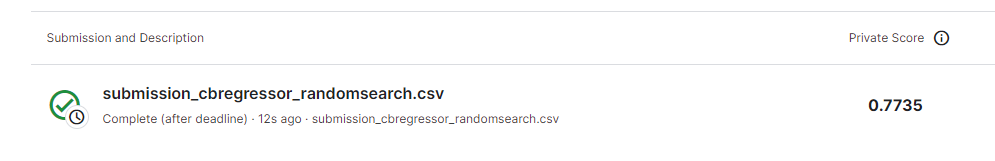

#### 9. VotingRegressor

In [196]:
%%time

regressor_1 = KNeighborsRegressor()

# Для LGBMRegressor будем использовать параметры найденные ранее с помощью RandomizedSearchCV.
regressor_2 = lgb.LGBMRegressor(objective ='regression', metric = 'mae', random_state=RANDOM_STATE,
                                reg_lambda=1.7142857142857142, reg_alpha=0.0, num_leaves=40, n_estimators=200)

voting_regressor_1 = VotingRegressor([('knregressor', regressor_1), ('lgbm', regressor_2)], verbose =1)

voting_regressor_1.fit(X_train, y_train)

make_log("train", "VotingRegressor 1", voting_regressor_1, None)

[Voting] .............. (1 of 2) Processing knregressor, total=  52.6s
[Voting] ..................... (2 of 2) Processing lgbm, total=  26.4s
CPU times: total: 2min 27s
Wall time: 1min 19s


In [197]:
%%time

y_pred_voting_regressor_1 = voting_regressor_1.predict(test_data)

make_log("predict", "VotingRegressor 1", voting_regressor_1, y_pred_voting_regressor_1)

make_submission_file(y_pred_voting_regressor_1, 'submission_voting_regressor_1.csv')

CPU times: total: 1h 12min 2s
Wall time: 1h 11min 54s


Посмотрим какой скор будет после сабмита.

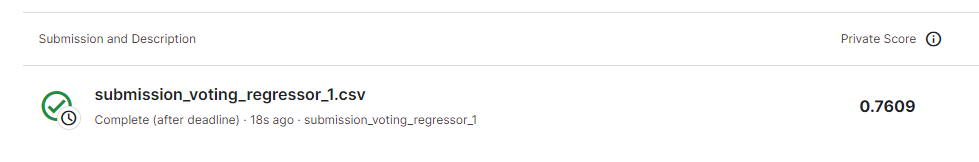

In [205]:
%%time

# Для CatBoostRegressor будем использовать параметры найденные ранее с помощью RandomizedSearchCV.
regressor_3 = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='MAE', n_estimators=500, learning_rate=0.18,
                                 l2_leaf_reg=7, depth=11)

voting_regressor_2 = VotingRegressor([('knregressor', regressor_1), ('catboostregressor', regressor_3)], verbose =1)

voting_regressor_2.fit(X_train, y_train)

make_log("train", "VotingRegressor 2 (KNeighborsRegressor+CatBoostRegressor)", voting_regressor_2, None)

[Voting] .............. (1 of 2) Processing knregressor, total=  36.4s
0:	learn: 4.2594732	total: 761ms	remaining: 6m 19s
1:	learn: 3.5950623	total: 1.45s	remaining: 6m 2s
2:	learn: 3.0441680	total: 2.14s	remaining: 5m 54s
3:	learn: 2.6091936	total: 2.85s	remaining: 5m 53s
4:	learn: 2.2886407	total: 3.53s	remaining: 5m 49s
5:	learn: 2.0258291	total: 4.18s	remaining: 5m 43s
6:	learn: 1.8014612	total: 4.85s	remaining: 5m 41s
7:	learn: 1.6334248	total: 5.51s	remaining: 5m 38s
8:	learn: 1.4980142	total: 6.18s	remaining: 5m 37s
9:	learn: 1.3812145	total: 6.89s	remaining: 5m 37s
10:	learn: 1.2973427	total: 7.57s	remaining: 5m 36s
11:	learn: 1.2203462	total: 8.24s	remaining: 5m 35s
12:	learn: 1.1524361	total: 8.94s	remaining: 5m 35s
13:	learn: 1.0878832	total: 9.65s	remaining: 5m 35s
14:	learn: 1.0447341	total: 10.3s	remaining: 5m 33s
15:	learn: 1.0088836	total: 11s	remaining: 5m 33s
16:	learn: 0.9816982	total: 11.7s	remaining: 5m 33s
17:	learn: 0.9575764	total: 12.4s	remaining: 5m 33s
18:	le

156:	learn: 0.5501246	total: 1m 48s	remaining: 3m 58s
157:	learn: 0.5492054	total: 1m 49s	remaining: 3m 57s
158:	learn: 0.5488751	total: 1m 50s	remaining: 3m 56s
159:	learn: 0.5485905	total: 1m 50s	remaining: 3m 55s
160:	learn: 0.5479417	total: 1m 51s	remaining: 3m 55s
161:	learn: 0.5471588	total: 1m 52s	remaining: 3m 54s
162:	learn: 0.5468350	total: 1m 53s	remaining: 3m 53s
163:	learn: 0.5465039	total: 1m 53s	remaining: 3m 53s
164:	learn: 0.5461531	total: 1m 54s	remaining: 3m 52s
165:	learn: 0.5457961	total: 1m 55s	remaining: 3m 51s
166:	learn: 0.5451574	total: 1m 55s	remaining: 3m 50s
167:	learn: 0.5445708	total: 1m 56s	remaining: 3m 50s
168:	learn: 0.5442193	total: 1m 57s	remaining: 3m 49s
169:	learn: 0.5431298	total: 1m 57s	remaining: 3m 48s
170:	learn: 0.5425369	total: 1m 58s	remaining: 3m 48s
171:	learn: 0.5420672	total: 1m 59s	remaining: 3m 47s
172:	learn: 0.5413477	total: 1m 59s	remaining: 3m 46s
173:	learn: 0.5405413	total: 2m	remaining: 3m 45s
174:	learn: 0.5402642	total: 2m 

309:	learn: 0.4906698	total: 3m 36s	remaining: 2m 12s
310:	learn: 0.4904803	total: 3m 36s	remaining: 2m 11s
311:	learn: 0.4902794	total: 3m 37s	remaining: 2m 11s
312:	learn: 0.4900722	total: 3m 38s	remaining: 2m 10s
313:	learn: 0.4897685	total: 3m 39s	remaining: 2m 9s
314:	learn: 0.4893778	total: 3m 39s	remaining: 2m 9s
315:	learn: 0.4890920	total: 3m 40s	remaining: 2m 8s
316:	learn: 0.4888363	total: 3m 41s	remaining: 2m 7s
317:	learn: 0.4886067	total: 3m 42s	remaining: 2m 7s
318:	learn: 0.4884528	total: 3m 42s	remaining: 2m 6s
319:	learn: 0.4883276	total: 3m 43s	remaining: 2m 5s
320:	learn: 0.4881758	total: 3m 44s	remaining: 2m 5s
321:	learn: 0.4877317	total: 3m 45s	remaining: 2m 4s
322:	learn: 0.4875410	total: 3m 45s	remaining: 2m 3s
323:	learn: 0.4873441	total: 3m 46s	remaining: 2m 3s
324:	learn: 0.4871050	total: 3m 47s	remaining: 2m 2s
325:	learn: 0.4868316	total: 3m 47s	remaining: 2m 1s
326:	learn: 0.4866700	total: 3m 48s	remaining: 2m
327:	learn: 0.4864998	total: 3m 49s	remaining

464:	learn: 0.4586803	total: 5m 24s	remaining: 24.4s
465:	learn: 0.4584868	total: 5m 25s	remaining: 23.7s
466:	learn: 0.4583338	total: 5m 26s	remaining: 23s
467:	learn: 0.4581888	total: 5m 26s	remaining: 22.3s
468:	learn: 0.4580161	total: 5m 27s	remaining: 21.6s
469:	learn: 0.4578336	total: 5m 28s	remaining: 20.9s
470:	learn: 0.4575697	total: 5m 28s	remaining: 20.2s
471:	learn: 0.4574411	total: 5m 29s	remaining: 19.5s
472:	learn: 0.4573114	total: 5m 30s	remaining: 18.8s
473:	learn: 0.4570526	total: 5m 30s	remaining: 18.2s
474:	learn: 0.4569230	total: 5m 31s	remaining: 17.5s
475:	learn: 0.4568075	total: 5m 32s	remaining: 16.8s
476:	learn: 0.4567540	total: 5m 33s	remaining: 16.1s
477:	learn: 0.4565786	total: 5m 33s	remaining: 15.4s
478:	learn: 0.4564005	total: 5m 34s	remaining: 14.7s
479:	learn: 0.4562407	total: 5m 35s	remaining: 14s
480:	learn: 0.4560835	total: 5m 35s	remaining: 13.3s
481:	learn: 0.4559949	total: 5m 36s	remaining: 12.6s
482:	learn: 0.4559481	total: 5m 37s	remaining: 11.

In [206]:
%%time

y_pred_voting_regressor_2 = voting_regressor_2.predict(test_data)

make_log("predict", "VotingRegressor 2 (KNeighborsRegressor+CatBoostRegressor)", voting_regressor_2, y_pred_voting_regressor_2)

make_submission_file(y_pred_voting_regressor_2, 'submission_voting_regressor_2.csv')

CPU times: total: 1h 10min 14s
Wall time: 1h 9min 52s


Посмотрим какой скор будет после сабмита.

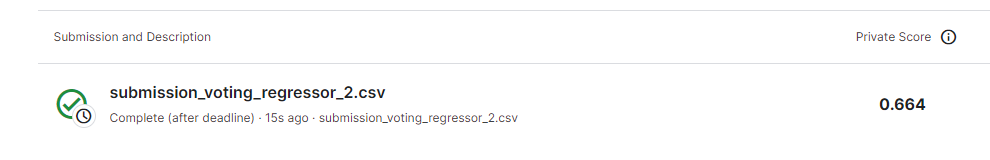

In [207]:
%%time

voting_regressor_3 = VotingRegressor([('lgbmregressor', regressor_2), ('catboostregressor', regressor_3)], verbose =1)

voting_regressor_3.fit(X_train, y_train)

make_log("train", "VotingRegressor 3 (LGBMRegressor+CatBoostRegressor)", voting_regressor_3, None)

[Voting] ............ (1 of 2) Processing lgbmregressor, total=  25.6s
0:	learn: 4.2594732	total: 760ms	remaining: 6m 19s
1:	learn: 3.5950623	total: 1.48s	remaining: 6m 7s
2:	learn: 3.0441680	total: 2.21s	remaining: 6m 5s
3:	learn: 2.6091936	total: 2.9s	remaining: 6m
4:	learn: 2.2886407	total: 3.58s	remaining: 5m 54s
5:	learn: 2.0258291	total: 4.24s	remaining: 5m 48s
6:	learn: 1.8014612	total: 4.92s	remaining: 5m 46s
7:	learn: 1.6334248	total: 5.59s	remaining: 5m 44s
8:	learn: 1.4980142	total: 6.25s	remaining: 5m 40s
9:	learn: 1.3812145	total: 6.95s	remaining: 5m 40s
10:	learn: 1.2973427	total: 7.65s	remaining: 5m 39s
11:	learn: 1.2203462	total: 8.35s	remaining: 5m 39s
12:	learn: 1.1524361	total: 9.13s	remaining: 5m 42s
13:	learn: 1.0878832	total: 9.9s	remaining: 5m 43s
14:	learn: 1.0447341	total: 10.7s	remaining: 5m 45s
15:	learn: 1.0088836	total: 11.4s	remaining: 5m 44s
16:	learn: 0.9816982	total: 12.1s	remaining: 5m 44s
17:	learn: 0.9575764	total: 12.9s	remaining: 5m 44s
18:	learn: 

156:	learn: 0.5501246	total: 1m 51s	remaining: 4m 3s
157:	learn: 0.5492054	total: 1m 52s	remaining: 4m 2s
158:	learn: 0.5488751	total: 1m 52s	remaining: 4m 2s
159:	learn: 0.5485905	total: 1m 53s	remaining: 4m 1s
160:	learn: 0.5479417	total: 1m 54s	remaining: 4m
161:	learn: 0.5471588	total: 1m 55s	remaining: 4m
162:	learn: 0.5468350	total: 1m 55s	remaining: 3m 59s
163:	learn: 0.5465039	total: 1m 56s	remaining: 3m 58s
164:	learn: 0.5461531	total: 1m 57s	remaining: 3m 57s
165:	learn: 0.5457961	total: 1m 57s	remaining: 3m 57s
166:	learn: 0.5451574	total: 1m 58s	remaining: 3m 56s
167:	learn: 0.5445708	total: 1m 59s	remaining: 3m 55s
168:	learn: 0.5442193	total: 1m 59s	remaining: 3m 54s
169:	learn: 0.5431298	total: 2m	remaining: 3m 53s
170:	learn: 0.5425369	total: 2m 1s	remaining: 3m 53s
171:	learn: 0.5420672	total: 2m 1s	remaining: 3m 52s
172:	learn: 0.5413477	total: 2m 2s	remaining: 3m 51s
173:	learn: 0.5405413	total: 2m 3s	remaining: 3m 50s
174:	learn: 0.5402642	total: 2m 3s	remaining: 3m

309:	learn: 0.4906698	total: 3m 38s	remaining: 2m 14s
310:	learn: 0.4904803	total: 3m 39s	remaining: 2m 13s
311:	learn: 0.4902794	total: 3m 40s	remaining: 2m 12s
312:	learn: 0.4900722	total: 3m 40s	remaining: 2m 11s
313:	learn: 0.4897685	total: 3m 41s	remaining: 2m 11s
314:	learn: 0.4893778	total: 3m 42s	remaining: 2m 10s
315:	learn: 0.4890920	total: 3m 43s	remaining: 2m 9s
316:	learn: 0.4888363	total: 3m 43s	remaining: 2m 9s
317:	learn: 0.4886067	total: 3m 44s	remaining: 2m 8s
318:	learn: 0.4884528	total: 3m 45s	remaining: 2m 7s
319:	learn: 0.4883276	total: 3m 45s	remaining: 2m 7s
320:	learn: 0.4881758	total: 3m 46s	remaining: 2m 6s
321:	learn: 0.4877317	total: 3m 47s	remaining: 2m 5s
322:	learn: 0.4875410	total: 3m 48s	remaining: 2m 4s
323:	learn: 0.4873441	total: 3m 48s	remaining: 2m 4s
324:	learn: 0.4871050	total: 3m 49s	remaining: 2m 3s
325:	learn: 0.4868316	total: 3m 50s	remaining: 2m 2s
326:	learn: 0.4866700	total: 3m 50s	remaining: 2m 2s
327:	learn: 0.4864998	total: 3m 51s	rema

464:	learn: 0.4586803	total: 5m 28s	remaining: 24.7s
465:	learn: 0.4584868	total: 5m 29s	remaining: 24s
466:	learn: 0.4583338	total: 5m 29s	remaining: 23.3s
467:	learn: 0.4581888	total: 5m 30s	remaining: 22.6s
468:	learn: 0.4580161	total: 5m 31s	remaining: 21.9s
469:	learn: 0.4578336	total: 5m 31s	remaining: 21.2s
470:	learn: 0.4575697	total: 5m 32s	remaining: 20.5s
471:	learn: 0.4574411	total: 5m 33s	remaining: 19.8s
472:	learn: 0.4573114	total: 5m 34s	remaining: 19.1s
473:	learn: 0.4570526	total: 5m 34s	remaining: 18.4s
474:	learn: 0.4569230	total: 5m 35s	remaining: 17.7s
475:	learn: 0.4568075	total: 5m 36s	remaining: 16.9s
476:	learn: 0.4567540	total: 5m 36s	remaining: 16.2s
477:	learn: 0.4565786	total: 5m 37s	remaining: 15.5s
478:	learn: 0.4564005	total: 5m 38s	remaining: 14.8s
479:	learn: 0.4562407	total: 5m 38s	remaining: 14.1s
480:	learn: 0.4560835	total: 5m 39s	remaining: 13.4s
481:	learn: 0.4559949	total: 5m 40s	remaining: 12.7s
482:	learn: 0.4559481	total: 5m 41s	remaining: 1

In [208]:
%%time

y_pred_voting_regressor_3 = voting_regressor_3.predict(test_data)

make_log("predict", "VotingRegressor 3 (LGBMRegressor+CatBoostRegressor)", voting_regressor_3, y_pred_voting_regressor_3)

make_submission_file(y_pred_voting_regressor_3, 'submission_voting_regressor_3.csv')

CPU times: total: 56.2 s
Wall time: 12.9 s


Посмотрим какой скор будет после сабмита.

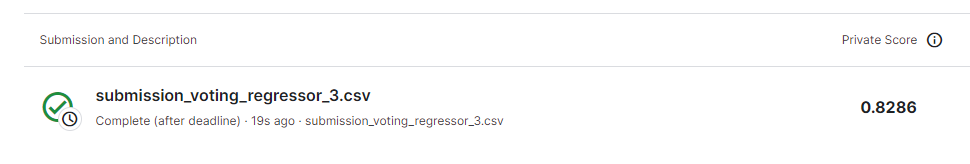

### ВЫВОД: Видим, что бейзлайн LightAutoML с его скором MAE в 0.6824 удалось побить только сделав сначала RandomizeSearch у CatBoostRegressor и после нахождения лучших параметров объединить CatBoostRegressor и  KNeighborsRegressor с помощью VotingRegressor. Получился скор MAE 0.664. Но, как показывает практика, зачастую решает не метод машинного обучения, а feature engineering. Поэтому в качестве эксперимента попробуем ещё сгенерировать дополнительные признаки к тем, что уже были созданы и посмотрим на скор просто ради интереса.

In [185]:
# Функция генерации дополнительных признаков. К тем признакам, что уже были добавим новые.
# Добавим ещё лаги к u_in. Добавим кумулятивную сумму и разность с предыдущим значением для time_step.
def generate_features_v4(df, mode):
    data = copy.deepcopy(df)
    data['u_in_lag_1'] = data.groupby('breath_id')['u_in'].shift(1)
    data['u_in_lag_2'] = data.groupby('breath_id')['u_in'].shift(2)
    data['u_in_lag_-1'] = data.groupby('breath_id')['u_in'].shift(-1)
    data['u_in_lag_-2'] = data.groupby('breath_id')['u_in'].shift(-2)
    data['u_in_cumsum'] = data['u_in'].groupby(data['breath_id']).cumsum()
    data['u_in_first'] = data.groupby('breath_id')['u_in'].transform('first')
    data['u_in_last'] = data.groupby('breath_id')['u_in'].transform('last')
    data['u_in_min'] = data.groupby('breath_id')['u_in'].transform('min')
    data['u_in_max'] = data.groupby('breath_id')['u_in'].transform('max')
    data['u_in_median'] = data.groupby('breath_id')['u_in'].transform('median')
    
    # Добавим дополнительные признаки.
    data['time_step_diff'] = data.groupby('breath_id')['time_step'].diff()
    data['time_step_cumsum'] = data.groupby(['breath_id'])['time_step'].cumsum()
    data['u_in_lag_3'] = data.groupby('breath_id')['u_in'].shift(3)
    data['u_in_lag_4'] = data.groupby('breath_id')['u_in'].shift(4)
    data['u_in_lag_-3'] = data.groupby('breath_id')['u_in'].shift(-3)
    data['u_in_lag_-4'] = data.groupby('breath_id')['u_in'].shift(-4)
    
    data = data.fillna(0)
        
    if mode == "train":
        data_pressure_subzero = data[data['pressure'] < 0]
        pressure_subzero_id = list(set(data_pressure_subzero.breath_id.values))
        data = data[data['breath_id'].apply(lambda x: x not in pressure_subzero_id)]
    
    data = data.drop(['breath_id', 'id'], axis=1)
    
    return data

In [186]:
# Сгенерируем дополнительные признаки для трейна.
train_new_features = generate_features_v4(df_train, "train")

train_new_features.head()

,R,C,time_step,u_in,u_out,pressure,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,...,u_in_last,u_in_min,u_in_max,u_in_median,time_step_diff,time_step_cumsum,u_in_lag_3,u_in_lag_4,u_in_lag_-3,u_in_lag_-4
0,20,50,0.000000,0.083334,0,5.837492,0.000000,0.000000,18.383041,22.509278,...,4.987079,0.0,28.313036,4.922568,0.000000,0.000000,0.000000,0.000000,22.808822,25.355850
1,20,50,0.033652,18.383041,0,5.907794,0.083334,0.000000,22.509278,22.808822,...,4.987079,0.0,28.313036,4.922568,0.033652,0.033652,0.000000,0.000000,25.355850,27.259866
2,20,50,0.067514,22.509278,0,7.876254,18.383041,0.083334,22.808822,25.355850,...,4.987079,0.0,28.313036,4.922568,0.033862,0.101167,0.000000,0.000000,27.259866,27.127486
3,20,50,0.101542,22.808822,0,11.742872,22.509278,18.383041,25.355850,27.259866,...,4.987079,0.0,28.313036,4.922568,0.034028,0.202709,0.083334,0.000000,27.127486,26.807732
4,20,50,0.135756,25.355850,0,12.234987,22.808822,22.509278,27.259866,27.127486,...,4.987079,0.0,28.313036,4.922568,0.034213,0.338464,18.383041,0.083334,26.807732,27.864715


In [187]:
# Сгенерируем дополнительные признаки для теста.
test_new_features = generate_features_v4(df_test, "test")

test_new_features.head()

,R,C,time_step,u_in,u_out,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,u_in_cumsum,...,u_in_last,u_in_min,u_in_max,u_in_median,time_step_diff,time_step_cumsum,u_in_lag_3,u_in_lag_4,u_in_lag_-3,u_in_lag_-4
0,5,20,0.000000,0.000000,0,0.000000,0.000000,7.515046,14.651675,0.000000,...,4.973375,0.0,37.542219,4.683875,0.000000,0.000000,0.000000,0.0,21.230610,26.320956
1,5,20,0.031904,7.515046,0,0.000000,0.000000,14.651675,21.230610,7.515046,...,4.973375,0.0,37.542219,4.683875,0.031904,0.031904,0.000000,0.0,26.320956,30.486938
2,5,20,0.063827,14.651675,0,7.515046,0.000000,21.230610,26.320956,22.166721,...,4.973375,0.0,37.542219,4.683875,0.031924,0.095731,0.000000,0.0,30.486938,33.545950
3,5,20,0.095751,21.230610,0,14.651675,7.515046,26.320956,30.486938,43.397331,...,4.973375,0.0,37.542219,4.683875,0.031924,0.191482,0.000000,0.0,33.545950,35.717600
4,5,20,0.127644,26.320956,0,21.230610,14.651675,30.486938,33.545950,69.718287,...,4.973375,0.0,37.542219,4.683875,0.031893,0.319126,7.515046,0.0,35.717600,36.971061


In [188]:
train_new_features.isnull().sum()

R                   0
C                   0
time_step           0
u_in                0
u_out               0
pressure            0
u_in_lag_1          0
u_in_lag_2          0
u_in_lag_-1         0
u_in_lag_-2         0
u_in_cumsum         0
u_in_first          0
u_in_last           0
u_in_min            0
u_in_max            0
u_in_median         0
time_step_diff      0
time_step_cumsum    0
u_in_lag_3          0
u_in_lag_4          0
u_in_lag_-3         0
u_in_lag_-4         0
dtype: int64

In [189]:
test_new_features.isnull().sum()

R                   0
C                   0
time_step           0
u_in                0
u_out               0
u_in_lag_1          0
u_in_lag_2          0
u_in_lag_-1         0
u_in_lag_-2         0
u_in_cumsum         0
u_in_first          0
u_in_last           0
u_in_min            0
u_in_max            0
u_in_median         0
time_step_diff      0
time_step_cumsum    0
u_in_lag_3          0
u_in_lag_4          0
u_in_lag_-3         0
u_in_lag_-4         0
dtype: int64

In [190]:
y_train_new = train_new_features[[TARGET_NAME]]
X_train_new = train_new_features.drop([TARGET_NAME], axis=1)
X_train_new.head()

,R,C,time_step,u_in,u_out,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,u_in_cumsum,...,u_in_last,u_in_min,u_in_max,u_in_median,time_step_diff,time_step_cumsum,u_in_lag_3,u_in_lag_4,u_in_lag_-3,u_in_lag_-4
0,20,50,0.000000,0.083334,0,0.000000,0.000000,18.383041,22.509278,0.083334,...,4.987079,0.0,28.313036,4.922568,0.000000,0.000000,0.000000,0.000000,22.808822,25.355850
1,20,50,0.033652,18.383041,0,0.083334,0.000000,22.509278,22.808822,18.466375,...,4.987079,0.0,28.313036,4.922568,0.033652,0.033652,0.000000,0.000000,25.355850,27.259866
2,20,50,0.067514,22.509278,0,18.383041,0.083334,22.808822,25.355850,40.975653,...,4.987079,0.0,28.313036,4.922568,0.033862,0.101167,0.000000,0.000000,27.259866,27.127486
3,20,50,0.101542,22.808822,0,22.509278,18.383041,25.355850,27.259866,63.784476,...,4.987079,0.0,28.313036,4.922568,0.034028,0.202709,0.083334,0.000000,27.127486,26.807732
4,20,50,0.135756,25.355850,0,22.808822,22.509278,27.259866,27.127486,89.140326,...,4.987079,0.0,28.313036,4.922568,0.034213,0.338464,18.383041,0.083334,26.807732,27.864715


In [191]:
test_new_features.head()

,R,C,time_step,u_in,u_out,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,u_in_cumsum,...,u_in_last,u_in_min,u_in_max,u_in_median,time_step_diff,time_step_cumsum,u_in_lag_3,u_in_lag_4,u_in_lag_-3,u_in_lag_-4
0,5,20,0.000000,0.000000,0,0.000000,0.000000,7.515046,14.651675,0.000000,...,4.973375,0.0,37.542219,4.683875,0.000000,0.000000,0.000000,0.0,21.230610,26.320956
1,5,20,0.031904,7.515046,0,0.000000,0.000000,14.651675,21.230610,7.515046,...,4.973375,0.0,37.542219,4.683875,0.031904,0.031904,0.000000,0.0,26.320956,30.486938
2,5,20,0.063827,14.651675,0,7.515046,0.000000,21.230610,26.320956,22.166721,...,4.973375,0.0,37.542219,4.683875,0.031924,0.095731,0.000000,0.0,30.486938,33.545950
3,5,20,0.095751,21.230610,0,14.651675,7.515046,26.320956,30.486938,43.397331,...,4.973375,0.0,37.542219,4.683875,0.031924,0.191482,0.000000,0.0,33.545950,35.717600
4,5,20,0.127644,26.320956,0,21.230610,14.651675,30.486938,33.545950,69.718287,...,4.973375,0.0,37.542219,4.683875,0.031893,0.319126,7.515046,0.0,35.717600,36.971061


In [192]:
# Приведем данные трейна к одной шкале.
scaler_new = StandardScaler()
X_train_new = scaler_new.fit_transform(X_train_new)
print(X_train_new.shape)


# Приведем данные теста к одной шкале.
test_newdata = scaler_new.transform(test_new_features)
print(test_newdata.shape)

(6030160, 21)
(4024000, 21)


In [193]:
%%time

k_neigh_regressor_new = KNeighborsRegressor()

k_neigh_regressor_new.fit(X_train_new, y_train_new)

make_log("train", "KNeighborsRegressor with more features", k_neigh_regressor_new, None)

CPU times: total: 297 ms
Wall time: 435 ms


In [194]:
%%time

y_pred_knregressor_new = k_neigh_regressor_new.predict(test_newdata)

make_log("predict", "KNeighborsRegressor with more features", k_neigh_regressor_new, y_pred_knregressor_new)

make_submission_file(y_pred_knregressor_new, 'submission_knregressor_new.csv')

CPU times: total: 2d 5h 22min 59s
Wall time: 6h 23min 39s


Посмотрим какой скор будет после сабмита.

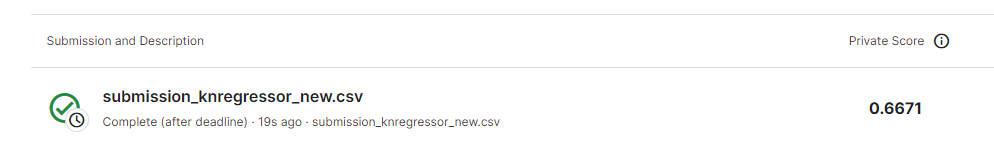

### На наборе данных с дополнительными сгенерированными признаками получено MAE 0.6671, которое меньше, чем у baseline с LAMA 0.6824. Вывод: Чтобы превзойти LAMA нужно либо долго перебирать модели и перебирать параметры для поиска лучшего сочетания, либо делать генерацию дополнительных признаков.